In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from tqdm import tqdm
import warnings

import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, precision_recall_curve, roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Pre-defined Functions

In [2]:
def classifier_performance(Y, Y_hat, Y_score):
    fpr, tpr, thresholds_roc = roc_curve(Y, Y_score)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 10})

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.grid(True)
    plt.show()
    
    
    precision = precision_score(Y, Y_hat)
    recall = recall_score(Y, Y_hat)
    f1 = f1_score(Y, Y_hat)
    print(f"Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F1 score: {round(f1, 4)}, Accuracy: {round(np.sum(Y == Y_hat) / Y.shape[0], 4)}")

In [3]:
def standardizer(X_train, X_test):
    """
    features need to be standardize:
    Total Land Transfer Area, Total Building Transfer Area, Current Building Layout-Rooms, Current Building Layout-Living Rooms,
    Current Building Layout-Bathrooms, Total Parking Space Area, Total Parking Price, Main Building Area, Auxiliary Building Area,
    Balcony Area, Latitude, Longitude, Total Floors, Sale Floor, 'Age', Building land ratio, Main Building Percentage
    """
    features = ['Total Land Transfer Area', 'Total Building Transfer Area', 'Current Building Layout-Rooms', 'Current Building Layout-Living Rooms',
    'Current Building Layout-Bathrooms', 'Total Parking Space Area', 'Total Parking Price', 'Main Building Area', 'Auxiliary Building Area',
    'Balcony Area', 'Latitude', 'Longitude', 'Total Floors', 'Sale Floor', 'Age', 'Building land ratio', 'Main building percentage']
    X_c_train = X_train.copy()
    X_c_test = X_test.copy()

    for f in features:
        mean = X_c_train[f].mean()
        std = X_c_train[f].std()
        X_c_train[f] = (X_c_train[f] - mean)/ std
        X_c_test[f] = (X_c_test[f] - mean)/ std
        
    return X_c_train, X_c_test

In [4]:
def floor_preprocessing(X):
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

    X = X.copy()
    index = X[X['Total Floors'] == 0].index
    x = X.iloc[index]
    total_floors = [0] * x.shape[0]
    for i, j in enumerate(x['Building Type Residential Building (11 Floors and Above with Elevator)']):
        if j == 1:
            total_floors[i] = 11
    
    for i, j in enumerate(x['Building Type Apartment (5 Floors and Below without Elevator)']):
        if j == 1:
            total_floors[i] = 5
    
    for i, j in enumerate(x['Building Type Mansion (10 Floors and Below with Elevator)']):
        if j == 1:
            total_floors[i] = 10
    
    for i, j in enumerate(x['Building Type Detached House']):
        if j == 1:
            total_floors[i] = 4
            
    for i, j in enumerate(index):
        X['Total Floors'].iloc[j] = total_floors[i]
        X['Sale Floor'].iloc[j] = int(total_floors[i] / 2)
    
    index = X[X['Sale Floor'] == 0].index
    x = X.iloc[index]
    sale_floor = (x['Total Floors'] / 2).to_list()
    for i, j in enumerate(index):
        X['Sale Floor'].iloc[j] = int(sale_floor[i]) + 1
    
    return X

In [5]:
def district_price_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
    
    taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']
    X['Taipei'] = (X.loc[:, taipei].sum(axis = 1))
    
    price_dict = dict()
    price_dict['Taipei'] = X[X['Taipei'] == 1]['Price'].mean()
    price_dict['New Taipei'] = X[X['Taipei'] == 0]['Price'].mean()
    
    district = [i for i in X.columns if 'District' in i]
    for d in district:
        if X[X[d] == 1].shape[0] > 0:
            price_dict[d] = X[X[d] == 1]['Price'].mean()
        else:
            if d in taipei:
                price_dict[d] = price_dict['Taipei']
            else:
                price_dict[d] = price_dict['New Taipei']
                
    
    return price_dict

def parkingtype_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
        
    price_dict = dict()
    parkingtype = ["Parking Type Flat on Ground Level", 
                    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
                    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
                    "Parking Type Tower"]
    
    parking = [i for i in X.columns if 'Parking Type' in i]
    for p in parking:
        price_dict[p] = X[X[p] == 1]['Price'].mean()
    return price_dict

In [6]:
def district_preprocessing(X, price_dict):
    X = X.copy()
    district = [i for i in X.columns if 'District' in i]
    price = [0] * X.shape[0]
    for d in district:
        index = X[X[d] == 1].index
        for i in index:
            price[i] = price_dict[d]
    X['Dis_Price'] = price
    X['Dis_Price'] = (X['Dis_Price'] - X['Dis_Price'].mean())/ X['Dis_Price'].std()

    return X

def parkingtype_preprocessing(X, parking_dict):
    X = X.copy()
    parking = [i for i in X.columns if 'Parking Type' in i]
    price = [0] * X.shape[0]
    for p in parking:
        index = X[X[p] == 1].index
        for i in index:
            price[i] = parking_dict[p]
    X['ParkingType_Price'] = price
    X['ParkingType_Price'] = (X['ParkingType_Price'] - X['ParkingType_Price'].mean())/ X['ParkingType_Price'].std()
    return X


## Data Preprocessing

In [7]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("y_train.csv")

In [8]:
translated_columns = [
    "Index", "Total Land Transfer Area", "Total Building Transfer Area", 
    "Current Building Layout-Rooms", "Current Building Layout-Living Rooms", 
    "Current Building Layout-Bathrooms", "Total Parking Space Area", 
    "Total Parking Price", "Main Building Area", "Auxiliary Building Area", 
    "Balcony Area", "Latitude", "Longitude", "Deal Year", "Deal Month", "Deal Day", 
    "Built Year", "Built Month", "Built Day", "Total Floors", "Sale Floor", 
    "District_Sanxia", "District_Sanzhi", "District_Sanchong", "District_Zhonghe", 
    "District_Zhongshan", "District_Zhongzheng", "District_Wugu", "District_Xinyi", 
    "District_Neihu", "District_Bali", "District_Beitou", "District_Nangang", 
    "District_Tucheng", "District_Pinglin", "District_Shilin", "District_Datong", 
    "District_Da'an", "District_Wenshan", "District_Xindian", "District_Xinzhuang", 
    "District_Songshan", "District_Banqiao", "District_Linkou", "District_Shulin", 
    "District_Yonghe", "District_Xizhi", "District_Taishan", "District_Tamsui", 
    "District_Shenkeng", "District_Ruifang", "District_Shiding", "District_Shimen", 
    "District_Wanhua", "District_Wanli", "District_Luzhou", "District_Gongliao", 
    "District_Jinshan", "District_Shuangxi", "District_Yingge", "Transaction Target Land+Building", 
    "Transaction Target Land+Building+Parking Space", "Building Type Residential Building (11 Floors and Above with Elevator)", 
    "Building Type Apartment (5 Floors and Below without Elevator)", "Building Type Other", 
    "Building Type Storefront", "Building Type Factory/Office", 
    "Building Type Mansion (10 Floors and Below with Elevator)", "Building Type Farmhouse", 
    "Building Type Detached House", "Building Current Layout-Partitions Yes", 
    "Building Current Layout-Partitions No", "Management Organization Yes", 
    "Management Organization No", "Parking Type Flat on Ground Level", 
    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
    "Parking Type Tower", "Elevator Yes", "Elevator No"
]
pd.set_option('display.max_columns', None)
X_train.columns = translated_columns
X_test.columns = translated_columns

In [9]:
# Drop unrelated columns
drop = ['Index', 'Deal Year', 'Deal Day', 'Built Day', 'Built Month', 'Management Organization No', 'Elevator No', 
        "Building Current Layout-Partitions Yes", 'Deal Year', 'Built Year', 'Transaction Target Land+Building+Parking Space']

# Floor preprocessing
X_train = floor_preprocessing(X_train)
X_test = floor_preprocessing(X_test)

# Add some features
X_train['Main building percentage'] = X_train['Main Building Area'] / X_train['Total Building Transfer Area']
X_test['Main building percentage'] = X_test['Main Building Area'] / X_test['Total Building Transfer Area']
X_train['Building land ratio'] = X_train['Total Building Transfer Area'] / X_train['Total Land Transfer Area']
X_test['Building land ratio'] = X_test['Total Building Transfer Area'] / X_test['Total Land Transfer Area']
X_train['Living floor ratio'] = X_train['Sale Floor'] / X_train['Total Floors']
X_test['Living floor ratio'] = X_test['Sale Floor'] / X_test['Total Floors']

# Drop irrelevant columns
X_train.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)', 'Building Type Farmhouse'], inplace = True)
X_test.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)', 'Building Type Farmhouse'], inplace = True)

# Drop an outlier built year = 2
X_train['Price'] = Y_train['Price']
X_train = X_train.drop([X_train[X_train['Built Year'] == 2].index[0]]) 
X_train = X_train.drop([X_train[X_train['Price'] == 0].index[0]])
X_train.reset_index(inplace = True, drop = True)

# Drop outliers
zero_land_index = X_train[X_train['Total Land Transfer Area'] < 0.01].index
X_train = X_train.drop(zero_land_index.to_list())
X_train.reset_index(inplace = True, drop = True)

Y_train = X_train['Price']
X_train = X_train.drop(columns = ['Price'])

# Assign the median value to built year = 0
X_train_builtyearmedian = X_train[X_train["Built Year"] != 0]["Built Year"].median()
X_train.loc[X_train["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian
X_test.loc[X_test["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian

# Age feature
X_train['Age'] = X_train['Deal Year'] - X_train['Built Year']
X_test['Age'] = X_test['Deal Year'] - X_test['Built Year']

X_train.drop(columns = drop, inplace = True)
X_test.drop(columns = drop, inplace = True)

# Standardize
X_train_standardize, X_test_standardize = standardizer(X_train, X_test)

In [10]:
# Get the index
taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']

train_taipei_index = X_train_standardize[X_train_standardize[taipei].sum(axis = 1) == 1].index
train_newtaipei_index = np.where(~X_train_standardize.index.isin(train_taipei_index) == 1)[0]

test_taipei_index = X_test_standardize[X_test_standardize[taipei].sum(axis = 1) == 1].index
test_newtaipei_index = np.where(~X_test_standardize.index.isin(test_taipei_index) == 1)[0]

## Naive Regression

In [11]:
# Target encoding District and Parking Type
X_train_standardize_naive = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize_naive = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize_naive = parkingtype_preprocessing(X_train_standardize_naive, parkingtype_dict(X_train, Y_train))
X_test_standardize_naive = parkingtype_preprocessing(X_test_standardize_naive, parkingtype_dict(X_train, Y_train))

district = X_train_standardize_naive.columns[X_train_standardize_naive.columns.str.contains('District')]
X_train_standardize_naive = X_train_standardize_naive.drop(columns = district)
X_test_standardize_naive = X_test_standardize_naive.drop(columns = district)

parking = X_train_standardize_naive.columns[X_train_standardize_naive.columns.str.contains('Parking Type')]
X_train_standardize_naive = X_train_standardize_naive.drop(columns = parking)
X_test_standardize_naive = X_test_standardize_naive.drop(columns = parking)

<Axes: >

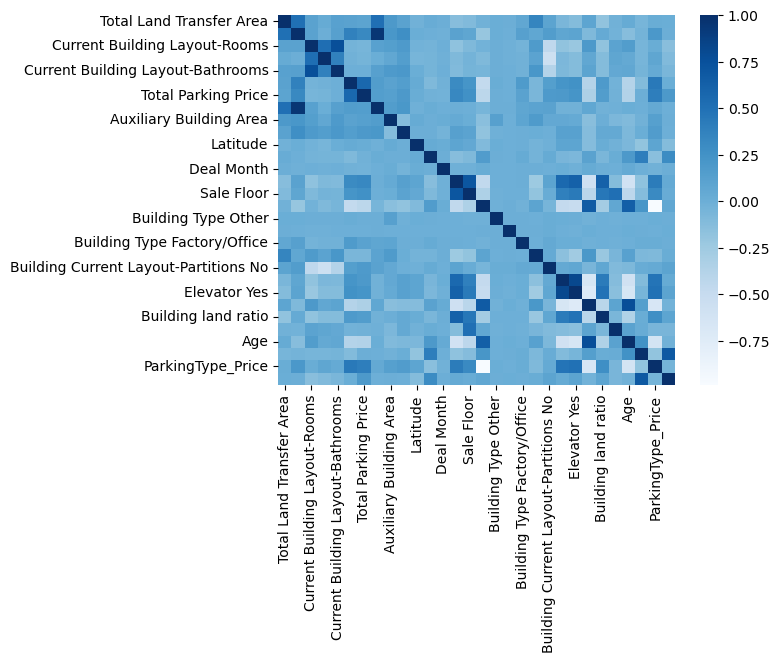

In [12]:
corr = pd.concat([X_train_standardize_naive, Y_train], axis = 1).corr()
sns.heatmap(corr, cmap="Blues", annot=False)

In [13]:
lightgbm_model_naive = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model_naive.fit(X_train_standardize_naive, Y_train)
Y_hat_naive = lightgbm_model_naive.predict(X_train_standardize_naive)

train_index = X_train_standardize_naive.index
train_dict = {'index' : train_index, 'predict': Y_hat_naive}
train_pd = pd.DataFrame(train_dict)

district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")

print(f"Totol training data MAE of Naive regression: {round(mean_absolute_error(Y_hat_naive, Y_train), 4)}")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

Y_test_hat = lightgbm_model_naive.predict(X_test_standardize_naive)
test_dict = {'Index' : X_test_standardize_naive.index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_NaiveGBM_{date}.csv", index = False)

----------No training data in District_Shiding----------
Totol training data MAE of Naive regression: 12160.5883


In [14]:
district_col = [i for i in X_train.columns if 'District' in i]
training_mean_dict = {"District": [], "Predicted": [], "Real": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        training_mean_dict['District'].append(i)
        training_mean_dict['Predicted'].append(Y_train_hat_district_i.mean())
        training_mean_dict['Real'].append(Y_train_district_i.mean())
    else:
        print(f"----------No training data in {i}----------")

pd.DataFrame(training_mean_dict)

----------No training data in District_Shiding----------


,District,Predicted,Real
0,District_Sanxia,86124.853585,86235.577167
1,District_Sanzhi,33134.903711,33312.238095
2,District_Sanchong,125963.232542,125693.897544
3,District_Zhonghe,130558.239679,130660.150786
4,District_Zhongshan,213912.638663,213672.921429
5,District_Zhongzheng,247208.179025,247936.617997
6,District_Wugu,87735.717598,86903.027692
7,District_Xinyi,240677.008665,240811.690418
8,District_Neihu,180490.663709,180260.337147
9,District_Bali,65831.111725,65530.567416


## Two Stage ML Model

(array([-2.50e+13,  0.00e+00,  2.50e+13,  5.00e+13,  7.50e+13,  1.00e+14,
         1.25e+14,  1.50e+14,  1.75e+14,  2.00e+14]),
 [Text(0, -25000000000000.0, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 25000000000000.0, '0.25'),
  Text(0, 50000000000000.0, '0.50'),
  Text(0, 75000000000000.0, '0.75'),
  Text(0, 100000000000000.0, '1.00'),
  Text(0, 125000000000000.0, '1.25'),
  Text(0, 150000000000000.0, '1.50'),
  Text(0, 175000000000000.0, '1.75'),
  Text(0, 200000000000000.0, '2.00')])

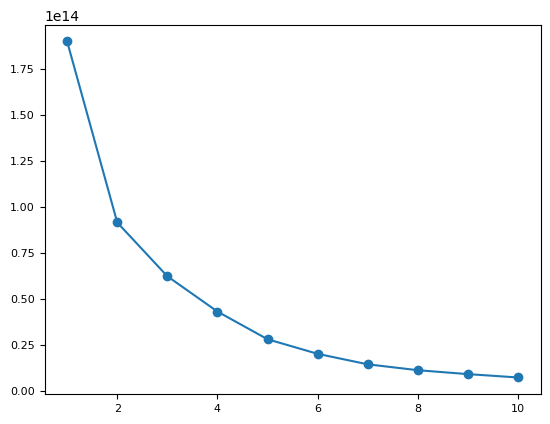

In [15]:
plt.rcParams.update({'font.size': 10})

inertia = []
for i in range(10):
    kmean = KMeans(n_clusters = i + 1, random_state = 0, n_init = 10)
    kmean.fit(Y_train.to_numpy().reshape(-1, 1))
    inertia.append(kmean.inertia_)
plt.plot([i + 1 for i in range(10)], inertia)
plt.scatter([i + 1 for i in range(10)], inertia)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

In [16]:
kmean = KMeans(n_clusters = 2, random_state = 0, n_init = 10)
kmean.fit(Y_train.to_numpy().reshape(-1, 1))
X_label = kmean.predict(Y_train.to_numpy().reshape(-1, 1))
print(f"numbers of 1: {np.sum(X_label)}, numbers of 0: {X_label.shape[0] - np.sum(X_label)}")

numbers of 1: 6795, numbers of 0: 23201


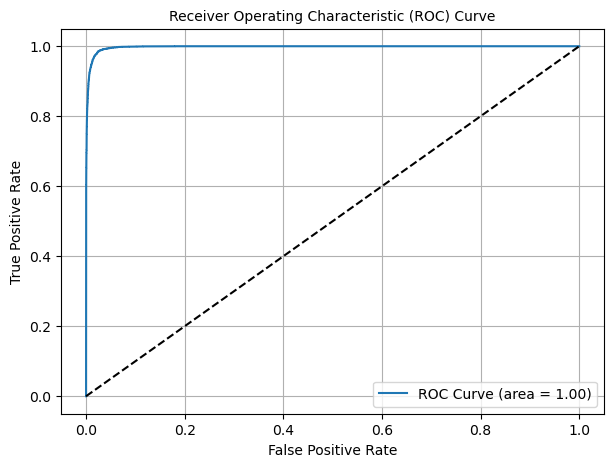

Precision: 0.9448, Recall: 0.9704, F1 score: 0.9575, Accuracy: 0.9805


In [17]:
classifier = lgb.LGBMClassifier(
                           boosting_type = 'gbdt', num_leaves = 10, 
                           max_depth = 6, learning_rate = 0.05, n_estimators = 5000, 
                           lambda_l1 = 3, lambda_l2 = 1, min_gain_to_split = 0.01,
                           bagging_freq = 10, scale_pos_weight = 1.5, feature_fraction = 0.6, verbose = -1
                          )
classifier.fit(X_train_standardize, X_label)
X_label_hat = classifier.predict(X_train_standardize) 
X_test_label_hat = classifier.predict(X_test_standardize) 
X_label_hat_prob = classifier.predict_proba(X_train_standardize)[:, 1]
classifier_performance(X_label, X_label_hat, X_label_hat_prob)

In [18]:
X_train_standardize = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize = parkingtype_preprocessing(X_train_standardize, parkingtype_dict(X_train, Y_train))
X_test_standardize = parkingtype_preprocessing(X_test_standardize, parkingtype_dict(X_train, Y_train))

district = X_train_standardize.columns[X_train_standardize.columns.str.contains('District')]
X_train_standardize = X_train_standardize.drop(columns = district)
X_test_standardize = X_test_standardize.drop(columns = district)

parking = X_train_standardize.columns[X_train_standardize.columns.str.contains('Parking Type')]
X_train_standardize = X_train_standardize.drop(columns = parking)
X_test_standardize = X_test_standardize.drop(columns = parking)

In [35]:
lightgbm_model1 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 6, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model0 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 6, learning_rate = 0.05, n_estimators = 5000, verbose = -1)

train_1_index = np.where(X_label_hat == 1)[0]
train_0_index = np.where(X_label_hat == 0)[0]

test_1_index = np.where(X_test_label_hat == 1)[0]
test_0_index = np.where(X_test_label_hat == 0)[0]

lightgbm_model1.fit(X_train_standardize.iloc[train_1_index], Y_train.iloc[train_1_index])
lightgbm_model0.fit(X_train_standardize.iloc[train_0_index], Y_train.iloc[train_0_index])

Y_train_hat_gbm1 = lightgbm_model1.predict(X_train_standardize.iloc[train_1_index])
Y_train_hat_gbm0 = lightgbm_model0.predict(X_train_standardize.iloc[train_0_index])

train_index = np.concatenate([train_0_index, train_1_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm0, Y_train_hat_gbm1], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd = pd.DataFrame(train_dict)
train_pd = train_pd.sort_values(by = 'index')
train_pd.set_index('index', drop = True, inplace = True)

Y_test_hat_gbm1 = lightgbm_model1.predict(X_test_standardize.iloc[test_1_index])
Y_test_hat_gbm0 = lightgbm_model0.predict(X_test_standardize.iloc[test_0_index])

test_index = np.concatenate([test_0_index, test_1_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm0, Y_test_hat_gbm1], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_2stageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 8221.243


In [36]:
# Model 0*
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_0_index][i]
        print(f"{i}: {data.sum()}")

District_Sanxia: 472
District_Sanzhi: 147
District_Sanchong: 1371
District_Zhonghe: 1917
District_Zhongshan: 407
District_Zhongzheng: 68
District_Wugu: 650
District_Xinyi: 148
District_Neihu: 664
District_Bali: 356
District_Beitou: 595
District_Nangang: 197
District_Tucheng: 1017
District_Pinglin: 1
District_Shilin: 454
District_Datong: 221
District_Da'an: 31
District_Wenshan: 748
District_Xindian: 1367
District_Xinzhuang: 2091
District_Songshan: 45
District_Banqiao: 1609
District_Linkou: 1089
District_Shulin: 585
District_Yonghe: 661
District_Xizhi: 1716
District_Taishan: 305
District_Tamsui: 2319
District_Shenkeng: 116
District_Ruifang: 72
District_Shiding: 0
District_Shimen: 3
District_Wanhua: 436
District_Wanli: 84
District_Luzhou: 553
District_Gongliao: 5
District_Jinshan: 55
District_Shuangxi: 5
District_Yingge: 437


In [37]:
# Model 1*ar
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_1_index][i]
        print(f"{i}: {data.sum()}")

District_Sanxia: 1
District_Sanzhi: 0
District_Sanchong: 54
District_Zhonghe: 119
District_Zhongshan: 1133
District_Zhongzheng: 521
District_Wugu: 0
District_Xinyi: 666
District_Neihu: 647
District_Bali: 0
District_Beitou: 206
District_Nangang: 278
District_Tucheng: 12
District_Pinglin: 0
District_Shilin: 334
District_Datong: 210
District_Da'an: 1013
District_Wenshan: 231
District_Xindian: 210
District_Xinzhuang: 46
District_Songshan: 606
District_Banqiao: 287
District_Linkou: 15
District_Shulin: 7
District_Yonghe: 159
District_Xizhi: 13
District_Taishan: 1
District_Tamsui: 3
District_Shenkeng: 1
District_Ruifang: 1
District_Shiding: 0
District_Shimen: 1
District_Wanhua: 201
District_Wanli: 0
District_Luzhou: 2
District_Gongliao: 0
District_Jinshan: 1
District_Shuangxi: 0
District_Yingge: 0


In [38]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,3705.998919,147
9,District_Bali,3892.793744,356
29,District_Ruifang,3973.785748,73
32,District_Wanli,4040.921735,84
13,District_Pinglin,4102.634694,1
27,District_Tamsui,4848.022150,2322
22,District_Linkou,4929.505938,1104
37,District_Yingge,5019.512796,437
36,District_Shuangxi,5041.817601,5
6,District_Wugu,5123.356145,650


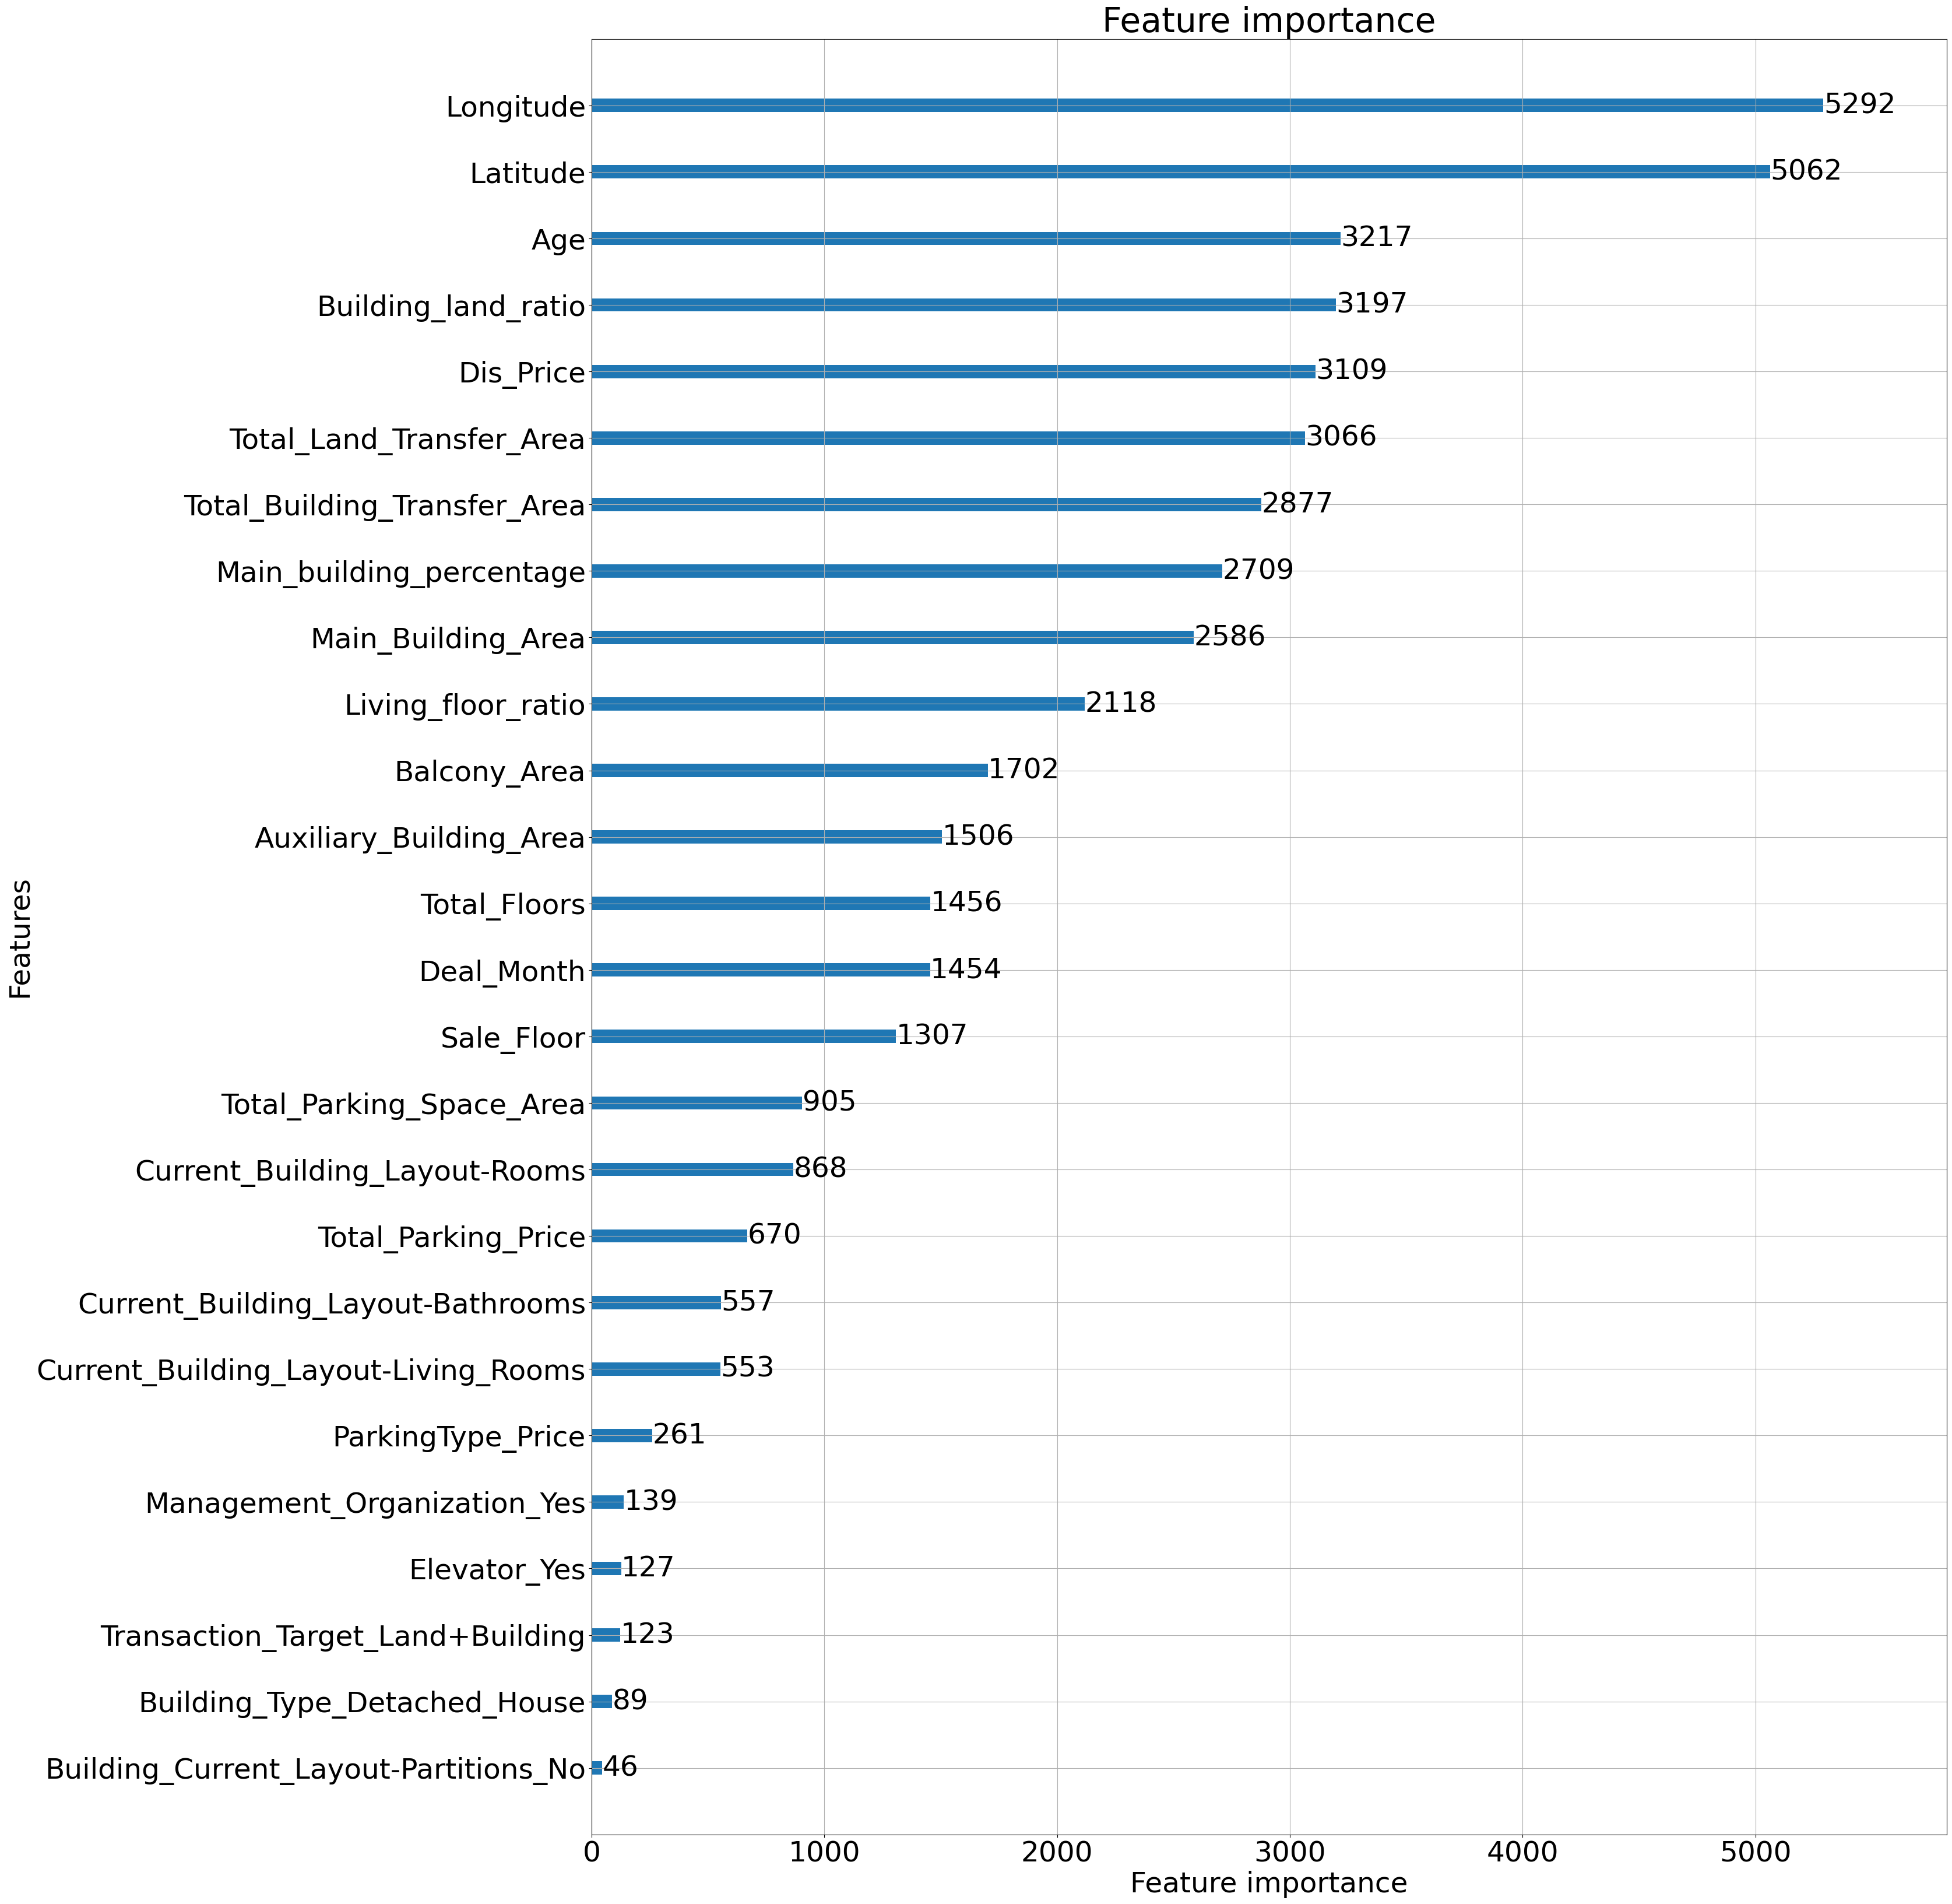

In [39]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model0)
fig = ax.figure
fig.set_size_inches(30, 40)

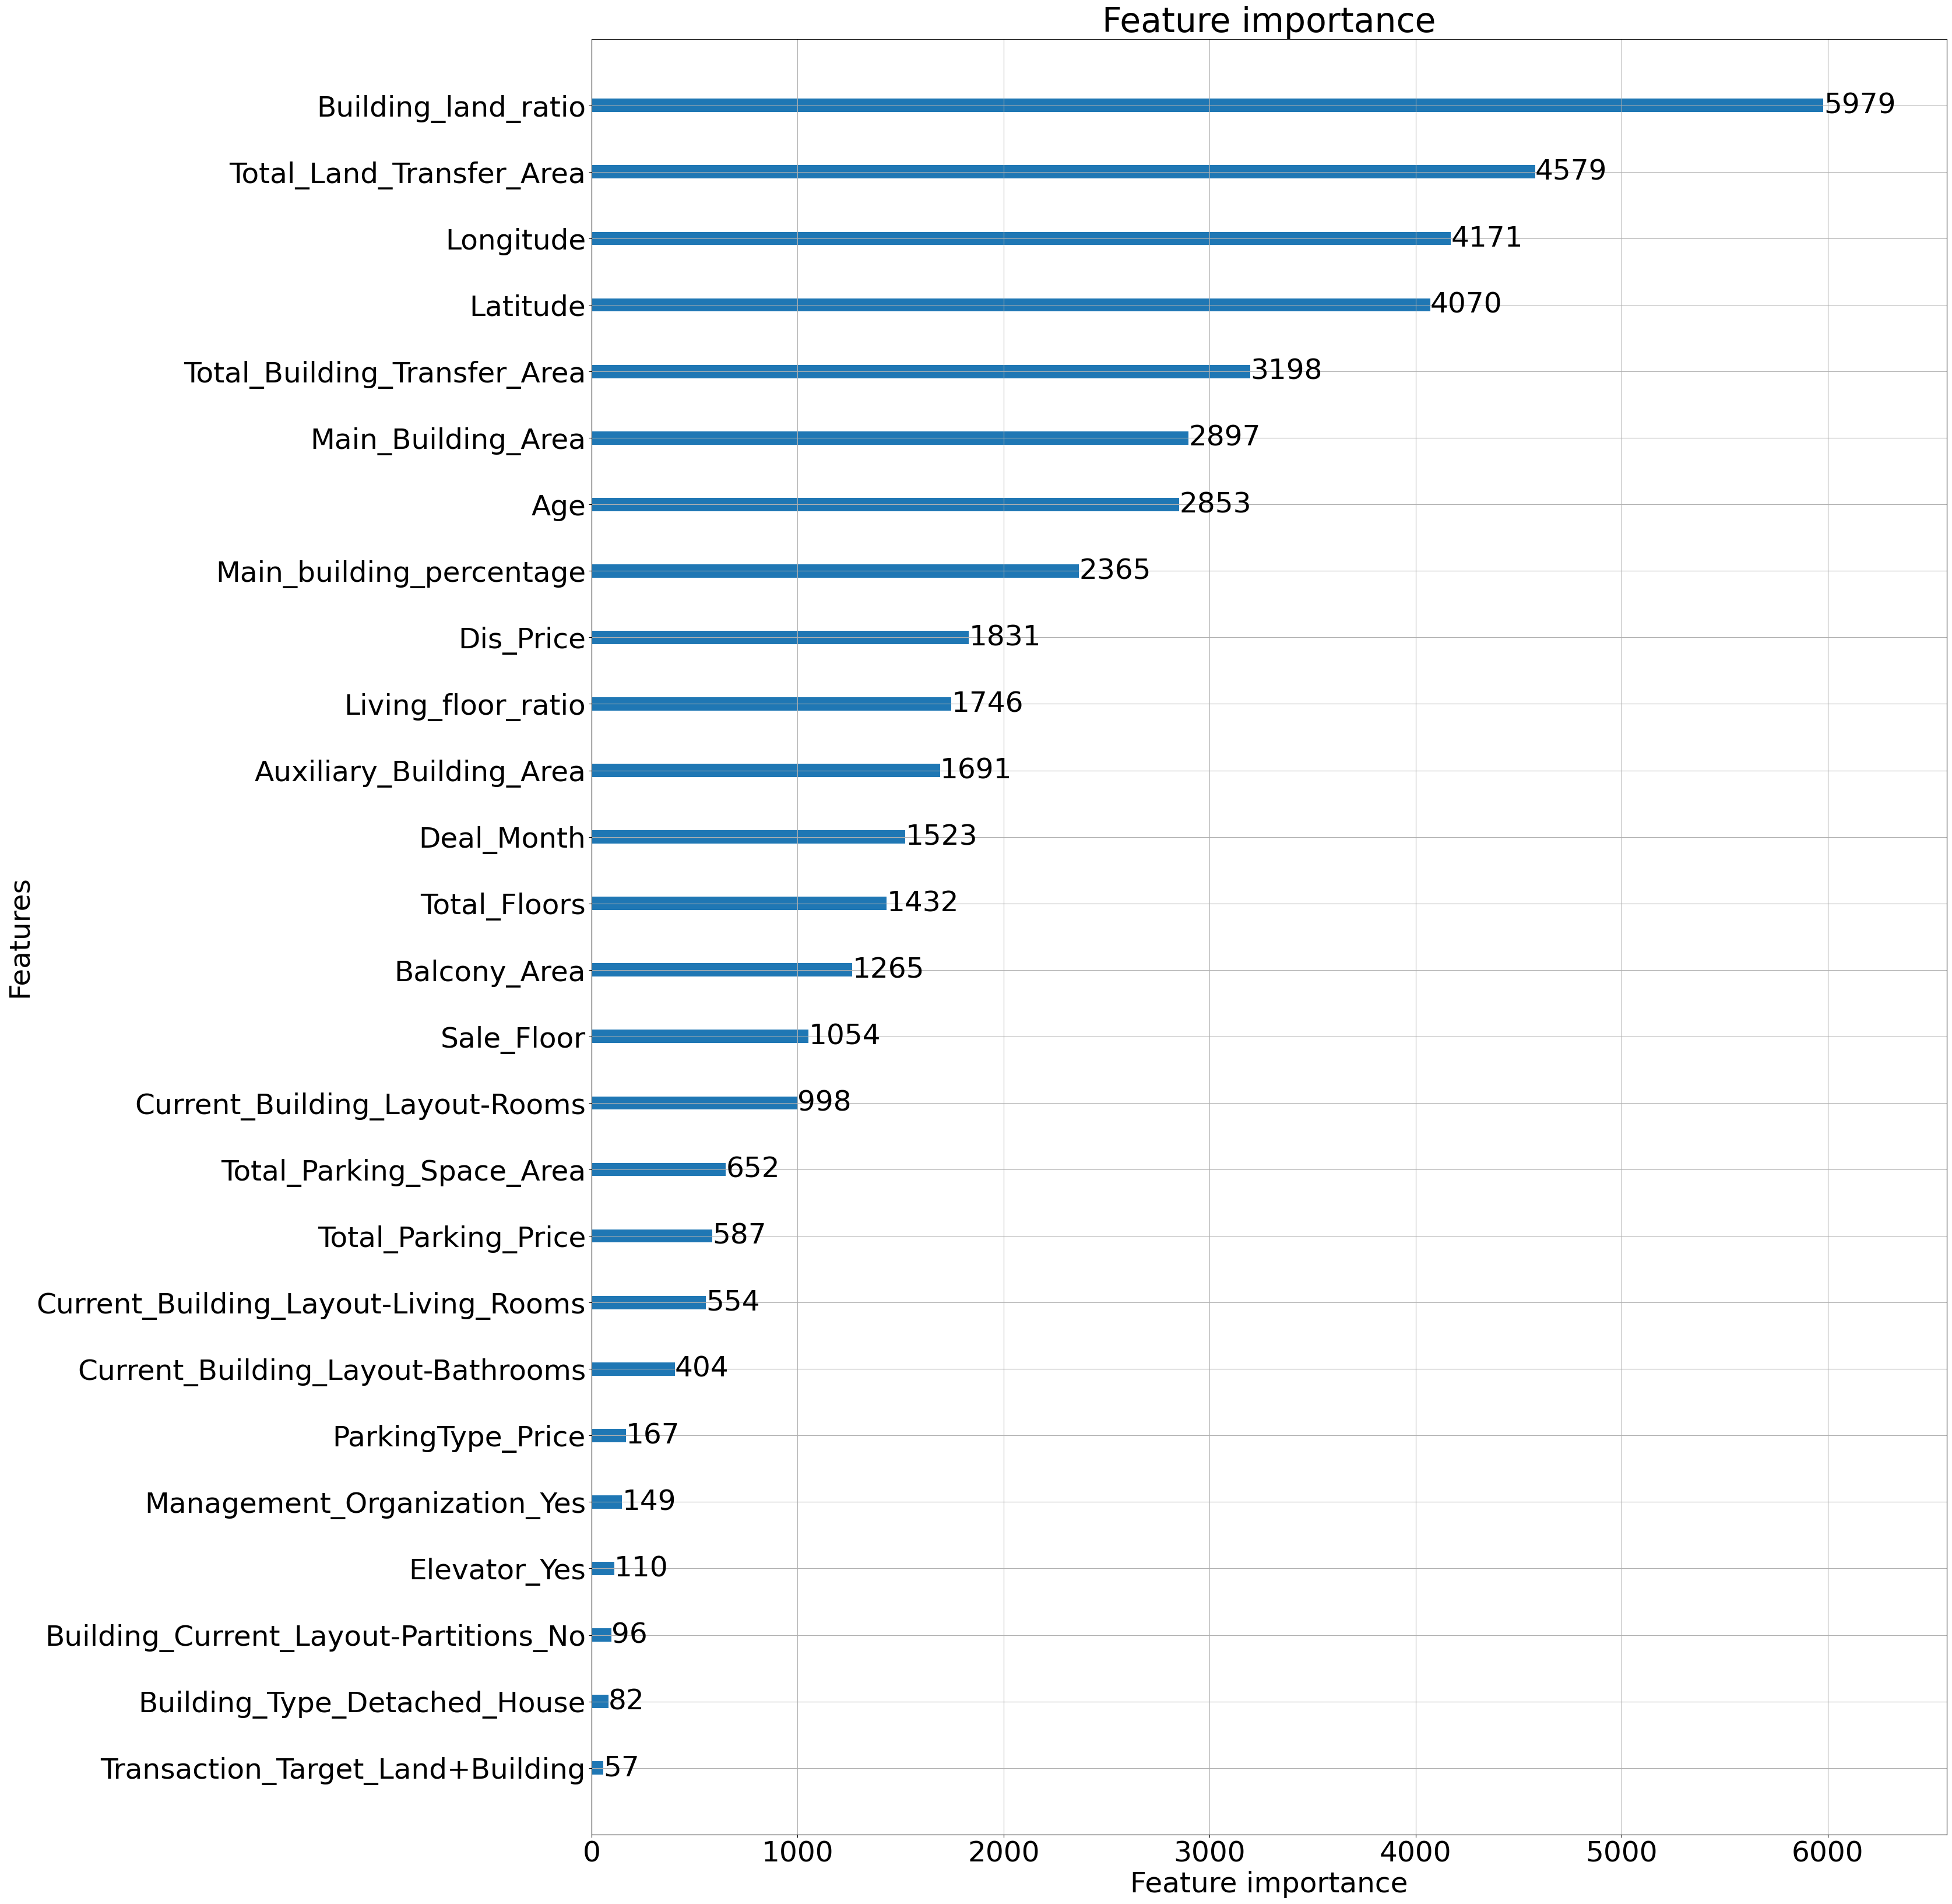

In [40]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model1)
fig = ax.figure
fig.set_size_inches(30, 40)

## Arbitrary Two Stage ML Model

In [41]:
lightgbm_model_taipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 6, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model_newtaipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 6, learning_rate = 0.05, n_estimators = 5000, verbose = -1)

lightgbm_model_taipei.fit(X_train_standardize.iloc[train_taipei_index], Y_train.iloc[train_taipei_index])
lightgbm_model_newtaipei.fit(X_train_standardize.iloc[train_newtaipei_index], Y_train.iloc[train_newtaipei_index])

Y_train_hat_gbm_taipei = lightgbm_model_taipei.predict(X_train_standardize.iloc[train_taipei_index])
Y_train_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_train_standardize.iloc[train_newtaipei_index])

train_index = np.concatenate([train_newtaipei_index, train_taipei_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm_newtaipei, Y_train_hat_gbm_taipei], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd_knowledge = pd.DataFrame(train_dict)
train_pd_knowledge = train_pd_knowledge.sort_values(by = 'index')
train_pd_knowledge.set_index('index', drop = True, inplace = True)

Y_test_hat_gbm_taipei = lightgbm_model_taipei.predict(X_test_standardize.iloc[test_taipei_index])
Y_test_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_test_standardize.iloc[test_newtaipei_index])

test_index = np.concatenate([test_newtaipei_index, test_taipei_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm_newtaipei, Y_test_hat_gbm_taipei], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_Knowledge2StageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd_knowledge['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 8726.03


In [42]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
30,District_Shimen,2545.755319,4
36,District_Shuangxi,2634.052025,5
1,District_Sanzhi,3635.985890,147
9,District_Bali,3872.984501,356
32,District_Wanli,4027.157251,84
27,District_Tamsui,4660.066978,2322
37,District_Yingge,4748.775083,437
6,District_Wugu,4886.665520,650
22,District_Linkou,4909.222279,1104
34,District_Gongliao,5303.075906,5


## Combined Model

In [43]:
test_pd = pd.read_csv(f"test_2stageGBM_{date}.csv")
test_pd_knowledge = pd.read_csv(f"test_Knowledge2StageGBM_{date}.csv")
test_pd['Price'] = 0.5*(test_pd['Price'] + test_pd_knowledge['Price'])
test_pd.to_csv(f"test_Mix2StageGBM_{date}.csv", index = False)

In [44]:
weights = [i/ 100 for i in range(0, 101)]
MAE_dict = dict()
min_mae = float('inf')
for w in weights:
    train_price = w* train_pd['predict'] + (1 - w)* train_pd_knowledge['predict']
    mae = mean_absolute_error(Y_train, train_price)
    MAE_dict[w] = (mae)
    if mae < min_mae:
        min_mae = mae
        min_weights = w
test_pd['Price'] = min_weights* test_pd['Price'] + (1 - min_weights)*test_pd_knowledge['Price']
test_pd.to_csv(f"test_Mix2StageGBM_optimalweight_{date}.csv", index = False)
print(f"Minimum MAE weight: {min_weights}")

Minimum MAE weight: 0.65


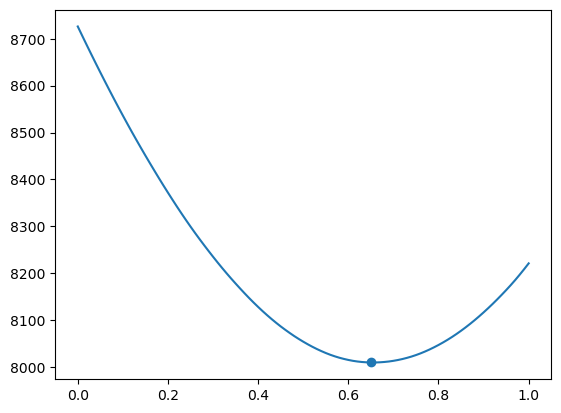

In [45]:
plt.rcParams.update({'font.size': 10})

plt.plot(MAE_dict.keys(), MAE_dict.values())
plt.scatter(min_weights, min_mae)

In [46]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = min_weights* train_pd['predict'].iloc[district_i_index] + (1 - min_weights)* train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,3503.894454,147
9,District_Bali,3744.580439,356
32,District_Wanli,3789.918898,84
36,District_Shuangxi,4150.188596,5
29,District_Ruifang,4273.247219,73
27,District_Tamsui,4659.530169,2322
22,District_Linkou,4726.750342,1104
37,District_Yingge,4781.184707,437
6,District_Wugu,4956.119819,650
35,District_Jinshan,5038.911548,56


## Cat Combinded Model

In [31]:
cat_model1 = CatBoostRegressor(n_estimators = 5000, depth = 6, learning_rate = 0.05)
cat_model0 = CatBoostRegressor(n_estimators = 5000, depth = 6, learning_rate = 0.05)

train_1_index = np.where(X_label_hat == 1)[0]
train_0_index = np.where(X_label_hat == 0)[0]

test_1_index = np.where(X_test_label_hat == 1)[0]
test_0_index = np.where(X_test_label_hat == 0)[0]

cat_model1.fit(X_train_standardize.iloc[train_1_index], Y_train.iloc[train_1_index])
cat_model0.fit(X_train_standardize.iloc[train_0_index], Y_train.iloc[train_0_index])

Y_train_hat_cat1 = cat_model1.predict(X_train_standardize.iloc[train_1_index])
Y_train_hat_cat0 = cat_model0.predict(X_train_standardize.iloc[train_0_index])

train_index = np.concatenate([train_0_index, train_1_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_cat0, Y_train_hat_cat1], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd = pd.DataFrame(train_dict)
train_pd = train_pd.sort_values(by = 'index')
train_pd.set_index('index', drop = True, inplace = True)

Y_test_hat_cat1 = cat_model1.predict(X_test_standardize.iloc[test_1_index])
Y_test_hat_cat0 = cat_model0.predict(X_test_standardize.iloc[test_0_index])

test_index = np.concatenate([test_0_index, test_1_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_cat0, Y_test_hat_cat1], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_2stageCAT_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

0:	learn: 96177.5692934	total: 136ms	remaining: 11m 19s
1:	learn: 95630.5996999	total: 139ms	remaining: 5m 46s
2:	learn: 94466.4216661	total: 141ms	remaining: 3m 55s
3:	learn: 93742.3720272	total: 144ms	remaining: 2m 59s
4:	learn: 92615.3535657	total: 147ms	remaining: 2m 26s
5:	learn: 92131.8651654	total: 149ms	remaining: 2m 4s
6:	learn: 91593.5716210	total: 152ms	remaining: 1m 48s
7:	learn: 91126.3219899	total: 155ms	remaining: 1m 36s
8:	learn: 90659.5574317	total: 158ms	remaining: 1m 27s
9:	learn: 89949.7877305	total: 160ms	remaining: 1m 20s
10:	learn: 89479.4626313	total: 163ms	remaining: 1m 13s
11:	learn: 89079.0295359	total: 166ms	remaining: 1m 8s
12:	learn: 87895.5130790	total: 169ms	remaining: 1m 4s
13:	learn: 87503.6141662	total: 171ms	remaining: 1m
14:	learn: 86356.8276728	total: 174ms	remaining: 57.8s
15:	learn: 85461.8097532	total: 177ms	remaining: 55.1s
16:	learn: 84553.3546617	total: 179ms	remaining: 52.5s
17:	learn: 84190.9960506	total: 182ms	remaining: 50.5s
18:	learn: 8

174:	learn: 49659.6735290	total: 526ms	remaining: 14.5s
175:	learn: 49603.8409131	total: 529ms	remaining: 14.5s
176:	learn: 49541.7022045	total: 531ms	remaining: 14.5s
177:	learn: 49441.0823645	total: 534ms	remaining: 14.5s
178:	learn: 49391.3531296	total: 536ms	remaining: 14.4s
179:	learn: 49291.5705741	total: 538ms	remaining: 14.4s
180:	learn: 49241.3560499	total: 541ms	remaining: 14.4s
181:	learn: 49171.0673766	total: 543ms	remaining: 14.4s
182:	learn: 49074.4641071	total: 546ms	remaining: 14.4s
183:	learn: 49002.8170272	total: 549ms	remaining: 14.4s
184:	learn: 48919.8117630	total: 551ms	remaining: 14.3s
185:	learn: 48865.6510050	total: 553ms	remaining: 14.3s
186:	learn: 48803.2702626	total: 555ms	remaining: 14.3s
187:	learn: 48703.6215297	total: 557ms	remaining: 14.3s
188:	learn: 48618.8795407	total: 559ms	remaining: 14.2s
189:	learn: 48556.9359385	total: 561ms	remaining: 14.2s
190:	learn: 48500.6121653	total: 564ms	remaining: 14.2s
191:	learn: 48422.6910352	total: 566ms	remaining

335:	learn: 42106.0244832	total: 914ms	remaining: 12.7s
336:	learn: 42062.0585455	total: 917ms	remaining: 12.7s
337:	learn: 42038.5430920	total: 920ms	remaining: 12.7s
338:	learn: 41999.4378961	total: 923ms	remaining: 12.7s
339:	learn: 41980.0814910	total: 926ms	remaining: 12.7s
340:	learn: 41957.8849400	total: 929ms	remaining: 12.7s
341:	learn: 41918.4296752	total: 932ms	remaining: 12.7s
342:	learn: 41898.7556465	total: 935ms	remaining: 12.7s
343:	learn: 41881.7144733	total: 938ms	remaining: 12.7s
344:	learn: 41865.4988977	total: 940ms	remaining: 12.7s
345:	learn: 41831.9093257	total: 943ms	remaining: 12.7s
346:	learn: 41794.5943682	total: 945ms	remaining: 12.7s
347:	learn: 41751.0595414	total: 948ms	remaining: 12.7s
348:	learn: 41730.8992031	total: 950ms	remaining: 12.7s
349:	learn: 41687.9153407	total: 953ms	remaining: 12.7s
350:	learn: 41646.1644834	total: 955ms	remaining: 12.7s
351:	learn: 41614.0228820	total: 958ms	remaining: 12.7s
352:	learn: 41588.3127598	total: 961ms	remaining

494:	learn: 38375.9550712	total: 1.3s	remaining: 11.9s
495:	learn: 38346.7072141	total: 1.31s	remaining: 11.9s
496:	learn: 38310.2269720	total: 1.31s	remaining: 11.9s
497:	learn: 38263.1193499	total: 1.31s	remaining: 11.9s
498:	learn: 38235.5563683	total: 1.32s	remaining: 11.9s
499:	learn: 38225.5674661	total: 1.32s	remaining: 11.9s
500:	learn: 38209.1915990	total: 1.32s	remaining: 11.9s
501:	learn: 38189.8476764	total: 1.32s	remaining: 11.9s
502:	learn: 38177.0019714	total: 1.33s	remaining: 11.9s
503:	learn: 38138.5826055	total: 1.33s	remaining: 11.9s
504:	learn: 38108.8601684	total: 1.33s	remaining: 11.9s
505:	learn: 38078.5783123	total: 1.33s	remaining: 11.9s
506:	learn: 38053.6233581	total: 1.34s	remaining: 11.9s
507:	learn: 38033.1722443	total: 1.34s	remaining: 11.9s
508:	learn: 38003.8945789	total: 1.34s	remaining: 11.9s
509:	learn: 37978.6308882	total: 1.35s	remaining: 11.9s
510:	learn: 37958.9243462	total: 1.35s	remaining: 11.9s
511:	learn: 37936.5801507	total: 1.35s	remaining:

684:	learn: 34674.8149408	total: 1.9s	remaining: 12s
685:	learn: 34665.4401259	total: 1.9s	remaining: 12s
686:	learn: 34648.3942404	total: 1.91s	remaining: 12s
687:	learn: 34637.4225284	total: 1.91s	remaining: 12s
688:	learn: 34611.4617861	total: 1.91s	remaining: 12s
689:	learn: 34597.1860017	total: 1.91s	remaining: 12s
690:	learn: 34575.3592215	total: 1.92s	remaining: 12s
691:	learn: 34554.2520919	total: 1.92s	remaining: 11.9s
692:	learn: 34550.7063382	total: 1.92s	remaining: 11.9s
693:	learn: 34527.2881128	total: 1.92s	remaining: 11.9s
694:	learn: 34504.4309628	total: 1.93s	remaining: 11.9s
695:	learn: 34493.3323844	total: 1.93s	remaining: 11.9s
696:	learn: 34476.5466228	total: 1.93s	remaining: 11.9s
697:	learn: 34465.9867941	total: 1.93s	remaining: 11.9s
698:	learn: 34441.7640018	total: 1.94s	remaining: 11.9s
699:	learn: 34440.9667025	total: 1.94s	remaining: 11.9s
700:	learn: 34423.0979733	total: 1.94s	remaining: 11.9s
701:	learn: 34412.2052015	total: 1.94s	remaining: 11.9s
702:	lea

847:	learn: 32310.0742613	total: 2.29s	remaining: 11.2s
848:	learn: 32296.3373561	total: 2.29s	remaining: 11.2s
849:	learn: 32284.5939405	total: 2.3s	remaining: 11.2s
850:	learn: 32274.7095436	total: 2.3s	remaining: 11.2s
851:	learn: 32261.3625732	total: 2.3s	remaining: 11.2s
852:	learn: 32232.2704265	total: 2.3s	remaining: 11.2s
853:	learn: 32220.9460021	total: 2.31s	remaining: 11.2s
854:	learn: 32192.6316835	total: 2.31s	remaining: 11.2s
855:	learn: 32177.8980585	total: 2.31s	remaining: 11.2s
856:	learn: 32163.4779760	total: 2.32s	remaining: 11.2s
857:	learn: 32150.2196749	total: 2.32s	remaining: 11.2s
858:	learn: 32131.0954396	total: 2.32s	remaining: 11.2s
859:	learn: 32125.5830758	total: 2.32s	remaining: 11.2s
860:	learn: 32114.8809067	total: 2.33s	remaining: 11.2s
861:	learn: 32102.1290971	total: 2.33s	remaining: 11.2s
862:	learn: 32096.8660335	total: 2.33s	remaining: 11.2s
863:	learn: 32074.9361583	total: 2.33s	remaining: 11.2s
864:	learn: 32063.3266256	total: 2.34s	remaining: 11

995:	learn: 30453.6875291	total: 2.69s	remaining: 10.8s
996:	learn: 30445.8773181	total: 2.69s	remaining: 10.8s
997:	learn: 30436.1213684	total: 2.7s	remaining: 10.8s
998:	learn: 30421.0582392	total: 2.7s	remaining: 10.8s
999:	learn: 30405.7889758	total: 2.7s	remaining: 10.8s
1000:	learn: 30388.9209380	total: 2.71s	remaining: 10.8s
1001:	learn: 30378.4242004	total: 2.71s	remaining: 10.8s
1002:	learn: 30362.6115381	total: 2.71s	remaining: 10.8s
1003:	learn: 30349.8686453	total: 2.71s	remaining: 10.8s
1004:	learn: 30345.4217710	total: 2.72s	remaining: 10.8s
1005:	learn: 30332.4314897	total: 2.72s	remaining: 10.8s
1006:	learn: 30323.6187474	total: 2.72s	remaining: 10.8s
1007:	learn: 30315.0601668	total: 2.73s	remaining: 10.8s
1008:	learn: 30306.3836272	total: 2.73s	remaining: 10.8s
1009:	learn: 30295.3650541	total: 2.73s	remaining: 10.8s
1010:	learn: 30279.8894062	total: 2.73s	remaining: 10.8s
1011:	learn: 30274.8466972	total: 2.73s	remaining: 10.8s
1012:	learn: 30262.9787602	total: 2.74s

1155:	learn: 28746.6643703	total: 3.09s	remaining: 10.3s
1156:	learn: 28735.8275197	total: 3.09s	remaining: 10.3s
1157:	learn: 28720.7702120	total: 3.1s	remaining: 10.3s
1158:	learn: 28717.3782567	total: 3.1s	remaining: 10.3s
1159:	learn: 28712.6166706	total: 3.1s	remaining: 10.3s
1160:	learn: 28709.3887181	total: 3.1s	remaining: 10.3s
1161:	learn: 28697.8987906	total: 3.11s	remaining: 10.3s
1162:	learn: 28686.2083385	total: 3.11s	remaining: 10.3s
1163:	learn: 28673.8996158	total: 3.11s	remaining: 10.3s
1164:	learn: 28666.0007417	total: 3.11s	remaining: 10.2s
1165:	learn: 28654.1845533	total: 3.12s	remaining: 10.2s
1166:	learn: 28645.4818948	total: 3.12s	remaining: 10.2s
1167:	learn: 28636.5131383	total: 3.12s	remaining: 10.2s
1168:	learn: 28625.5134937	total: 3.12s	remaining: 10.2s
1169:	learn: 28617.6375294	total: 3.12s	remaining: 10.2s
1170:	learn: 28611.0530879	total: 3.13s	remaining: 10.2s
1171:	learn: 28601.5320060	total: 3.13s	remaining: 10.2s
1172:	learn: 28592.9952591	total: 3

1315:	learn: 27298.9947866	total: 3.48s	remaining: 9.75s
1316:	learn: 27283.2026586	total: 3.49s	remaining: 9.75s
1317:	learn: 27277.6823401	total: 3.49s	remaining: 9.75s
1318:	learn: 27266.7435887	total: 3.49s	remaining: 9.74s
1319:	learn: 27259.0747049	total: 3.49s	remaining: 9.74s
1320:	learn: 27249.4130290	total: 3.5s	remaining: 9.74s
1321:	learn: 27240.5114911	total: 3.5s	remaining: 9.74s
1322:	learn: 27225.3805628	total: 3.5s	remaining: 9.73s
1323:	learn: 27216.5713061	total: 3.5s	remaining: 9.73s
1324:	learn: 27207.3373416	total: 3.51s	remaining: 9.73s
1325:	learn: 27200.7285573	total: 3.51s	remaining: 9.72s
1326:	learn: 27190.0656301	total: 3.51s	remaining: 9.72s
1327:	learn: 27183.6334297	total: 3.52s	remaining: 9.72s
1328:	learn: 27175.5039114	total: 3.52s	remaining: 9.72s
1329:	learn: 27170.1203607	total: 3.52s	remaining: 9.72s
1330:	learn: 27156.4249434	total: 3.52s	remaining: 9.71s
1331:	learn: 27149.4252740	total: 3.53s	remaining: 9.71s
1332:	learn: 27143.8709047	total: 3

1490:	learn: 25751.0141883	total: 3.9s	remaining: 9.17s
1491:	learn: 25742.1949225	total: 3.9s	remaining: 9.17s
1492:	learn: 25733.9504788	total: 3.9s	remaining: 9.17s
1493:	learn: 25727.7131987	total: 3.91s	remaining: 9.17s
1494:	learn: 25718.6976551	total: 3.91s	remaining: 9.17s
1495:	learn: 25712.9290435	total: 3.92s	remaining: 9.17s
1496:	learn: 25705.7812790	total: 3.92s	remaining: 9.17s
1497:	learn: 25701.6826561	total: 3.92s	remaining: 9.17s
1498:	learn: 25696.6384063	total: 3.92s	remaining: 9.16s
1499:	learn: 25688.6539846	total: 3.93s	remaining: 9.16s
1500:	learn: 25679.1959581	total: 3.93s	remaining: 9.16s
1501:	learn: 25670.1369727	total: 3.93s	remaining: 9.16s
1502:	learn: 25666.2346917	total: 3.94s	remaining: 9.16s
1503:	learn: 25655.6399380	total: 3.94s	remaining: 9.15s
1504:	learn: 25650.2799723	total: 3.94s	remaining: 9.15s
1505:	learn: 25644.1560295	total: 3.94s	remaining: 9.15s
1506:	learn: 25635.0882309	total: 3.94s	remaining: 9.15s
1507:	learn: 25622.8042797	total: 

1711:	learn: 24231.1308913	total: 4.49s	remaining: 8.62s
1712:	learn: 24223.7865608	total: 4.49s	remaining: 8.62s
1713:	learn: 24218.9439116	total: 4.49s	remaining: 8.61s
1714:	learn: 24207.4234995	total: 4.5s	remaining: 8.61s
1715:	learn: 24200.3918221	total: 4.5s	remaining: 8.61s
1716:	learn: 24195.0927028	total: 4.5s	remaining: 8.61s
1717:	learn: 24187.9669449	total: 4.5s	remaining: 8.6s
1718:	learn: 24175.9701809	total: 4.51s	remaining: 8.6s
1719:	learn: 24166.7227331	total: 4.51s	remaining: 8.6s
1720:	learn: 24161.2677882	total: 4.51s	remaining: 8.6s
1721:	learn: 24159.8066298	total: 4.51s	remaining: 8.59s
1722:	learn: 24143.6629502	total: 4.52s	remaining: 8.59s
1723:	learn: 24137.4750967	total: 4.52s	remaining: 8.59s
1724:	learn: 24129.9181923	total: 4.52s	remaining: 8.59s
1725:	learn: 24116.5543557	total: 4.53s	remaining: 8.58s
1726:	learn: 24106.8607489	total: 4.53s	remaining: 8.58s
1727:	learn: 24102.4885048	total: 4.53s	remaining: 8.58s
1728:	learn: 24099.7204471	total: 4.53s

1871:	learn: 23127.0219713	total: 4.88s	remaining: 8.16s
1872:	learn: 23122.7204679	total: 4.89s	remaining: 8.16s
1873:	learn: 23111.8260826	total: 4.89s	remaining: 8.15s
1874:	learn: 23103.7572125	total: 4.89s	remaining: 8.15s
1875:	learn: 23097.1910130	total: 4.89s	remaining: 8.15s
1876:	learn: 23093.2837712	total: 4.9s	remaining: 8.15s
1877:	learn: 23086.6917494	total: 4.9s	remaining: 8.14s
1878:	learn: 23076.2021486	total: 4.9s	remaining: 8.14s
1879:	learn: 23068.3665804	total: 4.9s	remaining: 8.14s
1880:	learn: 23062.3982023	total: 4.91s	remaining: 8.13s
1881:	learn: 23060.1029463	total: 4.91s	remaining: 8.13s
1882:	learn: 23057.8225520	total: 4.91s	remaining: 8.13s
1883:	learn: 23042.0818041	total: 4.91s	remaining: 8.12s
1884:	learn: 23033.8883977	total: 4.91s	remaining: 8.12s
1885:	learn: 23024.4957238	total: 4.92s	remaining: 8.12s
1886:	learn: 23016.6591461	total: 4.92s	remaining: 8.12s
1887:	learn: 23009.5223665	total: 4.92s	remaining: 8.11s
1888:	learn: 22998.4494569	total: 4

2030:	learn: 22194.6562534	total: 5.28s	remaining: 7.72s
2031:	learn: 22191.0248059	total: 5.28s	remaining: 7.72s
2032:	learn: 22186.7812378	total: 5.29s	remaining: 7.71s
2033:	learn: 22181.2119332	total: 5.29s	remaining: 7.71s
2034:	learn: 22171.7329986	total: 5.29s	remaining: 7.71s
2035:	learn: 22168.2093778	total: 5.29s	remaining: 7.71s
2036:	learn: 22164.2539037	total: 5.3s	remaining: 7.7s
2037:	learn: 22158.3080469	total: 5.3s	remaining: 7.7s
2038:	learn: 22151.1560757	total: 5.3s	remaining: 7.7s
2039:	learn: 22147.5571849	total: 5.3s	remaining: 7.7s
2040:	learn: 22140.8164489	total: 5.31s	remaining: 7.7s
2041:	learn: 22140.7455330	total: 5.31s	remaining: 7.69s
2042:	learn: 22133.8082892	total: 5.31s	remaining: 7.69s
2043:	learn: 22130.3398947	total: 5.32s	remaining: 7.69s
2044:	learn: 22124.4206632	total: 5.32s	remaining: 7.69s
2045:	learn: 22121.8036473	total: 5.32s	remaining: 7.68s
2046:	learn: 22116.2915353	total: 5.32s	remaining: 7.68s
2047:	learn: 22108.2663151	total: 5.33s	

2195:	learn: 21287.5739387	total: 5.7s	remaining: 7.27s
2196:	learn: 21281.3165802	total: 5.7s	remaining: 7.27s
2197:	learn: 21274.5164396	total: 5.7s	remaining: 7.27s
2198:	learn: 21269.1507097	total: 5.71s	remaining: 7.27s
2199:	learn: 21266.1766237	total: 5.71s	remaining: 7.26s
2200:	learn: 21263.1279907	total: 5.71s	remaining: 7.26s
2201:	learn: 21258.3106003	total: 5.71s	remaining: 7.26s
2202:	learn: 21253.4987027	total: 5.71s	remaining: 7.26s
2203:	learn: 21244.4953643	total: 5.72s	remaining: 7.25s
2204:	learn: 21241.9196848	total: 5.72s	remaining: 7.25s
2205:	learn: 21239.2899580	total: 5.72s	remaining: 7.25s
2206:	learn: 21231.0688185	total: 5.72s	remaining: 7.24s
2207:	learn: 21224.1149160	total: 5.73s	remaining: 7.24s
2208:	learn: 21217.7803468	total: 5.73s	remaining: 7.24s
2209:	learn: 21211.9447283	total: 5.73s	remaining: 7.23s
2210:	learn: 21204.0175089	total: 5.73s	remaining: 7.23s
2211:	learn: 21198.6657200	total: 5.73s	remaining: 7.23s
2212:	learn: 21190.3707207	total: 

2367:	learn: 20362.9728584	total: 6.09s	remaining: 6.77s
2368:	learn: 20354.8459257	total: 6.09s	remaining: 6.77s
2369:	learn: 20350.9872169	total: 6.1s	remaining: 6.76s
2370:	learn: 20347.2576126	total: 6.1s	remaining: 6.76s
2371:	learn: 20339.3638143	total: 6.1s	remaining: 6.76s
2372:	learn: 20331.9310147	total: 6.1s	remaining: 6.76s
2373:	learn: 20326.4464883	total: 6.11s	remaining: 6.75s
2374:	learn: 20321.2666144	total: 6.11s	remaining: 6.75s
2375:	learn: 20315.7574928	total: 6.11s	remaining: 6.75s
2376:	learn: 20311.0031108	total: 6.11s	remaining: 6.75s
2377:	learn: 20306.5335586	total: 6.12s	remaining: 6.74s
2378:	learn: 20300.4011889	total: 6.12s	remaining: 6.74s
2379:	learn: 20293.5539363	total: 6.12s	remaining: 6.74s
2380:	learn: 20289.5705808	total: 6.12s	remaining: 6.74s
2381:	learn: 20282.1596324	total: 6.13s	remaining: 6.73s
2382:	learn: 20275.0494872	total: 6.13s	remaining: 6.73s
2383:	learn: 20264.6705836	total: 6.13s	remaining: 6.72s
2384:	learn: 20258.3132462	total: 6

2524:	learn: 19593.7048211	total: 6.49s	remaining: 6.36s
2525:	learn: 19587.5421185	total: 6.49s	remaining: 6.36s
2526:	learn: 19579.0816846	total: 6.5s	remaining: 6.36s
2527:	learn: 19572.6181630	total: 6.5s	remaining: 6.36s
2528:	learn: 19563.9974746	total: 6.5s	remaining: 6.35s
2529:	learn: 19560.7952430	total: 6.5s	remaining: 6.35s
2530:	learn: 19556.8748919	total: 6.51s	remaining: 6.35s
2531:	learn: 19554.6498838	total: 6.51s	remaining: 6.34s
2532:	learn: 19550.5384416	total: 6.51s	remaining: 6.34s
2533:	learn: 19546.3163047	total: 6.51s	remaining: 6.34s
2534:	learn: 19541.4288277	total: 6.51s	remaining: 6.33s
2535:	learn: 19536.9955806	total: 6.52s	remaining: 6.33s
2536:	learn: 19529.9942127	total: 6.52s	remaining: 6.33s
2537:	learn: 19523.6829658	total: 6.52s	remaining: 6.33s
2538:	learn: 19521.1335228	total: 6.53s	remaining: 6.32s
2539:	learn: 19521.0914233	total: 6.53s	remaining: 6.32s
2540:	learn: 19518.7435339	total: 6.53s	remaining: 6.32s
2541:	learn: 19515.8754596	total: 6

2680:	learn: 18876.6607348	total: 6.83s	remaining: 5.91s
2681:	learn: 18871.9698411	total: 6.83s	remaining: 5.9s
2682:	learn: 18869.2933521	total: 6.83s	remaining: 5.9s
2683:	learn: 18863.5336348	total: 6.83s	remaining: 5.9s
2684:	learn: 18855.1730594	total: 6.84s	remaining: 5.89s
2685:	learn: 18852.6962884	total: 6.84s	remaining: 5.89s
2686:	learn: 18849.0454555	total: 6.84s	remaining: 5.89s
2687:	learn: 18845.6775901	total: 6.84s	remaining: 5.89s
2688:	learn: 18843.8795735	total: 6.85s	remaining: 5.88s
2689:	learn: 18835.8602298	total: 6.85s	remaining: 5.88s
2690:	learn: 18832.4510251	total: 6.85s	remaining: 5.88s
2691:	learn: 18830.4689681	total: 6.85s	remaining: 5.87s
2692:	learn: 18827.6646091	total: 6.85s	remaining: 5.87s
2693:	learn: 18823.7027901	total: 6.86s	remaining: 5.87s
2694:	learn: 18820.3093912	total: 6.86s	remaining: 5.87s
2695:	learn: 18815.5949957	total: 6.86s	remaining: 5.86s
2696:	learn: 18809.6574952	total: 6.86s	remaining: 5.86s
2697:	learn: 18807.0062664	total: 

2871:	learn: 18098.3014808	total: 7.23s	remaining: 5.36s
2872:	learn: 18097.8399125	total: 7.23s	remaining: 5.36s
2873:	learn: 18097.4523486	total: 7.24s	remaining: 5.35s
2874:	learn: 18093.0866260	total: 7.24s	remaining: 5.35s
2875:	learn: 18090.0780144	total: 7.24s	remaining: 5.35s
2876:	learn: 18086.7340835	total: 7.25s	remaining: 5.35s
2877:	learn: 18084.1409773	total: 7.25s	remaining: 5.34s
2878:	learn: 18079.5318708	total: 7.25s	remaining: 5.34s
2879:	learn: 18077.2321046	total: 7.25s	remaining: 5.34s
2880:	learn: 18072.2628495	total: 7.25s	remaining: 5.33s
2881:	learn: 18068.4345504	total: 7.26s	remaining: 5.33s
2882:	learn: 18063.6596042	total: 7.26s	remaining: 5.33s
2883:	learn: 18060.4542938	total: 7.26s	remaining: 5.33s
2884:	learn: 18055.5875203	total: 7.26s	remaining: 5.32s
2885:	learn: 18053.8954399	total: 7.26s	remaining: 5.32s
2886:	learn: 18048.2862062	total: 7.27s	remaining: 5.32s
2887:	learn: 18045.3349744	total: 7.27s	remaining: 5.32s
2888:	learn: 18041.6200041	tota

3050:	learn: 17363.2034155	total: 7.62s	remaining: 4.87s
3051:	learn: 17358.5235832	total: 7.63s	remaining: 4.87s
3052:	learn: 17351.5136940	total: 7.63s	remaining: 4.86s
3053:	learn: 17347.1181165	total: 7.63s	remaining: 4.86s
3054:	learn: 17343.3253454	total: 7.63s	remaining: 4.86s
3055:	learn: 17341.2479025	total: 7.64s	remaining: 4.86s
3056:	learn: 17339.1892911	total: 7.64s	remaining: 4.86s
3057:	learn: 17332.9725343	total: 7.64s	remaining: 4.85s
3058:	learn: 17324.8111740	total: 7.64s	remaining: 4.85s
3059:	learn: 17320.8129392	total: 7.64s	remaining: 4.85s
3060:	learn: 17316.4894124	total: 7.65s	remaining: 4.84s
3061:	learn: 17312.7110960	total: 7.65s	remaining: 4.84s
3062:	learn: 17307.1749674	total: 7.65s	remaining: 4.84s
3063:	learn: 17304.7076970	total: 7.65s	remaining: 4.83s
3064:	learn: 17300.7083153	total: 7.66s	remaining: 4.83s
3065:	learn: 17291.6076848	total: 7.66s	remaining: 4.83s
3066:	learn: 17289.2864550	total: 7.66s	remaining: 4.83s
3067:	learn: 17285.5878240	tota

3223:	learn: 16722.2265913	total: 8.01s	remaining: 4.41s
3224:	learn: 16720.1965464	total: 8.01s	remaining: 4.41s
3225:	learn: 16718.2864062	total: 8.02s	remaining: 4.41s
3226:	learn: 16716.3842958	total: 8.02s	remaining: 4.41s
3227:	learn: 16713.3563233	total: 8.02s	remaining: 4.4s
3228:	learn: 16711.1969167	total: 8.02s	remaining: 4.4s
3229:	learn: 16707.0796094	total: 8.03s	remaining: 4.4s
3230:	learn: 16706.0057137	total: 8.03s	remaining: 4.4s
3231:	learn: 16704.3361126	total: 8.03s	remaining: 4.39s
3232:	learn: 16702.5336421	total: 8.03s	remaining: 4.39s
3233:	learn: 16697.6938217	total: 8.04s	remaining: 4.39s
3234:	learn: 16694.9849256	total: 8.04s	remaining: 4.38s
3235:	learn: 16692.1285798	total: 8.04s	remaining: 4.38s
3236:	learn: 16686.4445810	total: 8.04s	remaining: 4.38s
3237:	learn: 16682.8323586	total: 8.04s	remaining: 4.38s
3238:	learn: 16680.3604409	total: 8.05s	remaining: 4.38s
3239:	learn: 16678.4264172	total: 8.05s	remaining: 4.37s
3240:	learn: 16675.3563105	total: 8

3398:	learn: 16090.9538369	total: 8.4s	remaining: 3.96s
3399:	learn: 16086.3055165	total: 8.41s	remaining: 3.96s
3400:	learn: 16081.4480799	total: 8.41s	remaining: 3.95s
3401:	learn: 16078.5543288	total: 8.41s	remaining: 3.95s
3402:	learn: 16076.4454798	total: 8.41s	remaining: 3.95s
3403:	learn: 16073.6101796	total: 8.42s	remaining: 3.95s
3404:	learn: 16071.0351603	total: 8.42s	remaining: 3.94s
3405:	learn: 16069.3923796	total: 8.42s	remaining: 3.94s
3406:	learn: 16066.4650580	total: 8.43s	remaining: 3.94s
3407:	learn: 16064.3741647	total: 8.43s	remaining: 3.94s
3408:	learn: 16060.5655541	total: 8.43s	remaining: 3.94s
3409:	learn: 16055.1958838	total: 8.43s	remaining: 3.93s
3410:	learn: 16052.4952045	total: 8.44s	remaining: 3.93s
3411:	learn: 16050.1124871	total: 8.44s	remaining: 3.93s
3412:	learn: 16044.2632352	total: 8.44s	remaining: 3.92s
3413:	learn: 16041.0524730	total: 8.44s	remaining: 3.92s
3414:	learn: 16035.7066090	total: 8.44s	remaining: 3.92s
3415:	learn: 16035.6750998	total

3586:	learn: 15468.4437229	total: 8.81s	remaining: 3.47s
3587:	learn: 15466.4743054	total: 8.81s	remaining: 3.47s
3588:	learn: 15461.5652849	total: 8.81s	remaining: 3.46s
3589:	learn: 15459.8121204	total: 8.82s	remaining: 3.46s
3590:	learn: 15454.3164691	total: 8.82s	remaining: 3.46s
3591:	learn: 15452.1750801	total: 8.82s	remaining: 3.46s
3592:	learn: 15448.4399726	total: 8.83s	remaining: 3.46s
3593:	learn: 15446.2124076	total: 8.83s	remaining: 3.46s
3594:	learn: 15439.6886360	total: 8.84s	remaining: 3.45s
3595:	learn: 15435.9897714	total: 8.84s	remaining: 3.45s
3596:	learn: 15430.3787080	total: 8.84s	remaining: 3.45s
3597:	learn: 15430.3325252	total: 8.84s	remaining: 3.44s
3598:	learn: 15426.6433595	total: 8.84s	remaining: 3.44s
3599:	learn: 15426.3476147	total: 8.85s	remaining: 3.44s
3600:	learn: 15422.9053673	total: 8.85s	remaining: 3.44s
3601:	learn: 15418.6362273	total: 8.85s	remaining: 3.44s
3602:	learn: 15414.0142261	total: 8.85s	remaining: 3.43s
3603:	learn: 15413.9754311	tota

3766:	learn: 14909.1161900	total: 9.21s	remaining: 3.02s
3767:	learn: 14906.0368872	total: 9.21s	remaining: 3.01s
3768:	learn: 14906.0000529	total: 9.22s	remaining: 3.01s
3769:	learn: 14905.1386940	total: 9.22s	remaining: 3.01s
3770:	learn: 14901.6090865	total: 9.22s	remaining: 3s
3771:	learn: 14898.2934132	total: 9.22s	remaining: 3s
3772:	learn: 14894.8980802	total: 9.23s	remaining: 3s
3773:	learn: 14891.2307054	total: 9.23s	remaining: 3s
3774:	learn: 14887.2799613	total: 9.23s	remaining: 3s
3775:	learn: 14884.2092530	total: 9.23s	remaining: 2.99s
3776:	learn: 14882.4315932	total: 9.24s	remaining: 2.99s
3777:	learn: 14879.2853956	total: 9.24s	remaining: 2.99s
3778:	learn: 14876.0006438	total: 9.24s	remaining: 2.98s
3779:	learn: 14874.1786278	total: 9.24s	remaining: 2.98s
3780:	learn: 14868.0595110	total: 9.24s	remaining: 2.98s
3781:	learn: 14865.9987310	total: 9.25s	remaining: 2.98s
3782:	learn: 14865.9637257	total: 9.25s	remaining: 2.98s
3783:	learn: 14862.6043570	total: 9.25s	remain

3942:	learn: 14414.3704327	total: 9.59s	remaining: 2.57s
3943:	learn: 14412.9091032	total: 9.6s	remaining: 2.57s
3944:	learn: 14410.6397166	total: 9.6s	remaining: 2.57s
3945:	learn: 14410.3169580	total: 9.6s	remaining: 2.56s
3946:	learn: 14407.6725089	total: 9.6s	remaining: 2.56s
3947:	learn: 14404.7265054	total: 9.61s	remaining: 2.56s
3948:	learn: 14403.0876024	total: 9.61s	remaining: 2.56s
3949:	learn: 14399.3443424	total: 9.61s	remaining: 2.56s
3950:	learn: 14399.3138428	total: 9.61s	remaining: 2.55s
3951:	learn: 14394.0340642	total: 9.62s	remaining: 2.55s
3952:	learn: 14392.3118983	total: 9.62s	remaining: 2.55s
3953:	learn: 14391.5603712	total: 9.62s	remaining: 2.54s
3954:	learn: 14388.6791813	total: 9.62s	remaining: 2.54s
3955:	learn: 14387.6133826	total: 9.63s	remaining: 2.54s
3956:	learn: 14386.3901460	total: 9.63s	remaining: 2.54s
3957:	learn: 14381.9096295	total: 9.63s	remaining: 2.54s
3958:	learn: 14379.3930329	total: 9.63s	remaining: 2.53s
3959:	learn: 14377.7301366	total: 9

4127:	learn: 13919.3043829	total: 9.99s	remaining: 2.11s
4128:	learn: 13915.4555450	total: 9.99s	remaining: 2.11s
4129:	learn: 13913.0495695	total: 10s	remaining: 2.11s
4130:	learn: 13910.5152799	total: 10s	remaining: 2.1s
4131:	learn: 13905.7545033	total: 10s	remaining: 2.1s
4132:	learn: 13902.2493325	total: 10s	remaining: 2.1s
4133:	learn: 13897.4392490	total: 10s	remaining: 2.1s
4134:	learn: 13893.7818109	total: 10s	remaining: 2.09s
4135:	learn: 13890.3943737	total: 10s	remaining: 2.09s
4136:	learn: 13884.5213236	total: 10s	remaining: 2.09s
4137:	learn: 13882.1137307	total: 10s	remaining: 2.09s
4138:	learn: 13880.0010743	total: 10s	remaining: 2.08s
4139:	learn: 13877.1825065	total: 10s	remaining: 2.08s
4140:	learn: 13875.5205587	total: 10s	remaining: 2.08s
4141:	learn: 13874.2396618	total: 10s	remaining: 2.08s
4142:	learn: 13870.7308953	total: 10s	remaining: 2.07s
4143:	learn: 13868.7574249	total: 10s	remaining: 2.07s
4144:	learn: 13865.0247988	total: 10s	remaining: 2.07s
4145:	lear

4298:	learn: 13450.9898364	total: 10.4s	remaining: 1.69s
4299:	learn: 13450.0713538	total: 10.4s	remaining: 1.69s
4300:	learn: 13447.9511961	total: 10.4s	remaining: 1.69s
4301:	learn: 13445.1612088	total: 10.4s	remaining: 1.69s
4302:	learn: 13442.4069664	total: 10.4s	remaining: 1.68s
4303:	learn: 13439.1730587	total: 10.4s	remaining: 1.68s
4304:	learn: 13437.9769263	total: 10.4s	remaining: 1.68s
4305:	learn: 13435.0266879	total: 10.4s	remaining: 1.68s
4306:	learn: 13433.0467120	total: 10.4s	remaining: 1.67s
4307:	learn: 13431.8550273	total: 10.4s	remaining: 1.67s
4308:	learn: 13429.5674008	total: 10.4s	remaining: 1.67s
4309:	learn: 13429.5413090	total: 10.4s	remaining: 1.67s
4310:	learn: 13425.8873115	total: 10.4s	remaining: 1.66s
4311:	learn: 13422.1646221	total: 10.4s	remaining: 1.66s
4312:	learn: 13420.3062730	total: 10.4s	remaining: 1.66s
4313:	learn: 13416.8986185	total: 10.4s	remaining: 1.66s
4314:	learn: 13414.4933408	total: 10.4s	remaining: 1.65s
4315:	learn: 13412.5726449	tota

4468:	learn: 13021.8118645	total: 10.8s	remaining: 1.28s
4469:	learn: 13020.5300851	total: 10.8s	remaining: 1.27s
4470:	learn: 13019.1749609	total: 10.8s	remaining: 1.27s
4471:	learn: 13014.7930852	total: 10.8s	remaining: 1.27s
4472:	learn: 13014.7753197	total: 10.8s	remaining: 1.27s
4473:	learn: 13011.2016433	total: 10.8s	remaining: 1.26s
4474:	learn: 13011.1888360	total: 10.8s	remaining: 1.26s
4475:	learn: 13008.5711741	total: 10.8s	remaining: 1.26s
4476:	learn: 13004.3203222	total: 10.8s	remaining: 1.26s
4477:	learn: 13003.3139042	total: 10.8s	remaining: 1.26s
4478:	learn: 13003.2695169	total: 10.8s	remaining: 1.25s
4479:	learn: 13000.8804614	total: 10.8s	remaining: 1.25s
4480:	learn: 13000.4610344	total: 10.8s	remaining: 1.25s
4481:	learn: 12998.8396797	total: 10.8s	remaining: 1.25s
4482:	learn: 12997.0194013	total: 10.8s	remaining: 1.24s
4483:	learn: 12995.7242471	total: 10.8s	remaining: 1.24s
4484:	learn: 12992.6009075	total: 10.8s	remaining: 1.24s
4485:	learn: 12989.9944312	tota

4614:	learn: 12676.9201134	total: 11.2s	remaining: 931ms
4615:	learn: 12674.0230890	total: 11.2s	remaining: 928ms
4616:	learn: 12671.8224214	total: 11.2s	remaining: 926ms
4617:	learn: 12669.7556815	total: 11.2s	remaining: 924ms
4618:	learn: 12667.6471300	total: 11.2s	remaining: 921ms
4619:	learn: 12663.4178804	total: 11.2s	remaining: 919ms
4620:	learn: 12658.0618948	total: 11.2s	remaining: 916ms
4621:	learn: 12653.9818501	total: 11.2s	remaining: 914ms
4622:	learn: 12652.0408709	total: 11.2s	remaining: 911ms
4623:	learn: 12649.1265957	total: 11.2s	remaining: 909ms
4624:	learn: 12646.6278926	total: 11.2s	remaining: 906ms
4625:	learn: 12644.4627393	total: 11.2s	remaining: 904ms
4626:	learn: 12641.7144346	total: 11.2s	remaining: 902ms
4627:	learn: 12639.6313470	total: 11.2s	remaining: 899ms
4628:	learn: 12635.1400907	total: 11.2s	remaining: 897ms
4629:	learn: 12633.6840981	total: 11.2s	remaining: 894ms
4630:	learn: 12631.9246216	total: 11.2s	remaining: 892ms
4631:	learn: 12628.6766753	tota

4800:	learn: 12268.4743074	total: 11.5s	remaining: 479ms
4801:	learn: 12265.9305691	total: 11.5s	remaining: 476ms
4802:	learn: 12263.4985000	total: 11.6s	remaining: 474ms
4803:	learn: 12262.1404764	total: 11.6s	remaining: 471ms
4804:	learn: 12260.7290748	total: 11.6s	remaining: 469ms
4805:	learn: 12257.3035498	total: 11.6s	remaining: 467ms
4806:	learn: 12254.8828624	total: 11.6s	remaining: 464ms
4807:	learn: 12251.1995584	total: 11.6s	remaining: 462ms
4808:	learn: 12249.7970640	total: 11.6s	remaining: 459ms
4809:	learn: 12246.4454929	total: 11.6s	remaining: 457ms
4810:	learn: 12243.5209520	total: 11.6s	remaining: 455ms
4811:	learn: 12239.3000855	total: 11.6s	remaining: 452ms
4812:	learn: 12235.9644508	total: 11.6s	remaining: 450ms
4813:	learn: 12232.6525587	total: 11.6s	remaining: 447ms
4814:	learn: 12232.2754285	total: 11.6s	remaining: 445ms
4815:	learn: 12232.0488514	total: 11.6s	remaining: 442ms
4816:	learn: 12231.6271627	total: 11.6s	remaining: 440ms
4817:	learn: 12227.6840987	tota

4970:	learn: 11904.4774286	total: 11.9s	remaining: 69.5ms
4971:	learn: 11903.4598280	total: 11.9s	remaining: 67.1ms
4972:	learn: 11901.4567295	total: 11.9s	remaining: 64.7ms
4973:	learn: 11898.3113311	total: 11.9s	remaining: 62.3ms
4974:	learn: 11896.6403484	total: 11.9s	remaining: 59.9ms
4975:	learn: 11893.1329870	total: 11.9s	remaining: 57.5ms
4976:	learn: 11888.5030226	total: 11.9s	remaining: 55.1ms
4977:	learn: 11886.6897158	total: 11.9s	remaining: 52.7ms
4978:	learn: 11885.0914388	total: 11.9s	remaining: 50.3ms
4979:	learn: 11884.7843879	total: 11.9s	remaining: 47.9ms
4980:	learn: 11882.9063756	total: 11.9s	remaining: 45.5ms
4981:	learn: 11882.8892717	total: 11.9s	remaining: 43.1ms
4982:	learn: 11881.0199198	total: 11.9s	remaining: 40.7ms
4983:	learn: 11878.1628283	total: 11.9s	remaining: 38.3ms
4984:	learn: 11875.4147497	total: 11.9s	remaining: 36ms
4985:	learn: 11872.1940392	total: 11.9s	remaining: 33.6ms
4986:	learn: 11870.5437984	total: 12s	remaining: 31.2ms
4987:	learn: 11868

119:	learn: 20104.4298131	total: 401ms	remaining: 16.3s
120:	learn: 20091.4522047	total: 405ms	remaining: 16.3s
121:	learn: 20073.7391839	total: 409ms	remaining: 16.4s
122:	learn: 20061.1728928	total: 414ms	remaining: 16.4s
123:	learn: 20047.6699969	total: 417ms	remaining: 16.4s
124:	learn: 20034.8741208	total: 421ms	remaining: 16.4s
125:	learn: 20024.7878882	total: 424ms	remaining: 16.4s
126:	learn: 20004.5072879	total: 428ms	remaining: 16.4s
127:	learn: 19988.4598495	total: 432ms	remaining: 16.4s
128:	learn: 19978.1784879	total: 435ms	remaining: 16.4s
129:	learn: 19965.6989761	total: 438ms	remaining: 16.4s
130:	learn: 19953.8009403	total: 441ms	remaining: 16.4s
131:	learn: 19942.5253276	total: 445ms	remaining: 16.4s
132:	learn: 19931.4716949	total: 449ms	remaining: 16.4s
133:	learn: 19919.0067399	total: 452ms	remaining: 16.4s
134:	learn: 19906.2647982	total: 455ms	remaining: 16.4s
135:	learn: 19884.5102189	total: 458ms	remaining: 16.4s
136:	learn: 19873.3132528	total: 462ms	remaining

284:	learn: 18501.4005442	total: 995ms	remaining: 16.5s
285:	learn: 18492.7201529	total: 1000ms	remaining: 16.5s
286:	learn: 18488.8287484	total: 1s	remaining: 16.5s
287:	learn: 18480.5043991	total: 1.01s	remaining: 16.5s
288:	learn: 18473.3660602	total: 1.01s	remaining: 16.5s
289:	learn: 18465.5504617	total: 1.01s	remaining: 16.5s
290:	learn: 18460.6179911	total: 1.02s	remaining: 16.5s
291:	learn: 18453.0789642	total: 1.02s	remaining: 16.5s
292:	learn: 18450.0366350	total: 1.02s	remaining: 16.5s
293:	learn: 18447.1900763	total: 1.03s	remaining: 16.5s
294:	learn: 18440.0138461	total: 1.03s	remaining: 16.5s
295:	learn: 18431.7354669	total: 1.04s	remaining: 16.5s
296:	learn: 18420.7315854	total: 1.04s	remaining: 16.5s
297:	learn: 18413.6011405	total: 1.04s	remaining: 16.5s
298:	learn: 18403.1650613	total: 1.05s	remaining: 16.5s
299:	learn: 18394.5904872	total: 1.05s	remaining: 16.5s
300:	learn: 18387.2140434	total: 1.05s	remaining: 16.5s
301:	learn: 18380.8199152	total: 1.06s	remaining: 

447:	learn: 17479.4968219	total: 1.59s	remaining: 16.1s
448:	learn: 17472.9150361	total: 1.59s	remaining: 16.1s
449:	learn: 17470.5943410	total: 1.59s	remaining: 16.1s
450:	learn: 17467.7648727	total: 1.6s	remaining: 16.1s
451:	learn: 17466.0970805	total: 1.6s	remaining: 16.1s
452:	learn: 17463.9195269	total: 1.61s	remaining: 16.1s
453:	learn: 17460.3048995	total: 1.61s	remaining: 16.1s
454:	learn: 17452.6223288	total: 1.61s	remaining: 16.1s
455:	learn: 17448.9775929	total: 1.62s	remaining: 16.1s
456:	learn: 17443.9611695	total: 1.62s	remaining: 16.1s
457:	learn: 17440.0136482	total: 1.62s	remaining: 16.1s
458:	learn: 17433.6804513	total: 1.63s	remaining: 16.1s
459:	learn: 17430.1072428	total: 1.63s	remaining: 16.1s
460:	learn: 17422.3292006	total: 1.63s	remaining: 16.1s
461:	learn: 17417.1405713	total: 1.64s	remaining: 16.1s
462:	learn: 17411.6911825	total: 1.64s	remaining: 16.1s
463:	learn: 17407.2247088	total: 1.64s	remaining: 16.1s
464:	learn: 17400.9459138	total: 1.65s	remaining: 

617:	learn: 16749.3428857	total: 2.19s	remaining: 15.6s
618:	learn: 16745.5529372	total: 2.2s	remaining: 15.6s
619:	learn: 16741.8989602	total: 2.2s	remaining: 15.6s
620:	learn: 16737.4714612	total: 2.21s	remaining: 15.6s
621:	learn: 16733.3379065	total: 2.21s	remaining: 15.6s
622:	learn: 16732.2090628	total: 2.21s	remaining: 15.6s
623:	learn: 16730.6366180	total: 2.22s	remaining: 15.5s
624:	learn: 16725.7282944	total: 2.22s	remaining: 15.5s
625:	learn: 16722.4361852	total: 2.22s	remaining: 15.5s
626:	learn: 16720.3143398	total: 2.23s	remaining: 15.5s
627:	learn: 16716.9636624	total: 2.23s	remaining: 15.5s
628:	learn: 16710.7180546	total: 2.23s	remaining: 15.5s
629:	learn: 16704.5379936	total: 2.24s	remaining: 15.5s
630:	learn: 16701.0095002	total: 2.24s	remaining: 15.5s
631:	learn: 16697.3854314	total: 2.24s	remaining: 15.5s
632:	learn: 16692.1546565	total: 2.25s	remaining: 15.5s
633:	learn: 16689.4630311	total: 2.25s	remaining: 15.5s
634:	learn: 16684.5252785	total: 2.25s	remaining: 

794:	learn: 16137.3360411	total: 2.8s	remaining: 14.8s
795:	learn: 16134.3410097	total: 2.81s	remaining: 14.8s
796:	learn: 16130.9927900	total: 2.81s	remaining: 14.8s
797:	learn: 16129.1560137	total: 2.81s	remaining: 14.8s
798:	learn: 16124.1522483	total: 2.82s	remaining: 14.8s
799:	learn: 16122.4972428	total: 2.82s	remaining: 14.8s
800:	learn: 16120.3491049	total: 2.83s	remaining: 14.8s
801:	learn: 16117.8250988	total: 2.83s	remaining: 14.8s
802:	learn: 16113.7273950	total: 2.83s	remaining: 14.8s
803:	learn: 16108.7115440	total: 2.83s	remaining: 14.8s
804:	learn: 16105.4714222	total: 2.84s	remaining: 14.8s
805:	learn: 16102.2254736	total: 2.84s	remaining: 14.8s
806:	learn: 16098.7079778	total: 2.84s	remaining: 14.8s
807:	learn: 16094.3668894	total: 2.85s	remaining: 14.8s
808:	learn: 16090.8379317	total: 2.85s	remaining: 14.8s
809:	learn: 16086.5882809	total: 2.85s	remaining: 14.8s
810:	learn: 16082.7001372	total: 2.85s	remaining: 14.8s
811:	learn: 16079.3744991	total: 2.86s	remaining:

976:	learn: 15597.3342484	total: 3.41s	remaining: 14.1s
977:	learn: 15595.8455415	total: 3.42s	remaining: 14.1s
978:	learn: 15592.2328714	total: 3.42s	remaining: 14.1s
979:	learn: 15590.5430998	total: 3.43s	remaining: 14.1s
980:	learn: 15587.4778426	total: 3.43s	remaining: 14.1s
981:	learn: 15583.9275033	total: 3.43s	remaining: 14.1s
982:	learn: 15581.9289034	total: 3.44s	remaining: 14.1s
983:	learn: 15579.3538710	total: 3.44s	remaining: 14s
984:	learn: 15577.3378698	total: 3.45s	remaining: 14s
985:	learn: 15572.1388959	total: 3.45s	remaining: 14s
986:	learn: 15569.1068181	total: 3.46s	remaining: 14s
987:	learn: 15566.3557597	total: 3.46s	remaining: 14s
988:	learn: 15563.5473999	total: 3.46s	remaining: 14s
989:	learn: 15560.9138677	total: 3.47s	remaining: 14s
990:	learn: 15559.0703890	total: 3.47s	remaining: 14s
991:	learn: 15556.0277162	total: 3.47s	remaining: 14s
992:	learn: 15553.1425185	total: 3.48s	remaining: 14s
993:	learn: 15551.7432573	total: 3.48s	remaining: 14s
994:	learn: 15

1160:	learn: 15132.2124173	total: 4.22s	remaining: 13.9s
1161:	learn: 15128.7239559	total: 4.22s	remaining: 13.9s
1162:	learn: 15125.6521446	total: 4.23s	remaining: 13.9s
1163:	learn: 15122.1035533	total: 4.23s	remaining: 13.9s
1164:	learn: 15121.1799346	total: 4.24s	remaining: 13.9s
1165:	learn: 15119.9773926	total: 4.24s	remaining: 13.9s
1166:	learn: 15118.1822146	total: 4.24s	remaining: 13.9s
1167:	learn: 15114.1860863	total: 4.25s	remaining: 13.9s
1168:	learn: 15112.3989683	total: 4.25s	remaining: 13.9s
1169:	learn: 15108.8216425	total: 4.26s	remaining: 13.9s
1170:	learn: 15107.1788133	total: 4.26s	remaining: 13.9s
1171:	learn: 15105.3620091	total: 4.26s	remaining: 13.9s
1172:	learn: 15103.4250752	total: 4.27s	remaining: 13.9s
1173:	learn: 15102.3626584	total: 4.27s	remaining: 13.9s
1174:	learn: 15100.7151695	total: 4.28s	remaining: 13.9s
1175:	learn: 15098.4543916	total: 4.28s	remaining: 13.9s
1176:	learn: 15094.7672831	total: 4.29s	remaining: 13.9s
1177:	learn: 15093.3815754	tota

1309:	learn: 14782.2401112	total: 4.83s	remaining: 13.6s
1310:	learn: 14778.9702462	total: 4.83s	remaining: 13.6s
1311:	learn: 14776.3252536	total: 4.84s	remaining: 13.6s
1312:	learn: 14773.6142037	total: 4.84s	remaining: 13.6s
1313:	learn: 14770.6481648	total: 4.84s	remaining: 13.6s
1314:	learn: 14769.6317250	total: 4.85s	remaining: 13.6s
1315:	learn: 14768.2587466	total: 4.85s	remaining: 13.6s
1316:	learn: 14766.3953980	total: 4.86s	remaining: 13.6s
1317:	learn: 14764.0520424	total: 4.86s	remaining: 13.6s
1318:	learn: 14761.3795296	total: 4.87s	remaining: 13.6s
1319:	learn: 14760.1520717	total: 4.87s	remaining: 13.6s
1320:	learn: 14756.1491067	total: 4.87s	remaining: 13.6s
1321:	learn: 14754.1406800	total: 4.88s	remaining: 13.6s
1322:	learn: 14753.2481338	total: 4.88s	remaining: 13.6s
1323:	learn: 14750.4643501	total: 4.88s	remaining: 13.6s
1324:	learn: 14749.6139740	total: 4.89s	remaining: 13.6s
1325:	learn: 14747.6843075	total: 4.89s	remaining: 13.6s
1326:	learn: 14743.5419929	tota

1501:	learn: 14373.6662067	total: 5.6s	remaining: 13s
1502:	learn: 14371.6079180	total: 5.61s	remaining: 13s
1503:	learn: 14369.3740133	total: 5.61s	remaining: 13s
1504:	learn: 14368.0222824	total: 5.61s	remaining: 13s
1505:	learn: 14365.6726139	total: 5.62s	remaining: 13s
1506:	learn: 14363.6694935	total: 5.62s	remaining: 13s
1507:	learn: 14362.2493191	total: 5.63s	remaining: 13s
1508:	learn: 14360.8597290	total: 5.64s	remaining: 13.1s
1509:	learn: 14358.8631612	total: 5.65s	remaining: 13.1s
1510:	learn: 14357.5020664	total: 5.65s	remaining: 13.1s
1511:	learn: 14354.6456110	total: 5.66s	remaining: 13s
1512:	learn: 14352.6147954	total: 5.66s	remaining: 13s
1513:	learn: 14350.9617433	total: 5.66s	remaining: 13s
1514:	learn: 14349.6169815	total: 5.67s	remaining: 13s
1515:	learn: 14348.4453691	total: 5.67s	remaining: 13s
1516:	learn: 14347.8698646	total: 5.68s	remaining: 13s
1517:	learn: 14344.3003343	total: 5.68s	remaining: 13s
1518:	learn: 14343.8150884	total: 5.68s	remaining: 13s
1519:

1661:	learn: 14081.6979913	total: 6.19s	remaining: 12.4s
1662:	learn: 14079.3597464	total: 6.2s	remaining: 12.4s
1663:	learn: 14077.8919015	total: 6.2s	remaining: 12.4s
1664:	learn: 14075.5981774	total: 6.21s	remaining: 12.4s
1665:	learn: 14073.3726306	total: 6.21s	remaining: 12.4s
1666:	learn: 14071.7988787	total: 6.21s	remaining: 12.4s
1667:	learn: 14070.6506342	total: 6.22s	remaining: 12.4s
1668:	learn: 14068.3701877	total: 6.22s	remaining: 12.4s
1669:	learn: 14066.9464664	total: 6.22s	remaining: 12.4s
1670:	learn: 14065.2197290	total: 6.23s	remaining: 12.4s
1671:	learn: 14063.7447255	total: 6.23s	remaining: 12.4s
1672:	learn: 14059.8710574	total: 6.24s	remaining: 12.4s
1673:	learn: 14057.2668453	total: 6.24s	remaining: 12.4s
1674:	learn: 14054.9764711	total: 6.24s	remaining: 12.4s
1675:	learn: 14052.0124554	total: 6.25s	remaining: 12.4s
1676:	learn: 14048.8391817	total: 6.25s	remaining: 12.4s
1677:	learn: 14047.3825250	total: 6.26s	remaining: 12.4s
1678:	learn: 14045.0454601	total:

1854:	learn: 13739.0600310	total: 6.96s	remaining: 11.8s
1855:	learn: 13738.0765743	total: 6.97s	remaining: 11.8s
1856:	learn: 13735.8984400	total: 6.97s	remaining: 11.8s
1857:	learn: 13733.9271208	total: 6.97s	remaining: 11.8s
1858:	learn: 13732.3435664	total: 6.98s	remaining: 11.8s
1859:	learn: 13731.1141551	total: 6.98s	remaining: 11.8s
1860:	learn: 13730.2433378	total: 6.99s	remaining: 11.8s
1861:	learn: 13728.0639913	total: 6.99s	remaining: 11.8s
1862:	learn: 13727.0011688	total: 6.99s	remaining: 11.8s
1863:	learn: 13725.6697738	total: 7s	remaining: 11.8s
1864:	learn: 13724.2283790	total: 7s	remaining: 11.8s
1865:	learn: 13722.2241066	total: 7s	remaining: 11.8s
1866:	learn: 13721.0536182	total: 7.01s	remaining: 11.8s
1867:	learn: 13719.4783861	total: 7.01s	remaining: 11.8s
1868:	learn: 13717.3940744	total: 7.01s	remaining: 11.8s
1869:	learn: 13715.2503833	total: 7.02s	remaining: 11.7s
1870:	learn: 13714.3953226	total: 7.02s	remaining: 11.7s
1871:	learn: 13712.7039512	total: 7.03s	

1999:	learn: 13498.4674320	total: 7.54s	remaining: 11.3s
2000:	learn: 13497.4804975	total: 7.55s	remaining: 11.3s
2001:	learn: 13495.8354311	total: 7.55s	remaining: 11.3s
2002:	learn: 13495.1828333	total: 7.55s	remaining: 11.3s
2003:	learn: 13493.3250359	total: 7.56s	remaining: 11.3s
2004:	learn: 13493.3008675	total: 7.56s	remaining: 11.3s
2005:	learn: 13491.1164754	total: 7.56s	remaining: 11.3s
2006:	learn: 13489.4785427	total: 7.57s	remaining: 11.3s
2007:	learn: 13487.5446052	total: 7.57s	remaining: 11.3s
2008:	learn: 13485.7878211	total: 7.58s	remaining: 11.3s
2009:	learn: 13483.9128134	total: 7.58s	remaining: 11.3s
2010:	learn: 13482.2759955	total: 7.58s	remaining: 11.3s
2011:	learn: 13480.1124818	total: 7.59s	remaining: 11.3s
2012:	learn: 13479.3570062	total: 7.59s	remaining: 11.3s
2013:	learn: 13476.6976450	total: 7.59s	remaining: 11.3s
2014:	learn: 13475.4712617	total: 7.6s	remaining: 11.3s
2015:	learn: 13473.3647273	total: 7.6s	remaining: 11.3s
2016:	learn: 13470.6550772	total:

2147:	learn: 13282.1979643	total: 8.15s	remaining: 10.8s
2148:	learn: 13279.8912552	total: 8.16s	remaining: 10.8s
2149:	learn: 13279.0694254	total: 8.16s	remaining: 10.8s
2150:	learn: 13277.6413073	total: 8.16s	remaining: 10.8s
2151:	learn: 13276.6643130	total: 8.17s	remaining: 10.8s
2152:	learn: 13275.1172704	total: 8.17s	remaining: 10.8s
2153:	learn: 13274.1686626	total: 8.18s	remaining: 10.8s
2154:	learn: 13272.5721820	total: 8.18s	remaining: 10.8s
2155:	learn: 13270.8334424	total: 8.19s	remaining: 10.8s
2156:	learn: 13269.7483333	total: 8.19s	remaining: 10.8s
2157:	learn: 13268.7208223	total: 8.2s	remaining: 10.8s
2158:	learn: 13267.0745692	total: 8.2s	remaining: 10.8s
2159:	learn: 13266.0484089	total: 8.21s	remaining: 10.8s
2160:	learn: 13264.7567503	total: 8.21s	remaining: 10.8s
2161:	learn: 13262.6189794	total: 8.21s	remaining: 10.8s
2162:	learn: 13261.7543373	total: 8.22s	remaining: 10.8s
2163:	learn: 13260.7479151	total: 8.22s	remaining: 10.8s
2164:	learn: 13259.6031153	total:

2317:	learn: 13046.0687913	total: 8.92s	remaining: 10.3s
2318:	learn: 13044.8097118	total: 8.92s	remaining: 10.3s
2319:	learn: 13043.6942672	total: 8.93s	remaining: 10.3s
2320:	learn: 13041.9773797	total: 8.93s	remaining: 10.3s
2321:	learn: 13039.7249554	total: 8.94s	remaining: 10.3s
2322:	learn: 13038.7211704	total: 8.94s	remaining: 10.3s
2323:	learn: 13037.5646571	total: 8.95s	remaining: 10.3s
2324:	learn: 13036.4571181	total: 8.95s	remaining: 10.3s
2325:	learn: 13035.6446506	total: 8.95s	remaining: 10.3s
2326:	learn: 13033.9956995	total: 8.96s	remaining: 10.3s
2327:	learn: 13032.5932078	total: 8.96s	remaining: 10.3s
2328:	learn: 13031.0888445	total: 8.97s	remaining: 10.3s
2329:	learn: 13029.2304979	total: 8.97s	remaining: 10.3s
2330:	learn: 13027.6089415	total: 8.97s	remaining: 10.3s
2331:	learn: 13026.3391286	total: 8.98s	remaining: 10.3s
2332:	learn: 13024.3070975	total: 8.98s	remaining: 10.3s
2333:	learn: 13021.1287129	total: 8.99s	remaining: 10.3s
2334:	learn: 13020.2849865	tota

2464:	learn: 12852.7645220	total: 9.52s	remaining: 9.79s
2465:	learn: 12851.9309872	total: 9.52s	remaining: 9.78s
2466:	learn: 12850.5104810	total: 9.52s	remaining: 9.78s
2467:	learn: 12848.9605836	total: 9.53s	remaining: 9.78s
2468:	learn: 12845.7682875	total: 9.53s	remaining: 9.77s
2469:	learn: 12843.5934732	total: 9.54s	remaining: 9.77s
2470:	learn: 12841.7401349	total: 9.54s	remaining: 9.76s
2471:	learn: 12839.9192322	total: 9.54s	remaining: 9.76s
2472:	learn: 12837.8199855	total: 9.55s	remaining: 9.76s
2473:	learn: 12836.6671448	total: 9.55s	remaining: 9.75s
2474:	learn: 12834.7746335	total: 9.56s	remaining: 9.75s
2475:	learn: 12834.7574518	total: 9.56s	remaining: 9.75s
2476:	learn: 12833.5228050	total: 9.56s	remaining: 9.74s
2477:	learn: 12832.7610968	total: 9.57s	remaining: 9.74s
2478:	learn: 12831.0712567	total: 9.57s	remaining: 9.73s
2479:	learn: 12827.8684873	total: 9.58s	remaining: 9.73s
2480:	learn: 12826.4051592	total: 9.58s	remaining: 9.73s
2481:	learn: 12825.3400961	tota

2611:	learn: 12656.3690229	total: 10.1s	remaining: 9.24s
2612:	learn: 12654.4604227	total: 10.1s	remaining: 9.24s
2613:	learn: 12653.1015823	total: 10.1s	remaining: 9.23s
2614:	learn: 12651.9477326	total: 10.1s	remaining: 9.23s
2615:	learn: 12651.9406127	total: 10.1s	remaining: 9.23s
2616:	learn: 12650.9864139	total: 10.1s	remaining: 9.22s
2617:	learn: 12650.1339088	total: 10.1s	remaining: 9.22s
2618:	learn: 12648.1967656	total: 10.1s	remaining: 9.21s
2619:	learn: 12646.1268304	total: 10.1s	remaining: 9.21s
2620:	learn: 12644.5865940	total: 10.1s	remaining: 9.21s
2621:	learn: 12642.9496337	total: 10.1s	remaining: 9.2s
2622:	learn: 12642.7581763	total: 10.1s	remaining: 9.2s
2623:	learn: 12642.1830224	total: 10.2s	remaining: 9.19s
2624:	learn: 12641.3287729	total: 10.2s	remaining: 9.19s
2625:	learn: 12640.0021970	total: 10.2s	remaining: 9.18s
2626:	learn: 12639.1684199	total: 10.2s	remaining: 9.18s
2627:	learn: 12638.3222633	total: 10.2s	remaining: 9.18s
2628:	learn: 12635.8176349	total:

2784:	learn: 12411.0916268	total: 10.7s	remaining: 8.53s
2785:	learn: 12410.2652365	total: 10.7s	remaining: 8.52s
2786:	learn: 12409.7978215	total: 10.7s	remaining: 8.52s
2787:	learn: 12409.1749663	total: 10.7s	remaining: 8.52s
2788:	learn: 12408.2342751	total: 10.7s	remaining: 8.51s
2789:	learn: 12406.9115114	total: 10.7s	remaining: 8.51s
2790:	learn: 12405.1454427	total: 10.7s	remaining: 8.51s
2791:	learn: 12404.4255638	total: 10.8s	remaining: 8.5s
2792:	learn: 12403.5653932	total: 10.8s	remaining: 8.5s
2793:	learn: 12401.9529547	total: 10.8s	remaining: 8.49s
2794:	learn: 12401.4261745	total: 10.8s	remaining: 8.49s
2795:	learn: 12400.9180336	total: 10.8s	remaining: 8.49s
2796:	learn: 12399.5398149	total: 10.8s	remaining: 8.48s
2797:	learn: 12399.5324520	total: 10.8s	remaining: 8.48s
2798:	learn: 12398.2105881	total: 10.8s	remaining: 8.47s
2799:	learn: 12397.3184572	total: 10.8s	remaining: 8.47s
2800:	learn: 12396.9233672	total: 10.8s	remaining: 8.47s
2801:	learn: 12395.9228916	total:

2942:	learn: 12231.1334475	total: 11.3s	remaining: 7.91s
2943:	learn: 12229.8453476	total: 11.3s	remaining: 7.91s
2944:	learn: 12229.5803156	total: 11.3s	remaining: 7.91s
2945:	learn: 12228.2218787	total: 11.3s	remaining: 7.9s
2946:	learn: 12226.5208071	total: 11.3s	remaining: 7.9s
2947:	learn: 12225.2372632	total: 11.3s	remaining: 7.89s
2948:	learn: 12225.2268865	total: 11.3s	remaining: 7.89s
2949:	learn: 12223.8142929	total: 11.3s	remaining: 7.89s
2950:	learn: 12223.1240600	total: 11.4s	remaining: 7.88s
2951:	learn: 12221.4390338	total: 11.4s	remaining: 7.88s
2952:	learn: 12218.9999313	total: 11.4s	remaining: 7.88s
2953:	learn: 12218.2452519	total: 11.4s	remaining: 7.87s
2954:	learn: 12217.2793403	total: 11.4s	remaining: 7.87s
2955:	learn: 12216.1608558	total: 11.4s	remaining: 7.87s
2956:	learn: 12215.0049136	total: 11.4s	remaining: 7.86s
2957:	learn: 12214.1067728	total: 11.4s	remaining: 7.86s
2958:	learn: 12212.5791074	total: 11.4s	remaining: 7.85s
2959:	learn: 12211.3400774	total:

3134:	learn: 12012.1115842	total: 12.1s	remaining: 7.21s
3135:	learn: 12009.9083207	total: 12.1s	remaining: 7.2s
3136:	learn: 12009.5468237	total: 12.1s	remaining: 7.2s
3137:	learn: 12008.3682133	total: 12.1s	remaining: 7.2s
3138:	learn: 12007.7843670	total: 12.1s	remaining: 7.19s
3139:	learn: 12007.7788481	total: 12.1s	remaining: 7.19s
3140:	learn: 12006.6590311	total: 12.1s	remaining: 7.18s
3141:	learn: 12005.7952548	total: 12.1s	remaining: 7.18s
3142:	learn: 12004.6793430	total: 12.1s	remaining: 7.18s
3143:	learn: 12003.2956269	total: 12.2s	remaining: 7.17s
3144:	learn: 12001.8331114	total: 12.2s	remaining: 7.17s
3145:	learn: 11999.7406646	total: 12.2s	remaining: 7.17s
3146:	learn: 11999.0027107	total: 12.2s	remaining: 7.16s
3147:	learn: 11998.3067999	total: 12.2s	remaining: 7.16s
3148:	learn: 11997.2150853	total: 12.2s	remaining: 7.15s
3149:	learn: 11996.0957832	total: 12.2s	remaining: 7.15s
3150:	learn: 11995.1428679	total: 12.2s	remaining: 7.15s
3151:	learn: 11994.0376279	total: 

3315:	learn: 11805.3553046	total: 12.9s	remaining: 6.54s
3316:	learn: 11804.3614940	total: 12.9s	remaining: 6.54s
3317:	learn: 11803.4829656	total: 12.9s	remaining: 6.54s
3318:	learn: 11802.3560277	total: 12.9s	remaining: 6.53s
3319:	learn: 11800.9679683	total: 12.9s	remaining: 6.53s
3320:	learn: 11800.3463900	total: 12.9s	remaining: 6.53s
3321:	learn: 11799.6833538	total: 12.9s	remaining: 6.52s
3322:	learn: 11798.8406435	total: 12.9s	remaining: 6.52s
3323:	learn: 11797.2712253	total: 12.9s	remaining: 6.52s
3324:	learn: 11796.1342397	total: 12.9s	remaining: 6.51s
3325:	learn: 11794.9532513	total: 12.9s	remaining: 6.51s
3326:	learn: 11793.8283773	total: 12.9s	remaining: 6.51s
3327:	learn: 11792.6897118	total: 12.9s	remaining: 6.5s
3328:	learn: 11791.7085036	total: 12.9s	remaining: 6.5s
3329:	learn: 11790.1968138	total: 13s	remaining: 6.5s
3330:	learn: 11788.7116886	total: 13s	remaining: 6.49s
3331:	learn: 11788.3687853	total: 13s	remaining: 6.49s
3332:	learn: 11787.4373330	total: 13s	re

3499:	learn: 11609.7870413	total: 13.7s	remaining: 5.86s
3500:	learn: 11608.9950022	total: 13.7s	remaining: 5.86s
3501:	learn: 11607.0663144	total: 13.7s	remaining: 5.86s
3502:	learn: 11606.1088825	total: 13.7s	remaining: 5.85s
3503:	learn: 11605.2413558	total: 13.7s	remaining: 5.85s
3504:	learn: 11604.8447940	total: 13.7s	remaining: 5.84s
3505:	learn: 11604.3543953	total: 13.7s	remaining: 5.84s
3506:	learn: 11603.0098441	total: 13.7s	remaining: 5.83s
3507:	learn: 11602.6306157	total: 13.7s	remaining: 5.83s
3508:	learn: 11601.8363812	total: 13.7s	remaining: 5.83s
3509:	learn: 11600.9458788	total: 13.7s	remaining: 5.82s
3510:	learn: 11600.1098778	total: 13.7s	remaining: 5.82s
3511:	learn: 11598.8088885	total: 13.7s	remaining: 5.82s
3512:	learn: 11597.1609254	total: 13.7s	remaining: 5.81s
3513:	learn: 11596.7709118	total: 13.7s	remaining: 5.81s
3514:	learn: 11595.8574978	total: 13.7s	remaining: 5.8s
3515:	learn: 11594.6274289	total: 13.7s	remaining: 5.8s
3516:	learn: 11593.2576219	total:

3686:	learn: 11410.7437554	total: 14.4s	remaining: 5.14s
3687:	learn: 11409.3248120	total: 14.4s	remaining: 5.14s
3688:	learn: 11407.3155809	total: 14.5s	remaining: 5.14s
3689:	learn: 11405.8134230	total: 14.5s	remaining: 5.13s
3690:	learn: 11405.3845833	total: 14.5s	remaining: 5.13s
3691:	learn: 11403.4135405	total: 14.5s	remaining: 5.12s
3692:	learn: 11402.3117751	total: 14.5s	remaining: 5.12s
3693:	learn: 11401.2001160	total: 14.5s	remaining: 5.12s
3694:	learn: 11400.4424146	total: 14.5s	remaining: 5.11s
3695:	learn: 11399.5939234	total: 14.5s	remaining: 5.11s
3696:	learn: 11398.8021657	total: 14.5s	remaining: 5.11s
3697:	learn: 11397.8659788	total: 14.5s	remaining: 5.1s
3698:	learn: 11396.7403085	total: 14.5s	remaining: 5.1s
3699:	learn: 11396.2217266	total: 14.5s	remaining: 5.09s
3700:	learn: 11394.8386089	total: 14.5s	remaining: 5.09s
3701:	learn: 11393.9263292	total: 14.5s	remaining: 5.08s
3702:	learn: 11392.7970855	total: 14.5s	remaining: 5.08s
3703:	learn: 11392.4270977	total:

3848:	learn: 11238.3574509	total: 15.1s	remaining: 4.5s
3849:	learn: 11237.3534126	total: 15.1s	remaining: 4.5s
3850:	learn: 11236.7128011	total: 15.1s	remaining: 4.49s
3851:	learn: 11235.0273596	total: 15.1s	remaining: 4.49s
3852:	learn: 11233.5103595	total: 15.1s	remaining: 4.49s
3853:	learn: 11232.4180672	total: 15.1s	remaining: 4.48s
3854:	learn: 11230.6744599	total: 15.1s	remaining: 4.48s
3855:	learn: 11230.0111988	total: 15.1s	remaining: 4.47s
3856:	learn: 11228.8455927	total: 15.1s	remaining: 4.47s
3857:	learn: 11228.3855743	total: 15.1s	remaining: 4.47s
3858:	learn: 11226.8374578	total: 15.1s	remaining: 4.46s
3859:	learn: 11226.2795666	total: 15.1s	remaining: 4.46s
3860:	learn: 11225.4401775	total: 15.1s	remaining: 4.46s
3861:	learn: 11224.7064386	total: 15.1s	remaining: 4.45s
3862:	learn: 11222.8092005	total: 15.1s	remaining: 4.45s
3863:	learn: 11221.6829149	total: 15.1s	remaining: 4.44s
3864:	learn: 11221.0642159	total: 15.1s	remaining: 4.44s
3865:	learn: 11220.6505732	total:

4003:	learn: 11087.6120105	total: 15.6s	remaining: 3.89s
4004:	learn: 11086.6450259	total: 15.7s	remaining: 3.89s
4005:	learn: 11085.9252652	total: 15.7s	remaining: 3.88s
4006:	learn: 11085.3028024	total: 15.7s	remaining: 3.88s
4007:	learn: 11083.3975531	total: 15.7s	remaining: 3.88s
4008:	learn: 11083.1106197	total: 15.7s	remaining: 3.87s
4009:	learn: 11082.3658304	total: 15.7s	remaining: 3.87s
4010:	learn: 11081.7737047	total: 15.7s	remaining: 3.87s
4011:	learn: 11081.2191413	total: 15.7s	remaining: 3.86s
4012:	learn: 11078.4441433	total: 15.7s	remaining: 3.86s
4013:	learn: 11077.6138422	total: 15.7s	remaining: 3.85s
4014:	learn: 11076.0633559	total: 15.7s	remaining: 3.85s
4015:	learn: 11074.9437705	total: 15.7s	remaining: 3.85s
4016:	learn: 11073.7879727	total: 15.7s	remaining: 3.84s
4017:	learn: 11072.4936398	total: 15.7s	remaining: 3.84s
4018:	learn: 11071.6471238	total: 15.7s	remaining: 3.83s
4019:	learn: 11070.8643475	total: 15.7s	remaining: 3.83s
4020:	learn: 11070.3663221	tota

4162:	learn: 10926.9105150	total: 16.3s	remaining: 3.27s
4163:	learn: 10926.0915678	total: 16.3s	remaining: 3.27s
4164:	learn: 10925.0270878	total: 16.3s	remaining: 3.26s
4165:	learn: 10924.2009935	total: 16.3s	remaining: 3.26s
4166:	learn: 10923.4745359	total: 16.3s	remaining: 3.25s
4167:	learn: 10922.8245383	total: 16.3s	remaining: 3.25s
4168:	learn: 10921.5910683	total: 16.3s	remaining: 3.25s
4169:	learn: 10920.4850372	total: 16.3s	remaining: 3.24s
4170:	learn: 10920.0921271	total: 16.3s	remaining: 3.24s
4171:	learn: 10919.4138857	total: 16.3s	remaining: 3.24s
4172:	learn: 10918.6360493	total: 16.3s	remaining: 3.23s
4173:	learn: 10917.2677487	total: 16.3s	remaining: 3.23s
4174:	learn: 10916.8186029	total: 16.3s	remaining: 3.22s
4175:	learn: 10916.3328085	total: 16.3s	remaining: 3.22s
4176:	learn: 10915.5202644	total: 16.3s	remaining: 3.22s
4177:	learn: 10914.0682250	total: 16.3s	remaining: 3.21s
4178:	learn: 10912.9572609	total: 16.3s	remaining: 3.21s
4179:	learn: 10912.4610503	tota

4319:	learn: 10783.9208791	total: 16.9s	remaining: 2.65s
4320:	learn: 10782.4893297	total: 16.9s	remaining: 2.65s
4321:	learn: 10781.9887412	total: 16.9s	remaining: 2.65s
4322:	learn: 10780.5253041	total: 16.9s	remaining: 2.64s
4323:	learn: 10779.9814556	total: 16.9s	remaining: 2.64s
4324:	learn: 10779.4422684	total: 16.9s	remaining: 2.63s
4325:	learn: 10778.8571006	total: 16.9s	remaining: 2.63s
4326:	learn: 10778.2353655	total: 16.9s	remaining: 2.63s
4327:	learn: 10776.9977097	total: 16.9s	remaining: 2.62s
4328:	learn: 10776.2918784	total: 16.9s	remaining: 2.62s
4329:	learn: 10774.3111040	total: 16.9s	remaining: 2.62s
4330:	learn: 10773.0307238	total: 16.9s	remaining: 2.61s
4331:	learn: 10772.1207587	total: 16.9s	remaining: 2.61s
4332:	learn: 10771.1812141	total: 16.9s	remaining: 2.6s
4333:	learn: 10770.6809422	total: 16.9s	remaining: 2.6s
4334:	learn: 10769.1447124	total: 16.9s	remaining: 2.6s
4335:	learn: 10768.3605456	total: 16.9s	remaining: 2.59s
4336:	learn: 10767.3757197	total: 

4490:	learn: 10623.3629213	total: 17.5s	remaining: 1.98s
4491:	learn: 10621.9731060	total: 17.5s	remaining: 1.98s
4492:	learn: 10620.6360382	total: 17.5s	remaining: 1.97s
4493:	learn: 10619.8311290	total: 17.5s	remaining: 1.97s
4494:	learn: 10619.3576843	total: 17.5s	remaining: 1.96s
4495:	learn: 10617.1704193	total: 17.5s	remaining: 1.96s
4496:	learn: 10615.8884271	total: 17.5s	remaining: 1.96s
4497:	learn: 10614.4933231	total: 17.5s	remaining: 1.95s
4498:	learn: 10614.1302145	total: 17.5s	remaining: 1.95s
4499:	learn: 10613.4269750	total: 17.5s	remaining: 1.94s
4500:	learn: 10612.7136734	total: 17.5s	remaining: 1.94s
4501:	learn: 10611.8806438	total: 17.5s	remaining: 1.94s
4502:	learn: 10610.9187008	total: 17.5s	remaining: 1.93s
4503:	learn: 10610.0329183	total: 17.5s	remaining: 1.93s
4504:	learn: 10609.1696715	total: 17.5s	remaining: 1.92s
4505:	learn: 10608.7875829	total: 17.5s	remaining: 1.92s
4506:	learn: 10608.1340471	total: 17.5s	remaining: 1.92s
4507:	learn: 10607.6541471	tota

4646:	learn: 10490.8676177	total: 18.1s	remaining: 1.37s
4647:	learn: 10490.2594861	total: 18.1s	remaining: 1.37s
4648:	learn: 10489.5768068	total: 18.1s	remaining: 1.36s
4649:	learn: 10487.8926818	total: 18.1s	remaining: 1.36s
4650:	learn: 10487.4003616	total: 18.1s	remaining: 1.36s
4651:	learn: 10486.5250174	total: 18.1s	remaining: 1.35s
4652:	learn: 10485.8117549	total: 18.1s	remaining: 1.35s
4653:	learn: 10485.0648233	total: 18.1s	remaining: 1.34s
4654:	learn: 10484.2191442	total: 18.1s	remaining: 1.34s
4655:	learn: 10482.9156378	total: 18.1s	remaining: 1.34s
4656:	learn: 10482.0654585	total: 18.1s	remaining: 1.33s
4657:	learn: 10480.7747876	total: 18.1s	remaining: 1.33s
4658:	learn: 10479.2858136	total: 18.1s	remaining: 1.32s
4659:	learn: 10478.6665496	total: 18.1s	remaining: 1.32s
4660:	learn: 10477.6102282	total: 18.1s	remaining: 1.32s
4661:	learn: 10476.4392395	total: 18.1s	remaining: 1.31s
4662:	learn: 10475.5902226	total: 18.1s	remaining: 1.31s
4663:	learn: 10474.2311876	tota

4815:	learn: 10340.8612123	total: 18.7s	remaining: 713ms
4816:	learn: 10340.1125332	total: 18.7s	remaining: 709ms
4817:	learn: 10339.2857620	total: 18.7s	remaining: 706ms
4818:	learn: 10338.7592217	total: 18.7s	remaining: 702ms
4819:	learn: 10337.0687971	total: 18.7s	remaining: 698ms
4820:	learn: 10336.0781621	total: 18.7s	remaining: 694ms
4821:	learn: 10334.9738214	total: 18.7s	remaining: 690ms
4822:	learn: 10334.6272045	total: 18.7s	remaining: 686ms
4823:	learn: 10333.4639863	total: 18.7s	remaining: 682ms
4824:	learn: 10332.7443117	total: 18.7s	remaining: 678ms
4825:	learn: 10331.5216449	total: 18.7s	remaining: 674ms
4826:	learn: 10330.9768535	total: 18.7s	remaining: 671ms
4827:	learn: 10330.2162878	total: 18.7s	remaining: 667ms
4828:	learn: 10329.0678145	total: 18.7s	remaining: 663ms
4829:	learn: 10327.6139347	total: 18.7s	remaining: 659ms
4830:	learn: 10325.8889459	total: 18.7s	remaining: 655ms
4831:	learn: 10324.0319069	total: 18.7s	remaining: 651ms
4832:	learn: 10323.1250193	tota

4973:	learn: 10204.3203843	total: 19.2s	remaining: 101ms
4974:	learn: 10203.4848307	total: 19.2s	remaining: 96.7ms
4975:	learn: 10202.9723596	total: 19.2s	remaining: 92.8ms
4976:	learn: 10202.8003875	total: 19.2s	remaining: 88.9ms
4977:	learn: 10202.1345900	total: 19.2s	remaining: 85.1ms
4978:	learn: 10201.4242003	total: 19.3s	remaining: 81.2ms
4979:	learn: 10200.3926028	total: 19.3s	remaining: 77.3ms
4980:	learn: 10199.3160556	total: 19.3s	remaining: 73.5ms
4981:	learn: 10198.3605072	total: 19.3s	remaining: 69.6ms
4982:	learn: 10197.9603247	total: 19.3s	remaining: 65.7ms
4983:	learn: 10197.4699835	total: 19.3s	remaining: 61.9ms
4984:	learn: 10196.7510342	total: 19.3s	remaining: 58ms
4985:	learn: 10195.1447319	total: 19.3s	remaining: 54.1ms
4986:	learn: 10194.3345159	total: 19.3s	remaining: 50.2ms
4987:	learn: 10192.9855431	total: 19.3s	remaining: 46.4ms
4988:	learn: 10192.5607023	total: 19.3s	remaining: 42.5ms
4989:	learn: 10192.1339282	total: 19.3s	remaining: 38.6ms
4990:	learn: 1019

In [32]:
cat_model_taipei =  CatBoostRegressor(n_estimators = 5000, depth = 6, learning_rate = 0.05)
cat_model_newtaipei =  CatBoostRegressor(n_estimators = 5000, depth = 6, learning_rate = 0.05)

cat_model_taipei.fit(X_train_standardize.iloc[train_taipei_index], Y_train.iloc[train_taipei_index])
cat_model_newtaipei.fit(X_train_standardize.iloc[train_newtaipei_index], Y_train.iloc[train_newtaipei_index])

Y_train_hat_cat_taipei = cat_model_taipei.predict(X_train_standardize.iloc[train_taipei_index])
Y_train_hat_cat_newtaipei = cat_model_newtaipei.predict(X_train_standardize.iloc[train_newtaipei_index])

train_index = np.concatenate([train_newtaipei_index, train_taipei_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_cat_newtaipei, Y_train_hat_cat_taipei], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd_knowledge = pd.DataFrame(train_dict)
train_pd_knowledge = train_pd_knowledge.sort_values(by = 'index')
train_pd_knowledge.set_index('index', drop = True, inplace = True)

Y_test_hat_cat_taipei = cat_model_taipei.predict(X_test_standardize.iloc[test_taipei_index])
Y_test_hat_cat_newtaipei = cat_model_newtaipei.predict(X_test_standardize.iloc[test_newtaipei_index])

test_index = np.concatenate([test_newtaipei_index, test_taipei_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_cat_newtaipei, Y_test_hat_cat_taipei], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_Knowledge2StageCAT_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd_knowledge['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

0:	learn: 94523.3231130	total: 3.34ms	remaining: 16.7s
1:	learn: 92930.6177963	total: 6.4ms	remaining: 16s
2:	learn: 91453.8611154	total: 9.48ms	remaining: 15.8s
3:	learn: 90011.6518463	total: 11.7ms	remaining: 14.6s
4:	learn: 88734.1232249	total: 14.2ms	remaining: 14.2s
5:	learn: 87496.5222201	total: 17.1ms	remaining: 14.3s
6:	learn: 86252.8539100	total: 20.2ms	remaining: 14.4s
7:	learn: 85183.3990194	total: 23.4ms	remaining: 14.6s
8:	learn: 84043.3116663	total: 26.3ms	remaining: 14.6s
9:	learn: 83068.6193920	total: 28.5ms	remaining: 14.2s
10:	learn: 82117.4614508	total: 32.1ms	remaining: 14.6s
11:	learn: 81218.1226556	total: 35.3ms	remaining: 14.7s
12:	learn: 80386.9354494	total: 38.1ms	remaining: 14.6s
13:	learn: 79521.9538920	total: 40.8ms	remaining: 14.5s
14:	learn: 78726.0826158	total: 43.5ms	remaining: 14.5s
15:	learn: 77969.6600625	total: 46.4ms	remaining: 14.4s
16:	learn: 77208.8787189	total: 49.2ms	remaining: 14.4s
17:	learn: 76932.2205312	total: 51.6ms	remaining: 14.3s
18:	l

165:	learn: 48368.8119822	total: 550ms	remaining: 16s
166:	learn: 48315.2584037	total: 554ms	remaining: 16s
167:	learn: 48236.4656339	total: 557ms	remaining: 16s
168:	learn: 48173.7326972	total: 561ms	remaining: 16s
169:	learn: 48122.0452268	total: 565ms	remaining: 16s
170:	learn: 48078.6120999	total: 569ms	remaining: 16.1s
171:	learn: 48037.7976307	total: 572ms	remaining: 16.1s
172:	learn: 47954.0381481	total: 576ms	remaining: 16.1s
173:	learn: 47889.9931614	total: 579ms	remaining: 16.1s
174:	learn: 47833.3829780	total: 583ms	remaining: 16.1s
175:	learn: 47749.7646006	total: 587ms	remaining: 16.1s
176:	learn: 47727.6774263	total: 591ms	remaining: 16.1s
177:	learn: 47658.5859980	total: 594ms	remaining: 16.1s
178:	learn: 47590.7013643	total: 598ms	remaining: 16.1s
179:	learn: 47552.2949949	total: 601ms	remaining: 16.1s
180:	learn: 47481.9546597	total: 604ms	remaining: 16.1s
181:	learn: 47416.5847745	total: 608ms	remaining: 16.1s
182:	learn: 47339.2478748	total: 611ms	remaining: 16.1s
18

328:	learn: 41052.8635358	total: 1.15s	remaining: 16.3s
329:	learn: 41015.3653656	total: 1.15s	remaining: 16.3s
330:	learn: 40980.5898469	total: 1.15s	remaining: 16.3s
331:	learn: 40949.5799402	total: 1.16s	remaining: 16.3s
332:	learn: 40912.3206613	total: 1.17s	remaining: 16.3s
333:	learn: 40863.0495235	total: 1.17s	remaining: 16.4s
334:	learn: 40833.5506826	total: 1.17s	remaining: 16.4s
335:	learn: 40801.2360598	total: 1.18s	remaining: 16.3s
336:	learn: 40773.9595143	total: 1.18s	remaining: 16.3s
337:	learn: 40749.8919604	total: 1.18s	remaining: 16.3s
338:	learn: 40711.0326164	total: 1.19s	remaining: 16.3s
339:	learn: 40691.3729989	total: 1.19s	remaining: 16.3s
340:	learn: 40647.4168978	total: 1.19s	remaining: 16.3s
341:	learn: 40604.8886459	total: 1.2s	remaining: 16.3s
342:	learn: 40578.4331982	total: 1.2s	remaining: 16.3s
343:	learn: 40566.0266412	total: 1.2s	remaining: 16.3s
344:	learn: 40534.5846397	total: 1.21s	remaining: 16.3s
345:	learn: 40504.1744881	total: 1.21s	remaining: 1

507:	learn: 36598.0247423	total: 1.74s	remaining: 15.4s
508:	learn: 36576.1904309	total: 1.74s	remaining: 15.4s
509:	learn: 36562.6977452	total: 1.74s	remaining: 15.4s
510:	learn: 36553.5857714	total: 1.75s	remaining: 15.4s
511:	learn: 36542.6021518	total: 1.75s	remaining: 15.4s
512:	learn: 36525.3751315	total: 1.75s	remaining: 15.3s
513:	learn: 36508.1226959	total: 1.76s	remaining: 15.3s
514:	learn: 36490.3397067	total: 1.76s	remaining: 15.3s
515:	learn: 36469.0462636	total: 1.76s	remaining: 15.3s
516:	learn: 36435.6389451	total: 1.77s	remaining: 15.3s
517:	learn: 36416.0302863	total: 1.77s	remaining: 15.3s
518:	learn: 36396.6380105	total: 1.77s	remaining: 15.3s
519:	learn: 36376.3299440	total: 1.78s	remaining: 15.3s
520:	learn: 36361.0385267	total: 1.78s	remaining: 15.3s
521:	learn: 36344.1491670	total: 1.78s	remaining: 15.3s
522:	learn: 36333.0642041	total: 1.79s	remaining: 15.3s
523:	learn: 36302.0991132	total: 1.79s	remaining: 15.3s
524:	learn: 36288.7666879	total: 1.79s	remaining

681:	learn: 33783.9779920	total: 2.3s	remaining: 14.5s
682:	learn: 33769.9036038	total: 2.3s	remaining: 14.5s
683:	learn: 33764.6025420	total: 2.3s	remaining: 14.5s
684:	learn: 33750.5779449	total: 2.31s	remaining: 14.5s
685:	learn: 33741.5435725	total: 2.31s	remaining: 14.5s
686:	learn: 33729.4800296	total: 2.31s	remaining: 14.5s
687:	learn: 33706.4489174	total: 2.32s	remaining: 14.5s
688:	learn: 33680.1548236	total: 2.32s	remaining: 14.5s
689:	learn: 33657.1038304	total: 2.33s	remaining: 14.5s
690:	learn: 33649.9736027	total: 2.33s	remaining: 14.5s
691:	learn: 33634.6854314	total: 2.33s	remaining: 14.5s
692:	learn: 33618.3096075	total: 2.34s	remaining: 14.5s
693:	learn: 33606.5163240	total: 2.34s	remaining: 14.5s
694:	learn: 33604.1352008	total: 2.34s	remaining: 14.5s
695:	learn: 33591.6943174	total: 2.35s	remaining: 14.5s
696:	learn: 33567.0661320	total: 2.35s	remaining: 14.5s
697:	learn: 33550.5820680	total: 2.35s	remaining: 14.5s
698:	learn: 33540.6287742	total: 2.36s	remaining: 1

859:	learn: 31675.0357590	total: 2.91s	remaining: 14s
860:	learn: 31664.3164995	total: 2.91s	remaining: 14s
861:	learn: 31652.5217805	total: 2.92s	remaining: 14s
862:	learn: 31642.1391533	total: 2.92s	remaining: 14s
863:	learn: 31631.2638028	total: 2.92s	remaining: 14s
864:	learn: 31620.7432651	total: 2.93s	remaining: 14s
865:	learn: 31613.2137443	total: 2.93s	remaining: 14s
866:	learn: 31601.7850620	total: 2.94s	remaining: 14s
867:	learn: 31588.0177475	total: 2.94s	remaining: 14s
868:	learn: 31577.4407449	total: 2.94s	remaining: 14s
869:	learn: 31574.8005803	total: 2.95s	remaining: 14s
870:	learn: 31555.2266591	total: 2.95s	remaining: 14s
871:	learn: 31547.4202387	total: 2.96s	remaining: 14s
872:	learn: 31537.9597225	total: 2.96s	remaining: 14s
873:	learn: 31527.5063303	total: 2.96s	remaining: 14s
874:	learn: 31509.0476338	total: 2.97s	remaining: 14s
875:	learn: 31501.8893443	total: 2.97s	remaining: 14s
876:	learn: 31495.2579609	total: 2.98s	remaining: 14s
877:	learn: 31482.7311967	to

1017:	learn: 30077.3692370	total: 3.5s	remaining: 13.7s
1018:	learn: 30072.5122041	total: 3.5s	remaining: 13.7s
1019:	learn: 30057.0789486	total: 3.5s	remaining: 13.7s
1020:	learn: 30051.2239743	total: 3.51s	remaining: 13.7s
1021:	learn: 30037.0705691	total: 3.51s	remaining: 13.7s
1022:	learn: 30026.0128531	total: 3.51s	remaining: 13.7s
1023:	learn: 30013.6873012	total: 3.52s	remaining: 13.7s
1024:	learn: 30002.6526340	total: 3.52s	remaining: 13.7s
1025:	learn: 29993.2534706	total: 3.52s	remaining: 13.7s
1026:	learn: 29986.2785702	total: 3.53s	remaining: 13.6s
1027:	learn: 29979.5812087	total: 3.53s	remaining: 13.6s
1028:	learn: 29968.7093333	total: 3.54s	remaining: 13.6s
1029:	learn: 29956.5415661	total: 3.54s	remaining: 13.6s
1030:	learn: 29941.6330511	total: 3.54s	remaining: 13.6s
1031:	learn: 29940.2042466	total: 3.55s	remaining: 13.6s
1032:	learn: 29933.5446227	total: 3.55s	remaining: 13.6s
1033:	learn: 29925.4474404	total: 3.55s	remaining: 13.6s
1034:	learn: 29917.4116507	total: 

1188:	learn: 28571.3522260	total: 4.09s	remaining: 13.1s
1189:	learn: 28570.3707281	total: 4.09s	remaining: 13.1s
1190:	learn: 28564.8087260	total: 4.09s	remaining: 13.1s
1191:	learn: 28553.0193904	total: 4.1s	remaining: 13.1s
1192:	learn: 28545.3162581	total: 4.1s	remaining: 13.1s
1193:	learn: 28536.7219404	total: 4.11s	remaining: 13.1s
1194:	learn: 28528.0628031	total: 4.11s	remaining: 13.1s
1195:	learn: 28522.4121298	total: 4.11s	remaining: 13.1s
1196:	learn: 28507.5577044	total: 4.12s	remaining: 13.1s
1197:	learn: 28502.0329022	total: 4.12s	remaining: 13.1s
1198:	learn: 28494.2008883	total: 4.12s	remaining: 13.1s
1199:	learn: 28490.5238364	total: 4.13s	remaining: 13.1s
1200:	learn: 28484.0404672	total: 4.13s	remaining: 13.1s
1201:	learn: 28475.5099695	total: 4.13s	remaining: 13.1s
1202:	learn: 28470.6252193	total: 4.14s	remaining: 13.1s
1203:	learn: 28458.5735641	total: 4.14s	remaining: 13.1s
1204:	learn: 28451.8693578	total: 4.14s	remaining: 13.1s
1205:	learn: 28441.7102005	total:

1392:	learn: 27022.9759368	total: 4.69s	remaining: 12.2s
1393:	learn: 27011.5572101	total: 4.7s	remaining: 12.2s
1394:	learn: 27005.7856428	total: 4.7s	remaining: 12.1s
1395:	learn: 26997.8736903	total: 4.7s	remaining: 12.1s
1396:	learn: 26993.4251342	total: 4.71s	remaining: 12.1s
1397:	learn: 26984.1105237	total: 4.71s	remaining: 12.1s
1398:	learn: 26973.2547290	total: 4.71s	remaining: 12.1s
1399:	learn: 26966.2799448	total: 4.72s	remaining: 12.1s
1400:	learn: 26958.4607567	total: 4.72s	remaining: 12.1s
1401:	learn: 26951.5090880	total: 4.72s	remaining: 12.1s
1402:	learn: 26946.6648532	total: 4.72s	remaining: 12.1s
1403:	learn: 26941.3659443	total: 4.73s	remaining: 12.1s
1404:	learn: 26933.8170991	total: 4.73s	remaining: 12.1s
1405:	learn: 26926.7891128	total: 4.74s	remaining: 12.1s
1406:	learn: 26916.7418846	total: 4.74s	remaining: 12.1s
1407:	learn: 26911.8912927	total: 4.74s	remaining: 12.1s
1408:	learn: 26906.3997578	total: 4.75s	remaining: 12.1s
1409:	learn: 26892.1830741	total: 

1555:	learn: 25934.8455131	total: 5.26s	remaining: 11.6s
1556:	learn: 25921.6534627	total: 5.27s	remaining: 11.6s
1557:	learn: 25921.0280966	total: 5.27s	remaining: 11.6s
1558:	learn: 25915.1879515	total: 5.27s	remaining: 11.6s
1559:	learn: 25903.1114662	total: 5.28s	remaining: 11.6s
1560:	learn: 25888.3020242	total: 5.28s	remaining: 11.6s
1561:	learn: 25884.3064479	total: 5.29s	remaining: 11.6s
1562:	learn: 25877.6593778	total: 5.29s	remaining: 11.6s
1563:	learn: 25871.7210769	total: 5.29s	remaining: 11.6s
1564:	learn: 25863.9510022	total: 5.29s	remaining: 11.6s
1565:	learn: 25858.3707711	total: 5.3s	remaining: 11.6s
1566:	learn: 25851.4839526	total: 5.3s	remaining: 11.6s
1567:	learn: 25843.0269904	total: 5.3s	remaining: 11.6s
1568:	learn: 25830.2543837	total: 5.31s	remaining: 11.6s
1569:	learn: 25821.0245512	total: 5.31s	remaining: 11.6s
1570:	learn: 25820.6648054	total: 5.31s	remaining: 11.6s
1571:	learn: 25812.7633934	total: 5.32s	remaining: 11.6s
1572:	learn: 25804.7979684	total: 

1746:	learn: 24789.7452530	total: 5.87s	remaining: 10.9s
1747:	learn: 24788.9745339	total: 5.88s	remaining: 10.9s
1748:	learn: 24784.2944089	total: 5.88s	remaining: 10.9s
1749:	learn: 24779.4087582	total: 5.88s	remaining: 10.9s
1750:	learn: 24775.6015568	total: 5.89s	remaining: 10.9s
1751:	learn: 24767.8974094	total: 5.89s	remaining: 10.9s
1752:	learn: 24761.9611369	total: 5.89s	remaining: 10.9s
1753:	learn: 24757.0399204	total: 5.9s	remaining: 10.9s
1754:	learn: 24747.4848623	total: 5.9s	remaining: 10.9s
1755:	learn: 24740.6374625	total: 5.91s	remaining: 10.9s
1756:	learn: 24737.8461773	total: 5.91s	remaining: 10.9s
1757:	learn: 24733.1502805	total: 5.91s	remaining: 10.9s
1758:	learn: 24729.2763327	total: 5.91s	remaining: 10.9s
1759:	learn: 24722.5005883	total: 5.92s	remaining: 10.9s
1760:	learn: 24722.1349897	total: 5.92s	remaining: 10.9s
1761:	learn: 24714.4775187	total: 5.92s	remaining: 10.9s
1762:	learn: 24704.4280850	total: 5.93s	remaining: 10.9s
1763:	learn: 24700.6763583	total:

1921:	learn: 23861.3846881	total: 6.45s	remaining: 10.3s
1922:	learn: 23858.0244560	total: 6.45s	remaining: 10.3s
1923:	learn: 23854.6438525	total: 6.45s	remaining: 10.3s
1924:	learn: 23852.3107819	total: 6.46s	remaining: 10.3s
1925:	learn: 23845.7133931	total: 6.46s	remaining: 10.3s
1926:	learn: 23834.5341063	total: 6.46s	remaining: 10.3s
1927:	learn: 23831.3138279	total: 6.46s	remaining: 10.3s
1928:	learn: 23830.9346531	total: 6.47s	remaining: 10.3s
1929:	learn: 23825.6629933	total: 6.47s	remaining: 10.3s
1930:	learn: 23821.0029429	total: 6.47s	remaining: 10.3s
1931:	learn: 23817.0129134	total: 6.48s	remaining: 10.3s
1932:	learn: 23812.0185241	total: 6.48s	remaining: 10.3s
1933:	learn: 23807.7674267	total: 6.49s	remaining: 10.3s
1934:	learn: 23802.8453739	total: 6.49s	remaining: 10.3s
1935:	learn: 23797.5723693	total: 6.49s	remaining: 10.3s
1936:	learn: 23792.2537796	total: 6.5s	remaining: 10.3s
1937:	learn: 23786.8230427	total: 6.5s	remaining: 10.3s
1938:	learn: 23784.2285833	total:

2119:	learn: 22874.4543899	total: 7.04s	remaining: 9.57s
2120:	learn: 22873.6418093	total: 7.05s	remaining: 9.57s
2121:	learn: 22867.0627936	total: 7.05s	remaining: 9.56s
2122:	learn: 22863.7476768	total: 7.05s	remaining: 9.56s
2123:	learn: 22858.6551414	total: 7.06s	remaining: 9.56s
2124:	learn: 22854.8319994	total: 7.06s	remaining: 9.55s
2125:	learn: 22849.6086137	total: 7.06s	remaining: 9.55s
2126:	learn: 22845.3207853	total: 7.07s	remaining: 9.55s
2127:	learn: 22840.8891561	total: 7.07s	remaining: 9.54s
2128:	learn: 22834.7171922	total: 7.07s	remaining: 9.54s
2129:	learn: 22829.7381182	total: 7.08s	remaining: 9.53s
2130:	learn: 22826.9789053	total: 7.08s	remaining: 9.53s
2131:	learn: 22820.4542149	total: 7.08s	remaining: 9.53s
2132:	learn: 22819.2049413	total: 7.08s	remaining: 9.52s
2133:	learn: 22814.1624626	total: 7.09s	remaining: 9.52s
2134:	learn: 22810.1210042	total: 7.09s	remaining: 9.52s
2135:	learn: 22806.2936961	total: 7.09s	remaining: 9.51s
2136:	learn: 22806.1922911	tota

2284:	learn: 22130.9050796	total: 7.62s	remaining: 9.06s
2285:	learn: 22127.8973323	total: 7.63s	remaining: 9.05s
2286:	learn: 22124.2389726	total: 7.63s	remaining: 9.05s
2287:	learn: 22120.5630059	total: 7.63s	remaining: 9.05s
2288:	learn: 22117.5948084	total: 7.64s	remaining: 9.04s
2289:	learn: 22110.9510803	total: 7.64s	remaining: 9.04s
2290:	learn: 22105.7955533	total: 7.64s	remaining: 9.04s
2291:	learn: 22100.7331535	total: 7.65s	remaining: 9.04s
2292:	learn: 22096.5367175	total: 7.65s	remaining: 9.03s
2293:	learn: 22091.3714558	total: 7.65s	remaining: 9.03s
2294:	learn: 22086.7311544	total: 7.66s	remaining: 9.03s
2295:	learn: 22084.4325468	total: 7.66s	remaining: 9.02s
2296:	learn: 22074.9226406	total: 7.66s	remaining: 9.02s
2297:	learn: 22071.5344444	total: 7.67s	remaining: 9.01s
2298:	learn: 22070.6766398	total: 7.67s	remaining: 9.01s
2299:	learn: 22067.1474651	total: 7.67s	remaining: 9.01s
2300:	learn: 22064.7036969	total: 7.68s	remaining: 9s
2301:	learn: 22060.5679784	total: 

2477:	learn: 21315.3690527	total: 8.23s	remaining: 8.38s
2478:	learn: 21310.7735970	total: 8.24s	remaining: 8.38s
2479:	learn: 21309.7171934	total: 8.24s	remaining: 8.38s
2480:	learn: 21306.9480395	total: 8.24s	remaining: 8.37s
2481:	learn: 21302.6262575	total: 8.25s	remaining: 8.37s
2482:	learn: 21299.0955691	total: 8.25s	remaining: 8.37s
2483:	learn: 21293.9791793	total: 8.25s	remaining: 8.36s
2484:	learn: 21291.7415575	total: 8.26s	remaining: 8.36s
2485:	learn: 21290.7366800	total: 8.26s	remaining: 8.35s
2486:	learn: 21289.2389497	total: 8.26s	remaining: 8.35s
2487:	learn: 21288.6924685	total: 8.27s	remaining: 8.34s
2488:	learn: 21287.3318487	total: 8.27s	remaining: 8.34s
2489:	learn: 21284.7816539	total: 8.27s	remaining: 8.34s
2490:	learn: 21278.6222773	total: 8.27s	remaining: 8.33s
2491:	learn: 21275.0693863	total: 8.28s	remaining: 8.33s
2492:	learn: 21270.5431689	total: 8.28s	remaining: 8.32s
2493:	learn: 21267.3849759	total: 8.28s	remaining: 8.32s
2494:	learn: 21264.9635600	tota

2658:	learn: 20615.5346039	total: 8.84s	remaining: 7.78s
2659:	learn: 20610.9632500	total: 8.84s	remaining: 7.78s
2660:	learn: 20608.1224705	total: 8.84s	remaining: 7.77s
2661:	learn: 20603.5151927	total: 8.85s	remaining: 7.77s
2662:	learn: 20603.1430249	total: 8.85s	remaining: 7.76s
2663:	learn: 20600.8275110	total: 8.85s	remaining: 7.76s
2664:	learn: 20599.0770894	total: 8.85s	remaining: 7.76s
2665:	learn: 20596.4335225	total: 8.86s	remaining: 7.75s
2666:	learn: 20591.3378927	total: 8.86s	remaining: 7.75s
2667:	learn: 20587.5738172	total: 8.86s	remaining: 7.75s
2668:	learn: 20583.1893019	total: 8.87s	remaining: 7.74s
2669:	learn: 20580.2747569	total: 8.87s	remaining: 7.74s
2670:	learn: 20578.0952741	total: 8.87s	remaining: 7.74s
2671:	learn: 20575.2416935	total: 8.88s	remaining: 7.73s
2672:	learn: 20573.3340580	total: 8.88s	remaining: 7.73s
2673:	learn: 20571.8881467	total: 8.88s	remaining: 7.73s
2674:	learn: 20568.0667232	total: 8.88s	remaining: 7.72s
2675:	learn: 20565.3671776	tota

2853:	learn: 19888.0183043	total: 9.42s	remaining: 7.08s
2854:	learn: 19883.4530186	total: 9.43s	remaining: 7.08s
2855:	learn: 19880.8416381	total: 9.43s	remaining: 7.08s
2856:	learn: 19876.7914460	total: 9.43s	remaining: 7.08s
2857:	learn: 19870.2443043	total: 9.44s	remaining: 7.07s
2858:	learn: 19866.4554824	total: 9.44s	remaining: 7.07s
2859:	learn: 19863.8798394	total: 9.44s	remaining: 7.07s
2860:	learn: 19857.8273534	total: 9.45s	remaining: 7.06s
2861:	learn: 19855.5583311	total: 9.45s	remaining: 7.06s
2862:	learn: 19851.8753509	total: 9.45s	remaining: 7.06s
2863:	learn: 19850.4506376	total: 9.46s	remaining: 7.05s
2864:	learn: 19846.9335791	total: 9.46s	remaining: 7.05s
2865:	learn: 19844.7292792	total: 9.46s	remaining: 7.04s
2866:	learn: 19842.4102638	total: 9.46s	remaining: 7.04s
2867:	learn: 19838.7014517	total: 9.47s	remaining: 7.04s
2868:	learn: 19833.7632242	total: 9.47s	remaining: 7.03s
2869:	learn: 19830.2381364	total: 9.47s	remaining: 7.03s
2870:	learn: 19826.9709395	tota

3047:	learn: 19227.8881779	total: 10s	remaining: 6.41s
3048:	learn: 19225.0007081	total: 10s	remaining: 6.4s
3049:	learn: 19222.9360601	total: 10s	remaining: 6.4s
3050:	learn: 19218.2256615	total: 10s	remaining: 6.39s
3051:	learn: 19213.7020516	total: 10s	remaining: 6.39s
3052:	learn: 19209.4245048	total: 10s	remaining: 6.39s
3053:	learn: 19204.7519781	total: 10s	remaining: 6.38s
3054:	learn: 19202.9104775	total: 10s	remaining: 6.38s
3055:	learn: 19197.6787846	total: 10s	remaining: 6.38s
3056:	learn: 19193.3415440	total: 10s	remaining: 6.38s
3057:	learn: 19191.6317994	total: 10s	remaining: 6.37s
3058:	learn: 19188.7470085	total: 10s	remaining: 6.37s
3059:	learn: 19187.0012623	total: 10s	remaining: 6.37s
3060:	learn: 19183.6542043	total: 10s	remaining: 6.36s
3061:	learn: 19181.3684863	total: 10s	remaining: 6.36s
3062:	learn: 19178.9370248	total: 10.1s	remaining: 6.36s
3063:	learn: 19178.9072385	total: 10.1s	remaining: 6.35s
3064:	learn: 19176.2224462	total: 10.1s	remaining: 6.35s
3065:	

3259:	learn: 18561.1375382	total: 10.6s	remaining: 5.66s
3260:	learn: 18556.9263756	total: 10.6s	remaining: 5.66s
3261:	learn: 18550.6782397	total: 10.6s	remaining: 5.65s
3262:	learn: 18546.9590142	total: 10.6s	remaining: 5.65s
3263:	learn: 18543.3205509	total: 10.6s	remaining: 5.65s
3264:	learn: 18540.9695100	total: 10.6s	remaining: 5.64s
3265:	learn: 18537.9737524	total: 10.6s	remaining: 5.64s
3266:	learn: 18533.2349196	total: 10.6s	remaining: 5.64s
3267:	learn: 18529.9881336	total: 10.6s	remaining: 5.63s
3268:	learn: 18527.5311929	total: 10.6s	remaining: 5.63s
3269:	learn: 18523.5320060	total: 10.6s	remaining: 5.63s
3270:	learn: 18521.4875984	total: 10.6s	remaining: 5.62s
3271:	learn: 18517.5800488	total: 10.6s	remaining: 5.62s
3272:	learn: 18515.0512037	total: 10.6s	remaining: 5.61s
3273:	learn: 18510.4576410	total: 10.6s	remaining: 5.61s
3274:	learn: 18506.2348127	total: 10.6s	remaining: 5.61s
3275:	learn: 18501.3209886	total: 10.6s	remaining: 5.6s
3276:	learn: 18498.8587719	total

3408:	learn: 18089.0237185	total: 11s	remaining: 5.14s
3409:	learn: 18088.5623343	total: 11s	remaining: 5.14s
3410:	learn: 18083.8836037	total: 11s	remaining: 5.13s
3411:	learn: 18082.5448466	total: 11s	remaining: 5.13s
3412:	learn: 18077.9955048	total: 11s	remaining: 5.13s
3413:	learn: 18076.0852700	total: 11s	remaining: 5.12s
3414:	learn: 18073.3732180	total: 11s	remaining: 5.12s
3415:	learn: 18069.6040387	total: 11s	remaining: 5.12s
3416:	learn: 18066.8649593	total: 11s	remaining: 5.11s
3417:	learn: 18063.1318775	total: 11s	remaining: 5.11s
3418:	learn: 18061.9709377	total: 11s	remaining: 5.11s
3419:	learn: 18059.5956343	total: 11.1s	remaining: 5.11s
3420:	learn: 18057.0163726	total: 11.1s	remaining: 5.1s
3421:	learn: 18053.9630644	total: 11.1s	remaining: 5.1s
3422:	learn: 18049.0940647	total: 11.1s	remaining: 5.1s
3423:	learn: 18046.7086898	total: 11.1s	remaining: 5.09s
3424:	learn: 18044.5479278	total: 11.1s	remaining: 5.09s
3425:	learn: 18042.6710570	total: 11.1s	remaining: 5.09s

3602:	learn: 17526.7153048	total: 11.6s	remaining: 4.5s
3603:	learn: 17524.0640036	total: 11.6s	remaining: 4.49s
3604:	learn: 17520.3956877	total: 11.6s	remaining: 4.49s
3605:	learn: 17516.2556754	total: 11.6s	remaining: 4.49s
3606:	learn: 17514.2424712	total: 11.6s	remaining: 4.48s
3607:	learn: 17510.2190322	total: 11.6s	remaining: 4.48s
3608:	learn: 17507.7500046	total: 11.6s	remaining: 4.47s
3609:	learn: 17503.9296321	total: 11.6s	remaining: 4.47s
3610:	learn: 17502.1605352	total: 11.6s	remaining: 4.47s
3611:	learn: 17499.9224634	total: 11.6s	remaining: 4.46s
3612:	learn: 17498.1317395	total: 11.6s	remaining: 4.46s
3613:	learn: 17496.9217738	total: 11.6s	remaining: 4.46s
3614:	learn: 17495.7270659	total: 11.6s	remaining: 4.46s
3615:	learn: 17492.5807214	total: 11.6s	remaining: 4.45s
3616:	learn: 17488.4782272	total: 11.6s	remaining: 4.45s
3617:	learn: 17483.5884056	total: 11.6s	remaining: 4.45s
3618:	learn: 17482.6394301	total: 11.6s	remaining: 4.44s
3619:	learn: 17478.3212811	total

3796:	learn: 17011.1420851	total: 12.2s	remaining: 3.86s
3797:	learn: 17007.7739493	total: 12.2s	remaining: 3.86s
3798:	learn: 17003.4393172	total: 12.2s	remaining: 3.86s
3799:	learn: 17001.9115603	total: 12.2s	remaining: 3.86s
3800:	learn: 17001.1546773	total: 12.2s	remaining: 3.85s
3801:	learn: 16998.8478644	total: 12.2s	remaining: 3.85s
3802:	learn: 16996.8962178	total: 12.2s	remaining: 3.85s
3803:	learn: 16993.9539266	total: 12.2s	remaining: 3.84s
3804:	learn: 16991.0379138	total: 12.2s	remaining: 3.84s
3805:	learn: 16987.7399035	total: 12.2s	remaining: 3.84s
3806:	learn: 16985.4291059	total: 12.2s	remaining: 3.83s
3807:	learn: 16981.4519491	total: 12.2s	remaining: 3.83s
3808:	learn: 16979.5257245	total: 12.2s	remaining: 3.83s
3809:	learn: 16976.2868822	total: 12.3s	remaining: 3.83s
3810:	learn: 16976.2592540	total: 12.3s	remaining: 3.82s
3811:	learn: 16975.5712000	total: 12.3s	remaining: 3.82s
3812:	learn: 16972.2605353	total: 12.3s	remaining: 3.82s
3813:	learn: 16970.1903940	tota

3965:	learn: 16598.5915127	total: 12.8s	remaining: 3.33s
3966:	learn: 16596.7579921	total: 12.8s	remaining: 3.33s
3967:	learn: 16591.6232162	total: 12.8s	remaining: 3.32s
3968:	learn: 16588.4028785	total: 12.8s	remaining: 3.32s
3969:	learn: 16584.3492921	total: 12.8s	remaining: 3.32s
3970:	learn: 16581.3853478	total: 12.8s	remaining: 3.31s
3971:	learn: 16577.9431863	total: 12.8s	remaining: 3.31s
3972:	learn: 16575.8543806	total: 12.8s	remaining: 3.31s
3973:	learn: 16574.2270121	total: 12.8s	remaining: 3.3s
3974:	learn: 16571.4293632	total: 12.8s	remaining: 3.3s
3975:	learn: 16568.6949417	total: 12.8s	remaining: 3.3s
3976:	learn: 16565.5702686	total: 12.8s	remaining: 3.29s
3977:	learn: 16562.1041559	total: 12.8s	remaining: 3.29s
3978:	learn: 16560.0886300	total: 12.8s	remaining: 3.29s
3979:	learn: 16559.1015682	total: 12.8s	remaining: 3.28s
3980:	learn: 16555.2189794	total: 12.8s	remaining: 3.28s
3981:	learn: 16552.5790333	total: 12.8s	remaining: 3.28s
3982:	learn: 16549.5047085	total: 

4150:	learn: 16126.9911348	total: 13.4s	remaining: 2.73s
4151:	learn: 16122.9703391	total: 13.4s	remaining: 2.73s
4152:	learn: 16119.4345028	total: 13.4s	remaining: 2.72s
4153:	learn: 16116.5660645	total: 13.4s	remaining: 2.72s
4154:	learn: 16115.5059820	total: 13.4s	remaining: 2.72s
4155:	learn: 16113.0500748	total: 13.4s	remaining: 2.71s
4156:	learn: 16110.5303281	total: 13.4s	remaining: 2.71s
4157:	learn: 16106.5090593	total: 13.4s	remaining: 2.71s
4158:	learn: 16103.9676085	total: 13.4s	remaining: 2.71s
4159:	learn: 16102.0202980	total: 13.4s	remaining: 2.7s
4160:	learn: 16099.8175450	total: 13.4s	remaining: 2.7s
4161:	learn: 16097.6348712	total: 13.4s	remaining: 2.7s
4162:	learn: 16096.5969640	total: 13.4s	remaining: 2.69s
4163:	learn: 16094.0859745	total: 13.4s	remaining: 2.69s
4164:	learn: 16089.7933522	total: 13.4s	remaining: 2.69s
4165:	learn: 16087.7967069	total: 13.4s	remaining: 2.68s
4166:	learn: 16084.1565249	total: 13.4s	remaining: 2.68s
4167:	learn: 16082.2352256	total: 

4331:	learn: 15711.6747775	total: 13.9s	remaining: 2.15s
4332:	learn: 15709.9273281	total: 13.9s	remaining: 2.14s
4333:	learn: 15707.0645050	total: 13.9s	remaining: 2.14s
4334:	learn: 15705.8886725	total: 13.9s	remaining: 2.14s
4335:	learn: 15703.6451040	total: 13.9s	remaining: 2.13s
4336:	learn: 15700.3212105	total: 13.9s	remaining: 2.13s
4337:	learn: 15697.7957073	total: 13.9s	remaining: 2.13s
4338:	learn: 15694.8015020	total: 13.9s	remaining: 2.12s
4339:	learn: 15692.9532614	total: 13.9s	remaining: 2.12s
4340:	learn: 15689.1838315	total: 13.9s	remaining: 2.12s
4341:	learn: 15687.5350653	total: 13.9s	remaining: 2.11s
4342:	learn: 15687.5103947	total: 13.9s	remaining: 2.11s
4343:	learn: 15682.0527198	total: 14s	remaining: 2.11s
4344:	learn: 15680.5864160	total: 14s	remaining: 2.1s
4345:	learn: 15679.3367282	total: 14s	remaining: 2.1s
4346:	learn: 15676.9932074	total: 14s	remaining: 2.1s
4347:	learn: 15674.5668641	total: 14s	remaining: 2.09s
4348:	learn: 15672.8887648	total: 14s	remain

4550:	learn: 15235.4903802	total: 14.5s	remaining: 1.43s
4551:	learn: 15232.7847539	total: 14.5s	remaining: 1.43s
4552:	learn: 15230.0952485	total: 14.5s	remaining: 1.43s
4553:	learn: 15227.8346424	total: 14.5s	remaining: 1.42s
4554:	learn: 15225.3418814	total: 14.5s	remaining: 1.42s
4555:	learn: 15223.0674729	total: 14.5s	remaining: 1.42s
4556:	learn: 15222.2752158	total: 14.5s	remaining: 1.41s
4557:	learn: 15222.2549734	total: 14.6s	remaining: 1.41s
4558:	learn: 15220.8615746	total: 14.6s	remaining: 1.41s
4559:	learn: 15219.2456981	total: 14.6s	remaining: 1.4s
4560:	learn: 15216.2924186	total: 14.6s	remaining: 1.4s
4561:	learn: 15214.0040436	total: 14.6s	remaining: 1.4s
4562:	learn: 15212.4614614	total: 14.6s	remaining: 1.39s
4563:	learn: 15208.9346226	total: 14.6s	remaining: 1.39s
4564:	learn: 15207.6864277	total: 14.6s	remaining: 1.39s
4565:	learn: 15206.2314057	total: 14.6s	remaining: 1.39s
4566:	learn: 15204.5768270	total: 14.6s	remaining: 1.38s
4567:	learn: 15203.5994277	total: 

4731:	learn: 14856.3881982	total: 15.1s	remaining: 857ms
4732:	learn: 14853.8310616	total: 15.1s	remaining: 854ms
4733:	learn: 14851.5005218	total: 15.1s	remaining: 851ms
4734:	learn: 14849.7880322	total: 15.1s	remaining: 848ms
4735:	learn: 14846.6211180	total: 15.1s	remaining: 844ms
4736:	learn: 14846.1994290	total: 15.2s	remaining: 841ms
4737:	learn: 14844.4443107	total: 15.2s	remaining: 838ms
4738:	learn: 14842.7004064	total: 15.2s	remaining: 835ms
4739:	learn: 14841.6136522	total: 15.2s	remaining: 832ms
4740:	learn: 14839.7742221	total: 15.2s	remaining: 828ms
4741:	learn: 14836.7284808	total: 15.2s	remaining: 825ms
4742:	learn: 14834.2860199	total: 15.2s	remaining: 822ms
4743:	learn: 14834.2643726	total: 15.2s	remaining: 819ms
4744:	learn: 14833.2824379	total: 15.2s	remaining: 815ms
4745:	learn: 14830.7209033	total: 15.2s	remaining: 812ms
4746:	learn: 14828.8050476	total: 15.2s	remaining: 809ms
4747:	learn: 14826.9997471	total: 15.2s	remaining: 806ms
4748:	learn: 14826.9859100	tota

4935:	learn: 14431.3049294	total: 15.7s	remaining: 204ms
4936:	learn: 14428.6781816	total: 15.7s	remaining: 201ms
4937:	learn: 14425.0499820	total: 15.7s	remaining: 198ms
4938:	learn: 14422.0328436	total: 15.7s	remaining: 194ms
4939:	learn: 14419.2402405	total: 15.7s	remaining: 191ms
4940:	learn: 14418.0687593	total: 15.8s	remaining: 188ms
4941:	learn: 14415.6173226	total: 15.8s	remaining: 185ms
4942:	learn: 14415.5237848	total: 15.8s	remaining: 182ms
4943:	learn: 14414.5284937	total: 15.8s	remaining: 179ms
4944:	learn: 14413.1821029	total: 15.8s	remaining: 175ms
4945:	learn: 14411.2196203	total: 15.8s	remaining: 172ms
4946:	learn: 14409.6199923	total: 15.8s	remaining: 169ms
4947:	learn: 14407.7064227	total: 15.8s	remaining: 166ms
4948:	learn: 14406.7384710	total: 15.8s	remaining: 163ms
4949:	learn: 14405.3153749	total: 15.8s	remaining: 159ms
4950:	learn: 14402.0817990	total: 15.8s	remaining: 156ms
4951:	learn: 14398.1836562	total: 15.8s	remaining: 153ms
4952:	learn: 14394.9915294	tota

111:	learn: 22456.5062866	total: 369ms	remaining: 16.1s
112:	learn: 22438.7283803	total: 373ms	remaining: 16.1s
113:	learn: 22416.9658978	total: 377ms	remaining: 16.1s
114:	learn: 22372.5798990	total: 381ms	remaining: 16.2s
115:	learn: 22341.0212550	total: 385ms	remaining: 16.2s
116:	learn: 22313.6396070	total: 388ms	remaining: 16.2s
117:	learn: 22293.7337418	total: 390ms	remaining: 16.2s
118:	learn: 22272.6314103	total: 394ms	remaining: 16.1s
119:	learn: 22241.9907327	total: 396ms	remaining: 16.1s
120:	learn: 22213.0688924	total: 399ms	remaining: 16.1s
121:	learn: 22174.7311254	total: 402ms	remaining: 16.1s
122:	learn: 22153.3599575	total: 405ms	remaining: 16.1s
123:	learn: 22127.3309693	total: 408ms	remaining: 16s
124:	learn: 22107.0567815	total: 411ms	remaining: 16s
125:	learn: 22091.5507750	total: 414ms	remaining: 16s
126:	learn: 22076.8716243	total: 417ms	remaining: 16s
127:	learn: 22060.7758688	total: 420ms	remaining: 16s
128:	learn: 22028.9836883	total: 423ms	remaining: 16s
129:

295:	learn: 19589.6629987	total: 959ms	remaining: 15.2s
296:	learn: 19576.6021380	total: 963ms	remaining: 15.3s
297:	learn: 19560.5600090	total: 968ms	remaining: 15.3s
298:	learn: 19557.4596758	total: 972ms	remaining: 15.3s
299:	learn: 19543.6983637	total: 975ms	remaining: 15.3s
300:	learn: 19536.1000274	total: 979ms	remaining: 15.3s
301:	learn: 19521.4643227	total: 982ms	remaining: 15.3s
302:	learn: 19519.7104641	total: 986ms	remaining: 15.3s
303:	learn: 19506.6196196	total: 989ms	remaining: 15.3s
304:	learn: 19495.6837270	total: 993ms	remaining: 15.3s
305:	learn: 19484.1942727	total: 996ms	remaining: 15.3s
306:	learn: 19474.3152496	total: 999ms	remaining: 15.3s
307:	learn: 19461.3396147	total: 1s	remaining: 15.3s
308:	learn: 19459.6170601	total: 1.01s	remaining: 15.3s
309:	learn: 19457.9539521	total: 1.01s	remaining: 15.3s
310:	learn: 19442.4466030	total: 1.01s	remaining: 15.3s
311:	learn: 19431.4030443	total: 1.02s	remaining: 15.3s
312:	learn: 19421.0407287	total: 1.02s	remaining: 1

487:	learn: 17918.8172760	total: 1.74s	remaining: 16.1s
488:	learn: 17911.6142784	total: 1.75s	remaining: 16.1s
489:	learn: 17899.7705470	total: 1.75s	remaining: 16.1s
490:	learn: 17886.5140010	total: 1.75s	remaining: 16.1s
491:	learn: 17880.1581934	total: 1.76s	remaining: 16.1s
492:	learn: 17868.8094797	total: 1.76s	remaining: 16.1s
493:	learn: 17857.0077225	total: 1.77s	remaining: 16.1s
494:	learn: 17856.3413339	total: 1.77s	remaining: 16.1s
495:	learn: 17848.9041226	total: 1.77s	remaining: 16.1s
496:	learn: 17841.6022938	total: 1.78s	remaining: 16.1s
497:	learn: 17830.0114042	total: 1.78s	remaining: 16.1s
498:	learn: 17821.4468932	total: 1.78s	remaining: 16.1s
499:	learn: 17813.0269924	total: 1.79s	remaining: 16.1s
500:	learn: 17807.3020213	total: 1.79s	remaining: 16.1s
501:	learn: 17806.0130532	total: 1.79s	remaining: 16.1s
502:	learn: 17799.7938075	total: 1.8s	remaining: 16.1s
503:	learn: 17796.1182194	total: 1.8s	remaining: 16.1s
504:	learn: 17790.6795088	total: 1.81s	remaining: 

648:	learn: 16906.7393050	total: 2.35s	remaining: 15.7s
649:	learn: 16897.3551722	total: 2.35s	remaining: 15.7s
650:	learn: 16891.0898347	total: 2.36s	remaining: 15.7s
651:	learn: 16885.9349313	total: 2.36s	remaining: 15.7s
652:	learn: 16881.5628693	total: 2.37s	remaining: 15.7s
653:	learn: 16877.0075551	total: 2.37s	remaining: 15.7s
654:	learn: 16868.0033110	total: 2.37s	remaining: 15.8s
655:	learn: 16862.2909619	total: 2.38s	remaining: 15.8s
656:	learn: 16852.6365836	total: 2.38s	remaining: 15.8s
657:	learn: 16847.5480158	total: 2.39s	remaining: 15.8s
658:	learn: 16837.6833179	total: 2.39s	remaining: 15.8s
659:	learn: 16833.3530603	total: 2.4s	remaining: 15.8s
660:	learn: 16829.4517363	total: 2.4s	remaining: 15.8s
661:	learn: 16823.5156798	total: 2.41s	remaining: 15.8s
662:	learn: 16820.8725360	total: 2.42s	remaining: 15.8s
663:	learn: 16814.0775165	total: 2.42s	remaining: 15.8s
664:	learn: 16805.8875599	total: 2.42s	remaining: 15.8s
665:	learn: 16802.3270974	total: 2.43s	remaining: 

797:	learn: 16209.0263810	total: 2.95s	remaining: 15.5s
798:	learn: 16202.6382541	total: 2.95s	remaining: 15.5s
799:	learn: 16200.3441235	total: 2.95s	remaining: 15.5s
800:	learn: 16194.1243374	total: 2.96s	remaining: 15.5s
801:	learn: 16191.3142785	total: 2.96s	remaining: 15.5s
802:	learn: 16187.0910593	total: 2.97s	remaining: 15.5s
803:	learn: 16180.6011549	total: 2.97s	remaining: 15.5s
804:	learn: 16178.0154423	total: 2.97s	remaining: 15.5s
805:	learn: 16174.5131002	total: 2.98s	remaining: 15.5s
806:	learn: 16168.2881076	total: 2.98s	remaining: 15.5s
807:	learn: 16165.6703837	total: 2.98s	remaining: 15.5s
808:	learn: 16163.7321169	total: 2.99s	remaining: 15.5s
809:	learn: 16159.7433406	total: 2.99s	remaining: 15.5s
810:	learn: 16155.0307732	total: 3s	remaining: 15.5s
811:	learn: 16154.8339979	total: 3s	remaining: 15.5s
812:	learn: 16150.9042908	total: 3s	remaining: 15.5s
813:	learn: 16143.4423922	total: 3.01s	remaining: 15.5s
814:	learn: 16140.1761399	total: 3.01s	remaining: 15.5s
8

950:	learn: 15598.5889131	total: 3.55s	remaining: 15.1s
951:	learn: 15593.9934232	total: 3.55s	remaining: 15.1s
952:	learn: 15593.8486530	total: 3.56s	remaining: 15.1s
953:	learn: 15589.1837961	total: 3.56s	remaining: 15.1s
954:	learn: 15586.7065531	total: 3.57s	remaining: 15.1s
955:	learn: 15582.6323058	total: 3.58s	remaining: 15.1s
956:	learn: 15578.1916364	total: 3.58s	remaining: 15.1s
957:	learn: 15574.3108374	total: 3.59s	remaining: 15.1s
958:	learn: 15574.1340746	total: 3.59s	remaining: 15.1s
959:	learn: 15569.9221369	total: 3.59s	remaining: 15.1s
960:	learn: 15567.5094590	total: 3.6s	remaining: 15.1s
961:	learn: 15565.5647159	total: 3.6s	remaining: 15.1s
962:	learn: 15562.0709544	total: 3.61s	remaining: 15.1s
963:	learn: 15558.7229289	total: 3.61s	remaining: 15.1s
964:	learn: 15554.6045954	total: 3.62s	remaining: 15.1s
965:	learn: 15549.6683818	total: 3.62s	remaining: 15.1s
966:	learn: 15548.2780477	total: 3.63s	remaining: 15.1s
967:	learn: 15545.7510740	total: 3.63s	remaining: 

1104:	learn: 15040.8881151	total: 4.14s	remaining: 14.6s
1105:	learn: 15037.8584824	total: 4.14s	remaining: 14.6s
1106:	learn: 15034.7191518	total: 4.15s	remaining: 14.6s
1107:	learn: 15030.6734828	total: 4.15s	remaining: 14.6s
1108:	learn: 15027.9765306	total: 4.16s	remaining: 14.6s
1109:	learn: 15023.9806435	total: 4.16s	remaining: 14.6s
1110:	learn: 15022.1221839	total: 4.16s	remaining: 14.6s
1111:	learn: 15018.1472009	total: 4.17s	remaining: 14.6s
1112:	learn: 15015.1639133	total: 4.17s	remaining: 14.6s
1113:	learn: 15011.3136277	total: 4.17s	remaining: 14.6s
1114:	learn: 15009.0761033	total: 4.18s	remaining: 14.6s
1115:	learn: 15008.9088732	total: 4.18s	remaining: 14.6s
1116:	learn: 15005.2390249	total: 4.19s	remaining: 14.6s
1117:	learn: 15003.1098026	total: 4.19s	remaining: 14.6s
1118:	learn: 14999.6534982	total: 4.2s	remaining: 14.6s
1119:	learn: 14997.2645906	total: 4.2s	remaining: 14.6s
1120:	learn: 14992.2683241	total: 4.21s	remaining: 14.6s
1121:	learn: 14988.5304920	total:

1253:	learn: 14565.5617356	total: 4.73s	remaining: 14.1s
1254:	learn: 14563.7156899	total: 4.73s	remaining: 14.1s
1255:	learn: 14559.7018650	total: 4.74s	remaining: 14.1s
1256:	learn: 14557.7671120	total: 4.74s	remaining: 14.1s
1257:	learn: 14554.0807946	total: 4.74s	remaining: 14.1s
1258:	learn: 14551.8131535	total: 4.75s	remaining: 14.1s
1259:	learn: 14548.8472157	total: 4.75s	remaining: 14.1s
1260:	learn: 14544.3974732	total: 4.75s	remaining: 14.1s
1261:	learn: 14537.8469710	total: 4.76s	remaining: 14.1s
1262:	learn: 14534.7210349	total: 4.76s	remaining: 14.1s
1263:	learn: 14533.1180014	total: 4.76s	remaining: 14.1s
1264:	learn: 14531.6907690	total: 4.77s	remaining: 14.1s
1265:	learn: 14529.7639332	total: 4.77s	remaining: 14.1s
1266:	learn: 14527.3355777	total: 4.78s	remaining: 14.1s
1267:	learn: 14523.7524372	total: 4.78s	remaining: 14.1s
1268:	learn: 14521.9577523	total: 4.78s	remaining: 14.1s
1269:	learn: 14520.8571302	total: 4.79s	remaining: 14.1s
1270:	learn: 14518.9950778	tota

1408:	learn: 14146.3521355	total: 5.33s	remaining: 13.6s
1409:	learn: 14143.5553302	total: 5.34s	remaining: 13.6s
1410:	learn: 14140.8064826	total: 5.34s	remaining: 13.6s
1411:	learn: 14138.6230656	total: 5.35s	remaining: 13.6s
1412:	learn: 14136.0744345	total: 5.35s	remaining: 13.6s
1413:	learn: 14132.6414473	total: 5.36s	remaining: 13.6s
1414:	learn: 14127.8325794	total: 5.36s	remaining: 13.6s
1415:	learn: 14124.7103995	total: 5.37s	remaining: 13.6s
1416:	learn: 14121.5788350	total: 5.37s	remaining: 13.6s
1417:	learn: 14118.3381408	total: 5.38s	remaining: 13.6s
1418:	learn: 14115.0798803	total: 5.38s	remaining: 13.6s
1419:	learn: 14111.9367216	total: 5.38s	remaining: 13.6s
1420:	learn: 14110.1234438	total: 5.39s	remaining: 13.6s
1421:	learn: 14107.1111227	total: 5.39s	remaining: 13.6s
1422:	learn: 14103.8022355	total: 5.39s	remaining: 13.6s
1423:	learn: 14101.4336001	total: 5.4s	remaining: 13.6s
1424:	learn: 14100.2679760	total: 5.4s	remaining: 13.6s
1425:	learn: 14097.4520650	total:

1594:	learn: 13672.4000296	total: 6.12s	remaining: 13.1s
1595:	learn: 13669.9843915	total: 6.12s	remaining: 13.1s
1596:	learn: 13667.5251294	total: 6.13s	remaining: 13.1s
1597:	learn: 13665.0275071	total: 6.13s	remaining: 13.1s
1598:	learn: 13663.2153455	total: 6.13s	remaining: 13s
1599:	learn: 13659.1229617	total: 6.14s	remaining: 13s
1600:	learn: 13655.4959461	total: 6.14s	remaining: 13s
1601:	learn: 13652.6324270	total: 6.15s	remaining: 13s
1602:	learn: 13649.8798061	total: 6.15s	remaining: 13s
1603:	learn: 13647.6870821	total: 6.16s	remaining: 13s
1604:	learn: 13643.2934464	total: 6.16s	remaining: 13s
1605:	learn: 13641.8269468	total: 6.16s	remaining: 13s
1606:	learn: 13640.1015991	total: 6.17s	remaining: 13s
1607:	learn: 13638.4221568	total: 6.17s	remaining: 13s
1608:	learn: 13637.3407824	total: 6.18s	remaining: 13s
1609:	learn: 13635.2652475	total: 6.18s	remaining: 13s
1610:	learn: 13634.1367173	total: 6.18s	remaining: 13s
1611:	learn: 13633.1122741	total: 6.19s	remaining: 13s
16

1775:	learn: 13254.2345004	total: 6.89s	remaining: 12.5s
1776:	learn: 13253.4881369	total: 6.9s	remaining: 12.5s
1777:	learn: 13251.1751795	total: 6.9s	remaining: 12.5s
1778:	learn: 13246.2276985	total: 6.9s	remaining: 12.5s
1779:	learn: 13245.3691644	total: 6.91s	remaining: 12.5s
1780:	learn: 13242.7151955	total: 6.91s	remaining: 12.5s
1781:	learn: 13242.4578266	total: 6.92s	remaining: 12.5s
1782:	learn: 13237.3007014	total: 6.92s	remaining: 12.5s
1783:	learn: 13235.4666431	total: 6.93s	remaining: 12.5s
1784:	learn: 13233.0132786	total: 6.93s	remaining: 12.5s
1785:	learn: 13231.6163412	total: 6.93s	remaining: 12.5s
1786:	learn: 13230.2748355	total: 6.94s	remaining: 12.5s
1787:	learn: 13226.4256019	total: 6.94s	remaining: 12.5s
1788:	learn: 13222.8580827	total: 6.95s	remaining: 12.5s
1789:	learn: 13221.6339559	total: 6.95s	remaining: 12.5s
1790:	learn: 13219.1770824	total: 6.96s	remaining: 12.5s
1791:	learn: 13215.7961960	total: 6.96s	remaining: 12.5s
1792:	learn: 13213.4279148	total: 

1923:	learn: 12938.5268494	total: 7.49s	remaining: 12s
1924:	learn: 12936.7160668	total: 7.5s	remaining: 12s
1925:	learn: 12935.0959913	total: 7.5s	remaining: 12s
1926:	learn: 12933.9302125	total: 7.5s	remaining: 12s
1927:	learn: 12931.8453754	total: 7.51s	remaining: 12s
1928:	learn: 12929.5770305	total: 7.51s	remaining: 12s
1929:	learn: 12927.8737441	total: 7.51s	remaining: 12s
1930:	learn: 12927.3369318	total: 7.52s	remaining: 11.9s
1931:	learn: 12924.6548760	total: 7.52s	remaining: 11.9s
1932:	learn: 12923.1613371	total: 7.52s	remaining: 11.9s
1933:	learn: 12921.6333961	total: 7.53s	remaining: 11.9s
1934:	learn: 12919.1524643	total: 7.53s	remaining: 11.9s
1935:	learn: 12917.3248393	total: 7.54s	remaining: 11.9s
1936:	learn: 12914.8145145	total: 7.54s	remaining: 11.9s
1937:	learn: 12912.9489201	total: 7.54s	remaining: 11.9s
1938:	learn: 12909.6385380	total: 7.54s	remaining: 11.9s
1939:	learn: 12907.7686234	total: 7.55s	remaining: 11.9s
1940:	learn: 12905.9327089	total: 7.55s	remainin

2085:	learn: 12611.2266438	total: 8.08s	remaining: 11.3s
2086:	learn: 12609.4400610	total: 8.09s	remaining: 11.3s
2087:	learn: 12607.7900789	total: 8.09s	remaining: 11.3s
2088:	learn: 12606.9216461	total: 8.1s	remaining: 11.3s
2089:	learn: 12606.7377277	total: 8.1s	remaining: 11.3s
2090:	learn: 12604.4769506	total: 8.11s	remaining: 11.3s
2091:	learn: 12599.3025403	total: 8.11s	remaining: 11.3s
2092:	learn: 12596.0399906	total: 8.11s	remaining: 11.3s
2093:	learn: 12593.4223490	total: 8.12s	remaining: 11.3s
2094:	learn: 12591.7794909	total: 8.12s	remaining: 11.3s
2095:	learn: 12589.9191809	total: 8.12s	remaining: 11.3s
2096:	learn: 12589.1746365	total: 8.12s	remaining: 11.2s
2097:	learn: 12588.6457729	total: 8.13s	remaining: 11.2s
2098:	learn: 12585.5654941	total: 8.13s	remaining: 11.2s
2099:	learn: 12583.4778492	total: 8.13s	remaining: 11.2s
2100:	learn: 12581.6547818	total: 8.14s	remaining: 11.2s
2101:	learn: 12580.0678428	total: 8.14s	remaining: 11.2s
2102:	learn: 12577.1192542	total:

2259:	learn: 12315.8953382	total: 8.7s	remaining: 10.5s
2260:	learn: 12315.7409616	total: 8.7s	remaining: 10.5s
2261:	learn: 12314.0110653	total: 8.7s	remaining: 10.5s
2262:	learn: 12312.9667566	total: 8.71s	remaining: 10.5s
2263:	learn: 12312.1174526	total: 8.71s	remaining: 10.5s
2264:	learn: 12311.4342433	total: 8.72s	remaining: 10.5s
2265:	learn: 12309.5938764	total: 8.72s	remaining: 10.5s
2266:	learn: 12307.8203263	total: 8.72s	remaining: 10.5s
2267:	learn: 12307.7175655	total: 8.73s	remaining: 10.5s
2268:	learn: 12306.0760403	total: 8.73s	remaining: 10.5s
2269:	learn: 12304.1787605	total: 8.73s	remaining: 10.5s
2270:	learn: 12301.2698537	total: 8.73s	remaining: 10.5s
2271:	learn: 12300.0812966	total: 8.74s	remaining: 10.5s
2272:	learn: 12298.5585237	total: 8.74s	remaining: 10.5s
2273:	learn: 12295.6430279	total: 8.74s	remaining: 10.5s
2274:	learn: 12294.3828172	total: 8.75s	remaining: 10.5s
2275:	learn: 12291.6623923	total: 8.75s	remaining: 10.5s
2276:	learn: 12290.2698115	total: 

2427:	learn: 12037.9262129	total: 9.29s	remaining: 9.84s
2428:	learn: 12034.7624317	total: 9.29s	remaining: 9.84s
2429:	learn: 12032.9972843	total: 9.3s	remaining: 9.83s
2430:	learn: 12031.4365182	total: 9.3s	remaining: 9.83s
2431:	learn: 12029.6214308	total: 9.31s	remaining: 9.83s
2432:	learn: 12026.3429723	total: 9.31s	remaining: 9.82s
2433:	learn: 12025.7411281	total: 9.31s	remaining: 9.82s
2434:	learn: 12022.9269227	total: 9.32s	remaining: 9.82s
2435:	learn: 12022.4676244	total: 9.32s	remaining: 9.81s
2436:	learn: 12020.8823637	total: 9.33s	remaining: 9.81s
2437:	learn: 12017.7026222	total: 9.33s	remaining: 9.8s
2438:	learn: 12014.8551643	total: 9.33s	remaining: 9.8s
2439:	learn: 12013.1282620	total: 9.34s	remaining: 9.79s
2440:	learn: 12012.9937487	total: 9.34s	remaining: 9.79s
2441:	learn: 12011.7474607	total: 9.34s	remaining: 9.79s
2442:	learn: 12010.9728232	total: 9.35s	remaining: 9.78s
2443:	learn: 12008.4962787	total: 9.35s	remaining: 9.78s
2444:	learn: 12007.0678775	total: 9

2605:	learn: 11746.2056060	total: 9.92s	remaining: 9.11s
2606:	learn: 11745.6155356	total: 9.92s	remaining: 9.11s
2607:	learn: 11743.6544042	total: 9.92s	remaining: 9.1s
2608:	learn: 11742.9160647	total: 9.93s	remaining: 9.1s
2609:	learn: 11742.1187158	total: 9.93s	remaining: 9.09s
2610:	learn: 11740.1442174	total: 9.93s	remaining: 9.09s
2611:	learn: 11738.6625492	total: 9.94s	remaining: 9.09s
2612:	learn: 11736.2473932	total: 9.94s	remaining: 9.08s
2613:	learn: 11735.0723495	total: 9.94s	remaining: 9.08s
2614:	learn: 11733.6609892	total: 9.95s	remaining: 9.07s
2615:	learn: 11732.4837986	total: 9.95s	remaining: 9.07s
2616:	learn: 11731.5247063	total: 9.96s	remaining: 9.06s
2617:	learn: 11728.7049959	total: 9.96s	remaining: 9.06s
2618:	learn: 11727.2051072	total: 9.96s	remaining: 9.06s
2619:	learn: 11725.6588923	total: 9.97s	remaining: 9.05s
2620:	learn: 11722.6351817	total: 9.97s	remaining: 9.05s
2621:	learn: 11720.9598786	total: 9.97s	remaining: 9.04s
2622:	learn: 11719.2582666	total:

2779:	learn: 11490.7046948	total: 10.5s	remaining: 8.41s
2780:	learn: 11489.6772197	total: 10.5s	remaining: 8.41s
2781:	learn: 11487.6596852	total: 10.5s	remaining: 8.41s
2782:	learn: 11486.2796878	total: 10.5s	remaining: 8.4s
2783:	learn: 11484.1369868	total: 10.6s	remaining: 8.4s
2784:	learn: 11482.2720219	total: 10.6s	remaining: 8.4s
2785:	learn: 11480.3628019	total: 10.6s	remaining: 8.39s
2786:	learn: 11478.9965270	total: 10.6s	remaining: 8.39s
2787:	learn: 11478.3254570	total: 10.6s	remaining: 8.38s
2788:	learn: 11477.0410998	total: 10.6s	remaining: 8.38s
2789:	learn: 11475.8285489	total: 10.6s	remaining: 8.38s
2790:	learn: 11474.7036829	total: 10.6s	remaining: 8.37s
2791:	learn: 11473.6842525	total: 10.6s	remaining: 8.37s
2792:	learn: 11472.2375991	total: 10.6s	remaining: 8.37s
2793:	learn: 11471.3620510	total: 10.6s	remaining: 8.36s
2794:	learn: 11470.4534715	total: 10.6s	remaining: 8.36s
2795:	learn: 11468.9103057	total: 10.6s	remaining: 8.35s
2796:	learn: 11467.1783124	total: 

2929:	learn: 11281.3618751	total: 11.1s	remaining: 7.87s
2930:	learn: 11280.4827531	total: 11.1s	remaining: 7.87s
2931:	learn: 11279.2512210	total: 11.1s	remaining: 7.86s
2932:	learn: 11277.8485872	total: 11.1s	remaining: 7.86s
2933:	learn: 11276.2860399	total: 11.2s	remaining: 7.85s
2934:	learn: 11275.8711719	total: 11.2s	remaining: 7.85s
2935:	learn: 11272.6822096	total: 11.2s	remaining: 7.84s
2936:	learn: 11271.9624817	total: 11.2s	remaining: 7.84s
2937:	learn: 11270.1665709	total: 11.2s	remaining: 7.84s
2938:	learn: 11268.2959397	total: 11.2s	remaining: 7.83s
2939:	learn: 11267.4654744	total: 11.2s	remaining: 7.83s
2940:	learn: 11266.1715812	total: 11.2s	remaining: 7.83s
2941:	learn: 11264.3519383	total: 11.2s	remaining: 7.82s
2942:	learn: 11264.2380828	total: 11.2s	remaining: 7.82s
2943:	learn: 11263.0095802	total: 11.2s	remaining: 7.81s
2944:	learn: 11261.3669853	total: 11.2s	remaining: 7.81s
2945:	learn: 11259.1752699	total: 11.2s	remaining: 7.8s
2946:	learn: 11258.0734133	total

3105:	learn: 11038.0519796	total: 11.7s	remaining: 7.16s
3106:	learn: 11036.5792641	total: 11.7s	remaining: 7.16s
3107:	learn: 11035.7374766	total: 11.8s	remaining: 7.15s
3108:	learn: 11034.5222858	total: 11.8s	remaining: 7.15s
3109:	learn: 11034.0269191	total: 11.8s	remaining: 7.15s
3110:	learn: 11032.8051525	total: 11.8s	remaining: 7.14s
3111:	learn: 11032.4561506	total: 11.8s	remaining: 7.14s
3112:	learn: 11031.5968507	total: 11.8s	remaining: 7.13s
3113:	learn: 11029.9730895	total: 11.8s	remaining: 7.13s
3114:	learn: 11027.9618178	total: 11.8s	remaining: 7.13s
3115:	learn: 11026.7455539	total: 11.8s	remaining: 7.12s
3116:	learn: 11024.8092031	total: 11.8s	remaining: 7.12s
3117:	learn: 11024.1125365	total: 11.8s	remaining: 7.12s
3118:	learn: 11022.5835596	total: 11.8s	remaining: 7.11s
3119:	learn: 11021.6330067	total: 11.8s	remaining: 7.11s
3120:	learn: 11020.6628601	total: 11.8s	remaining: 7.1s
3121:	learn: 11018.4787060	total: 11.8s	remaining: 7.1s
3122:	learn: 11016.8025168	total:

3268:	learn: 10830.2963280	total: 12.3s	remaining: 6.54s
3269:	learn: 10827.8160149	total: 12.3s	remaining: 6.53s
3270:	learn: 10826.6218266	total: 12.4s	remaining: 6.53s
3271:	learn: 10824.0721716	total: 12.4s	remaining: 6.53s
3272:	learn: 10822.4348749	total: 12.4s	remaining: 6.52s
3273:	learn: 10821.0764681	total: 12.4s	remaining: 6.52s
3274:	learn: 10819.6261957	total: 12.4s	remaining: 6.51s
3275:	learn: 10818.7859410	total: 12.4s	remaining: 6.51s
3276:	learn: 10817.5107965	total: 12.4s	remaining: 6.5s
3277:	learn: 10816.1850297	total: 12.4s	remaining: 6.5s
3278:	learn: 10815.0173775	total: 12.4s	remaining: 6.5s
3279:	learn: 10813.7498674	total: 12.4s	remaining: 6.49s
3280:	learn: 10811.8318371	total: 12.4s	remaining: 6.49s
3281:	learn: 10810.7264769	total: 12.4s	remaining: 6.49s
3282:	learn: 10809.3659029	total: 12.4s	remaining: 6.48s
3283:	learn: 10808.9230865	total: 12.4s	remaining: 6.48s
3284:	learn: 10807.1314577	total: 12.4s	remaining: 6.47s
3285:	learn: 10805.9159051	total: 

3443:	learn: 10609.0720399	total: 13s	remaining: 5.85s
3444:	learn: 10606.8413974	total: 13s	remaining: 5.85s
3445:	learn: 10605.8503107	total: 13s	remaining: 5.84s
3446:	learn: 10604.5754475	total: 13s	remaining: 5.84s
3447:	learn: 10603.9496992	total: 13s	remaining: 5.84s
3448:	learn: 10603.1761267	total: 13s	remaining: 5.83s
3449:	learn: 10602.6698092	total: 13s	remaining: 5.83s
3450:	learn: 10601.8249111	total: 13s	remaining: 5.83s
3451:	learn: 10600.5345527	total: 13s	remaining: 5.82s
3452:	learn: 10598.5811103	total: 13s	remaining: 5.82s
3453:	learn: 10597.6136194	total: 13s	remaining: 5.81s
3454:	learn: 10596.0108431	total: 13s	remaining: 5.81s
3455:	learn: 10595.1564113	total: 13s	remaining: 5.8s
3456:	learn: 10593.5918821	total: 13s	remaining: 5.8s
3457:	learn: 10593.0362939	total: 13s	remaining: 5.8s
3458:	learn: 10591.8704202	total: 13s	remaining: 5.79s
3459:	learn: 10590.4973210	total: 13s	remaining: 5.79s
3460:	learn: 10589.7802253	total: 13s	remaining: 5.79s
3461:	learn: 

3610:	learn: 10411.6870396	total: 13.5s	remaining: 5.21s
3611:	learn: 10410.4833792	total: 13.6s	remaining: 5.21s
3612:	learn: 10409.2444039	total: 13.6s	remaining: 5.2s
3613:	learn: 10408.9816361	total: 13.6s	remaining: 5.2s
3614:	learn: 10407.5029015	total: 13.6s	remaining: 5.2s
3615:	learn: 10406.6167042	total: 13.6s	remaining: 5.19s
3616:	learn: 10406.0210051	total: 13.6s	remaining: 5.19s
3617:	learn: 10405.0672093	total: 13.6s	remaining: 5.18s
3618:	learn: 10403.6258084	total: 13.6s	remaining: 5.18s
3619:	learn: 10402.5388585	total: 13.6s	remaining: 5.18s
3620:	learn: 10402.1451399	total: 13.6s	remaining: 5.17s
3621:	learn: 10400.3732177	total: 13.6s	remaining: 5.17s
3622:	learn: 10398.6233362	total: 13.6s	remaining: 5.17s
3623:	learn: 10396.8916960	total: 13.6s	remaining: 5.16s
3624:	learn: 10395.1054978	total: 13.6s	remaining: 5.16s
3625:	learn: 10394.0246448	total: 13.6s	remaining: 5.16s
3626:	learn: 10392.1409930	total: 13.6s	remaining: 5.15s
3627:	learn: 10391.9354449	total: 

3771:	learn: 10231.6807476	total: 14.1s	remaining: 4.6s
3772:	learn: 10230.2298533	total: 14.1s	remaining: 4.6s
3773:	learn: 10229.5452794	total: 14.1s	remaining: 4.6s
3774:	learn: 10229.3406350	total: 14.2s	remaining: 4.59s
3775:	learn: 10229.0962432	total: 14.2s	remaining: 4.59s
3776:	learn: 10228.2495508	total: 14.2s	remaining: 4.58s
3777:	learn: 10227.3182526	total: 14.2s	remaining: 4.58s
3778:	learn: 10226.6988350	total: 14.2s	remaining: 4.58s
3779:	learn: 10225.5295936	total: 14.2s	remaining: 4.57s
3780:	learn: 10224.8014641	total: 14.2s	remaining: 4.57s
3781:	learn: 10223.6619778	total: 14.2s	remaining: 4.57s
3782:	learn: 10221.2396571	total: 14.2s	remaining: 4.56s
3783:	learn: 10220.4555591	total: 14.2s	remaining: 4.56s
3784:	learn: 10219.2742535	total: 14.2s	remaining: 4.56s
3785:	learn: 10218.1484159	total: 14.2s	remaining: 4.55s
3786:	learn: 10216.0612338	total: 14.2s	remaining: 4.55s
3787:	learn: 10214.8903153	total: 14.2s	remaining: 4.55s
3788:	learn: 10213.2304808	total: 

3917:	learn: 10068.9164177	total: 14.7s	remaining: 4.07s
3918:	learn: 10068.2389218	total: 14.8s	remaining: 4.07s
3919:	learn: 10066.1384646	total: 14.8s	remaining: 4.07s
3920:	learn: 10065.1168933	total: 14.8s	remaining: 4.06s
3921:	learn: 10063.7682502	total: 14.8s	remaining: 4.06s
3922:	learn: 10062.5565865	total: 14.8s	remaining: 4.05s
3923:	learn: 10061.8867404	total: 14.8s	remaining: 4.05s
3924:	learn: 10060.7414965	total: 14.8s	remaining: 4.05s
3925:	learn: 10060.3086557	total: 14.8s	remaining: 4.04s
3926:	learn: 10058.8788238	total: 14.8s	remaining: 4.04s
3927:	learn: 10058.4237067	total: 14.8s	remaining: 4.03s
3928:	learn: 10057.7442945	total: 14.8s	remaining: 4.03s
3929:	learn: 10056.1970551	total: 14.8s	remaining: 4.03s
3930:	learn: 10055.6193749	total: 14.8s	remaining: 4.02s
3931:	learn: 10055.4142956	total: 14.8s	remaining: 4.02s
3932:	learn: 10054.7957044	total: 14.8s	remaining: 4.01s
3933:	learn: 10053.9323411	total: 14.8s	remaining: 4.01s
3934:	learn: 10052.0631049	tota

4093:	learn: 9882.5923881	total: 15.6s	remaining: 3.44s
4094:	learn: 9881.4658493	total: 15.6s	remaining: 3.44s
4095:	learn: 9880.5391594	total: 15.6s	remaining: 3.44s
4096:	learn: 9879.8915050	total: 15.6s	remaining: 3.44s
4097:	learn: 9878.6320442	total: 15.6s	remaining: 3.43s
4098:	learn: 9877.4263093	total: 15.6s	remaining: 3.43s
4099:	learn: 9875.9355603	total: 15.6s	remaining: 3.42s
4100:	learn: 9874.9129183	total: 15.6s	remaining: 3.42s
4101:	learn: 9874.1511996	total: 15.6s	remaining: 3.42s
4102:	learn: 9873.1034422	total: 15.6s	remaining: 3.41s
4103:	learn: 9871.7441714	total: 15.6s	remaining: 3.41s
4104:	learn: 9870.4136291	total: 15.6s	remaining: 3.41s
4105:	learn: 9869.7093568	total: 15.6s	remaining: 3.4s
4106:	learn: 9868.4241278	total: 15.6s	remaining: 3.4s
4107:	learn: 9866.8041139	total: 15.6s	remaining: 3.4s
4108:	learn: 9865.5960966	total: 15.7s	remaining: 3.39s
4109:	learn: 9864.6523887	total: 15.7s	remaining: 3.39s
4110:	learn: 9864.4248783	total: 15.7s	remaining: 3

4279:	learn: 9688.9251253	total: 16.4s	remaining: 2.75s
4280:	learn: 9687.6633487	total: 16.4s	remaining: 2.75s
4281:	learn: 9687.2831733	total: 16.4s	remaining: 2.75s
4282:	learn: 9686.5037275	total: 16.4s	remaining: 2.74s
4283:	learn: 9685.3511977	total: 16.4s	remaining: 2.74s
4284:	learn: 9684.0932383	total: 16.4s	remaining: 2.74s
4285:	learn: 9682.2159501	total: 16.4s	remaining: 2.73s
4286:	learn: 9681.0554795	total: 16.4s	remaining: 2.73s
4287:	learn: 9680.3478616	total: 16.4s	remaining: 2.72s
4288:	learn: 9678.6595308	total: 16.4s	remaining: 2.72s
4289:	learn: 9678.0138665	total: 16.4s	remaining: 2.72s
4290:	learn: 9677.0950942	total: 16.4s	remaining: 2.71s
4291:	learn: 9676.2559882	total: 16.4s	remaining: 2.71s
4292:	learn: 9675.4460588	total: 16.4s	remaining: 2.71s
4293:	learn: 9674.5858624	total: 16.4s	remaining: 2.7s
4294:	learn: 9674.1700744	total: 16.4s	remaining: 2.7s
4295:	learn: 9672.9890240	total: 16.4s	remaining: 2.69s
4296:	learn: 9671.5963813	total: 16.4s	remaining: 

4450:	learn: 9518.9820839	total: 17s	remaining: 2.09s
4451:	learn: 9518.0955800	total: 17s	remaining: 2.09s
4452:	learn: 9516.6836355	total: 17s	remaining: 2.09s
4453:	learn: 9514.8274959	total: 17s	remaining: 2.08s
4454:	learn: 9514.1046697	total: 17s	remaining: 2.08s
4455:	learn: 9513.4168479	total: 17s	remaining: 2.08s
4456:	learn: 9512.6575072	total: 17s	remaining: 2.07s
4457:	learn: 9511.5335888	total: 17s	remaining: 2.07s
4458:	learn: 9510.7931958	total: 17s	remaining: 2.06s
4459:	learn: 9509.9733243	total: 17s	remaining: 2.06s
4460:	learn: 9508.7891314	total: 17s	remaining: 2.06s
4461:	learn: 9508.2061797	total: 17s	remaining: 2.05s
4462:	learn: 9507.5350846	total: 17s	remaining: 2.05s
4463:	learn: 9505.6835097	total: 17s	remaining: 2.04s
4464:	learn: 9505.1059736	total: 17s	remaining: 2.04s
4465:	learn: 9504.7269757	total: 17s	remaining: 2.04s
4466:	learn: 9503.4377670	total: 17s	remaining: 2.03s
4467:	learn: 9502.4514134	total: 17s	remaining: 2.03s
4468:	learn: 9501.6246568	to

4615:	learn: 9360.9299432	total: 17.6s	remaining: 1.46s
4616:	learn: 9359.2397459	total: 17.6s	remaining: 1.46s
4617:	learn: 9357.0597890	total: 17.6s	remaining: 1.46s
4618:	learn: 9356.6212453	total: 17.6s	remaining: 1.45s
4619:	learn: 9354.8890650	total: 17.6s	remaining: 1.45s
4620:	learn: 9354.0532140	total: 17.6s	remaining: 1.45s
4621:	learn: 9353.3455401	total: 17.6s	remaining: 1.44s
4622:	learn: 9353.3347676	total: 17.6s	remaining: 1.44s
4623:	learn: 9352.9003866	total: 17.6s	remaining: 1.43s
4624:	learn: 9351.5673967	total: 17.6s	remaining: 1.43s
4625:	learn: 9350.9261793	total: 17.6s	remaining: 1.43s
4626:	learn: 9350.2815961	total: 17.6s	remaining: 1.42s
4627:	learn: 9348.8056575	total: 17.6s	remaining: 1.42s
4628:	learn: 9347.9964125	total: 17.6s	remaining: 1.41s
4629:	learn: 9346.9763292	total: 17.7s	remaining: 1.41s
4630:	learn: 9346.3520445	total: 17.7s	remaining: 1.41s
4631:	learn: 9345.7868924	total: 17.7s	remaining: 1.4s
4632:	learn: 9344.8706569	total: 17.7s	remaining:

4784:	learn: 9210.1966042	total: 18.2s	remaining: 819ms
4785:	learn: 9209.3708262	total: 18.2s	remaining: 815ms
4786:	learn: 9208.7219798	total: 18.2s	remaining: 811ms
4787:	learn: 9207.5326874	total: 18.2s	remaining: 807ms
4788:	learn: 9206.4624996	total: 18.2s	remaining: 803ms
4789:	learn: 9204.8880730	total: 18.2s	remaining: 800ms
4790:	learn: 9204.3866378	total: 18.2s	remaining: 796ms
4791:	learn: 9203.9083257	total: 18.2s	remaining: 792ms
4792:	learn: 9203.0783004	total: 18.2s	remaining: 788ms
4793:	learn: 9201.9619004	total: 18.3s	remaining: 784ms
4794:	learn: 9201.1061100	total: 18.3s	remaining: 781ms
4795:	learn: 9200.4137782	total: 18.3s	remaining: 777ms
4796:	learn: 9199.6104344	total: 18.3s	remaining: 773ms
4797:	learn: 9199.1095069	total: 18.3s	remaining: 769ms
4798:	learn: 9198.7621982	total: 18.3s	remaining: 765ms
4799:	learn: 9198.1481409	total: 18.3s	remaining: 761ms
4800:	learn: 9197.4726080	total: 18.3s	remaining: 758ms
4801:	learn: 9196.7424513	total: 18.3s	remaining

4937:	learn: 9068.6963185	total: 18.8s	remaining: 236ms
4938:	learn: 9068.0311024	total: 18.8s	remaining: 232ms
4939:	learn: 9067.2429793	total: 18.8s	remaining: 228ms
4940:	learn: 9066.6619270	total: 18.8s	remaining: 225ms
4941:	learn: 9065.9276898	total: 18.8s	remaining: 221ms
4942:	learn: 9065.3157102	total: 18.8s	remaining: 217ms
4943:	learn: 9064.6902078	total: 18.8s	remaining: 213ms
4944:	learn: 9063.9646400	total: 18.8s	remaining: 209ms
4945:	learn: 9063.2113469	total: 18.8s	remaining: 206ms
4946:	learn: 9062.3495378	total: 18.8s	remaining: 202ms
4947:	learn: 9061.0370259	total: 18.8s	remaining: 198ms
4948:	learn: 9061.0260607	total: 18.8s	remaining: 194ms
4949:	learn: 9059.9659548	total: 18.8s	remaining: 190ms
4950:	learn: 9059.0760727	total: 18.8s	remaining: 187ms
4951:	learn: 9058.0595832	total: 18.9s	remaining: 183ms
4952:	learn: 9057.1918029	total: 18.9s	remaining: 179ms
4953:	learn: 9055.9449483	total: 18.9s	remaining: 175ms
4954:	learn: 9055.1605705	total: 18.9s	remaining

In [33]:
test_pd = pd.read_csv(f"test_2stageCAT_{date}.csv")
test_pd_knowledge = pd.read_csv(f"test_Knowledge2StageCAT_{date}.csv")
test_pd['Price'] = 0.5*(test_pd['Price'] + test_pd_knowledge['Price'])
test_pd.to_csv(f"test_Mix2StageCAT_{date}.csv", index = False)

In [34]:
weights = [i/ 100 for i in range(0, 101)]
MAE_dict = dict()
min_mae = float('inf')
for w in weights:
    train_price = w* train_pd['predict'] + (1 - w)* train_pd_knowledge['predict']
    mae = mean_absolute_error(Y_train, train_price)
    MAE_dict[w] = (mae)
    if mae < min_mae:
        min_mae = mae
        min_weights = w
test_pd['Price'] = min_weights* test_pd['Price'] + (1 - min_weights)*test_pd_knowledge['Price']
test_pd.to_csv(f"test_Mix2StageCAT_optimalweight_{date}.csv", index = False)
print(f"Minimum MAE weight: {min_weights}")

Minimum MAE weight: 0.62
